# 태양 이벤트 탐지

## 데이터 불러오기

In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

import multiprocessing
from functools import partial

DATASET_ROOT = "/mnt/elice/dataset"  # 데이터 셋의 루트 디렉토리
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"
# DATASET_ROOT/train/labels: 학습 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/train/images: 학습 데이터의 이미지 파일이 있는 디렉토리
# DATASET_ROOT/test/labels: 테스트 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/test/images: 테스트 데이터의 이미지 파일이 있는 디렉토리

### 학습 데이터 불러오기

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
df_train.head()

100%|██████████| 14867/14867 [00:14<00:00, 1031.61it/s]


,id,image_path,label_path,labels
0,081248653ac94bd0bc3558d801fbe03c,/mnt/elice/dataset/train/images/081248653ac94b...,/mnt/elice/dataset/train/labels/081248653ac94b...,"[{'class_id': 0, 'x': 0.3247527480125427, 'y':..."
1,7925f228ca6147b69f9eee6eb4575b56,/mnt/elice/dataset/train/images/7925f228ca6147...,/mnt/elice/dataset/train/labels/7925f228ca6147...,"[{'class_id': 0, 'x': 0.5499619841575623, 'y':..."
2,86cde8e0b0074f1d9210af8a2740c156,/mnt/elice/dataset/train/images/86cde8e0b0074f...,/mnt/elice/dataset/train/labels/86cde8e0b0074f...,"[{'class_id': 0, 'x': 0.749954879283905, 'y': ..."
3,1c7ca27850874e88b9fc942c3938202b,/mnt/elice/dataset/train/images/1c7ca27850874e...,/mnt/elice/dataset/train/labels/1c7ca27850874e...,[]
4,fd660572631c492d9c4937a4c68c3414,/mnt/elice/dataset/train/images/fd660572631c49...,/mnt/elice/dataset/train/labels/fd660572631c49...,"[{'class_id': 0, 'x': 0.6441617608070374, 'y':..."


### 테스트 데이터 불러오기

In [3]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # 테스트 데이터는 라벨 파일이 없습니다.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)
df_test.head()

100%|██████████| 6369/6369 [00:00<00:00, 144938.00it/s]


,id,image_path,label_path,labels
0,8abb1e02042142928d5280eb2137d538,/mnt/elice/dataset/test/images/8abb1e020421429...,,[]
1,e2019257735b4230b8669e8372b9b339,/mnt/elice/dataset/test/images/e2019257735b423...,,[]
2,2e31937421354646854d599dccc2c80e,/mnt/elice/dataset/test/images/2e3193742135464...,,[]
3,29da3a3a93ec4c71b5415cfaac520831,/mnt/elice/dataset/test/images/29da3a3a93ec4c7...,,[]
4,4d02b3570c414445b34516800e5eef75,/mnt/elice/dataset/test/images/4d02b3570c41444...,,[]


## 샘플 데이터 확인하기

### 샘플 이미지

In [4]:
sample = df_train.iloc[1]
sample

id                             7925f228ca6147b69f9eee6eb4575b56
image_path    /mnt/elice/dataset/train/images/7925f228ca6147...
label_path    /mnt/elice/dataset/train/labels/7925f228ca6147...
labels        [{'class_id': 0, 'x': 0.5499619841575623, 'y':...
Name: 1, dtype: object

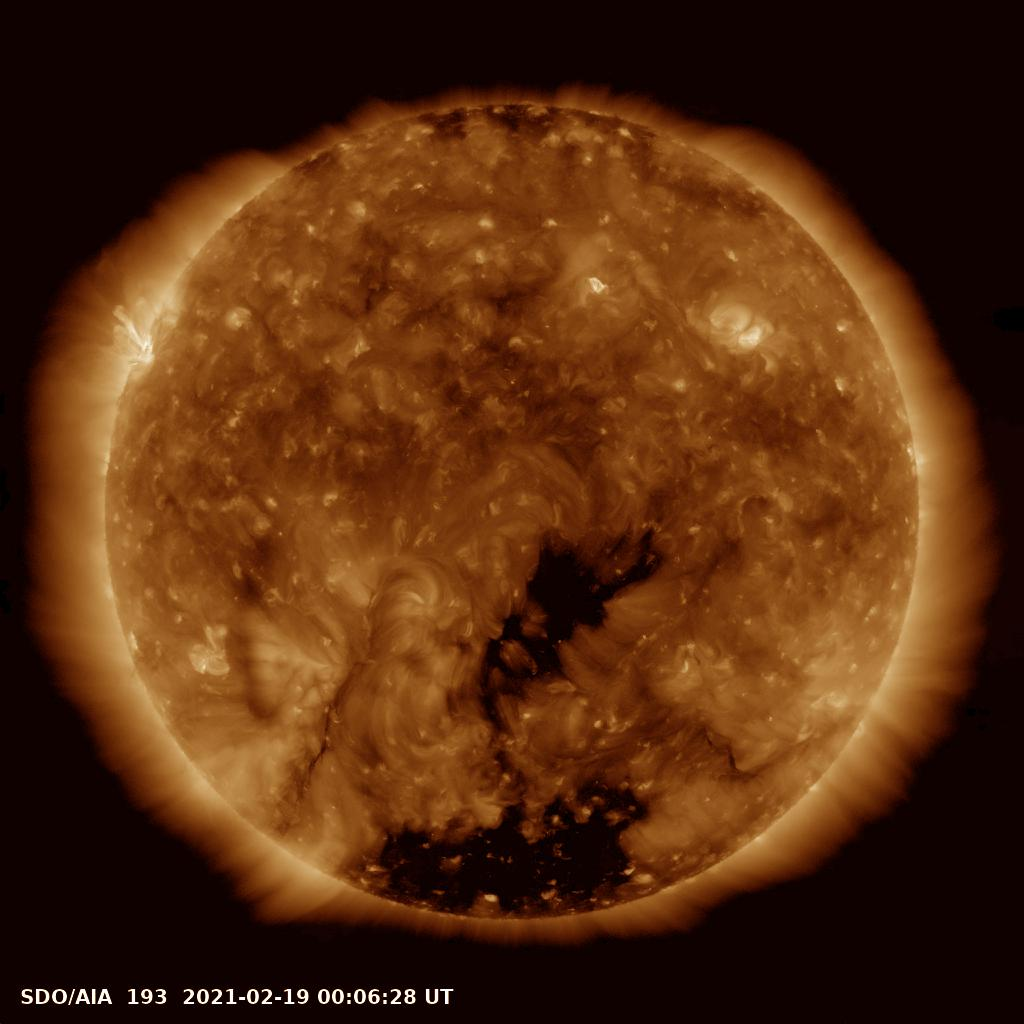

In [5]:
# 이미지 읽기
image_sample = Image.open(sample["image_path"])
image_sample

### 샘플 이미지의 라벨

라벨은 YOLO 형식으로 저장되어 있습니다.

YOLO 형식
`<object-class> <x> <y> <width> <height>`
- object-class: 물체의 클래스
- x, y: 바운딩 박스의 중심의 상대 좌표(0~1 사이 값)
- width, height: 바운딩 박스의 너비와 높이(0~1 사이 값)

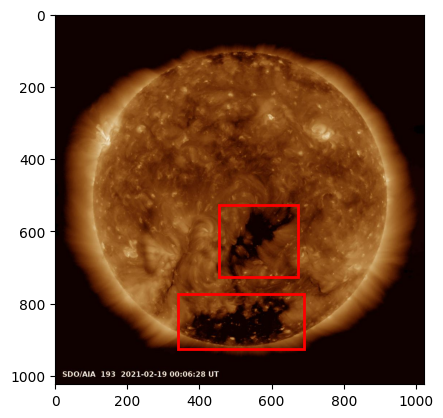

In [6]:
# 데이터프레임 df_train에서 첫 번째 샘플을 가져옴
sample = df_train.iloc[1]

# 플롯(fig)과 축(ax)을 생성
fig, ax = plt.subplots()

# 샘플의 이미지 경로에서 이미지를 열기
img = Image.open(sample["image_path"])

# 이미지 표시
ax.imshow(img)

# 샘플의 라벨 정보에 대해 바운딩 박스를 그림
for label in sample["labels"]:
    # 바운딩 박스 중심 좌표(c_x, c_y)를 이미지의 절대 좌표로 변환
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    
    # 바운딩 박스의 너비(w)와 높이(h)를 이미지의 절대 크기로 변환
    w = label["w"] * img.width
    h = label["h"] * img.height

    # 바운딩 박스의 좌상단(left_top_x, left_top_y) 좌표 계산
    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    # 사각형 객체를 생성하여 바운딩 박스를 그리기
    # 좌상단 좌표 (left_top_x, left_top_y)에서 시작하여 너비 w, 높이 h의 사각형을 그림
    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    
    # 생성된 사각형(rect)을 이미지(ax)에 추가
    ax.add_patch(rect)

# 플롯을 표시
fig.show()


## 데이터 전처리

### 데이터 분리

In [7]:
# 원본 데이터프레임 df_train에서 80%의 데이터를 무작위로 샘플링하여 학습용 데이터셋(df_train_set)을 생성
df_train_set = df_train.sample(frac=0.8, random_state=42)

# df_train_set에 포함되지 않은 나머지 20% 데이터를 검증용 데이터셋(df_valid_set)으로 설정
df_valid_set = df_train.drop(df_train_set.index)

# 학습용 데이터셋을 'train_set.csv' 파일로 저장
df_train_set.to_csv("train_set.csv", index=False)

# 검증용 데이터셋을 'valid_set.csv' 파일로 저장
df_valid_set.to_csv("valid_set.csv", index=False)

# 'train' 디렉터리의 절대 경로를 얻어서 new_train_path 변수에 저장
new_train_path = os.path.abspath("train")

# 'valid' 디렉터리의 절대 경로를 얻어서 new_valid_path 변수에 저장
new_valid_path = os.path.abspath("valid")

# 'new_train_path' 디렉터리를 생성 (이미 존재해도 에러 없이 계속 진행)
os.makedirs(new_train_path, exist_ok=True)

# 'new_train_path' 디렉터리 안에 이미지 파일을 저장할 'IMAGE_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)

# 'new_train_path' 디렉터리 안에 라벨 파일을 저장할 'LABELS_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)

# 'new_valid_path' 디렉터리를 생성 (이미 존재해도 에러 없이 계속 진행)
os.makedirs(new_valid_path, exist_ok=True)

# 'new_valid_path' 디렉터리 안에 이미지 파일을 저장할 'IMAGE_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_valid_path, IMAGE_DIR), exist_ok=True)

# 'new_valid_path' 디렉터리 안에 라벨 파일을 저장할 'LABELS_DIR' 디렉터리를 생성
os.makedirs(os.path.join(new_valid_path, LABELS_DIR), exist_ok=True)


### 데이터 전처리 및 복사

이미지의 크기를 변경하고 각각 폴더에 복사합니다.

YOLO 모델은 상대 좌표를 사용하므로 이미지의 크기가 변경되어도 상대 좌표는 그대로 사용할 수 있습니다.

사용하려는 모델이 절대 좌표를 사용한다면 이미지의 크기를 변경할 때 크기에 맞게 좌표를 변경해야 합니다.

In [8]:
IMAGE_SIZE = 1024

def process_row(row, is_train):
    image = Image.open(row["image_path"])
    if is_train:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_train_path}/{LABELS_DIR}/{row['id']}.txt")
    else:
        image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_path}/{IMAGE_DIR}/{row['id']}.jpg")
        shutil.copy(row["label_path"], f"{new_valid_path}/{LABELS_DIR}/{row['id']}.txt")

def parallel_process(df_list, is_train):
    func = partial(process_row, is_train=is_train)
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(func, df_list), total=len(df_list)))

if __name__ == "__main__":
    # DataFrame을 딕셔너리의 리스트로 변환
    train_list = df_train_set.to_dict('records')
    valid_list = df_valid_set.to_dict('records')

    # 훈련 데이터 처리
    parallel_process(train_list, is_train=True)
    
    # 검증 데이터 처리
    parallel_process(valid_list, is_train=False)

100%|██████████| 2973/2973 [00:03<00:00, 766.10it/s]


## 모델 학습

### 모델 준비

외부 모델을 사용하는 경우 아래처럼 모델을 불러올 수 있습니다.

- 다운로드 하는 코드를 명시
- 필요한 종속성을 설치하는 코드를 명시

In [9]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100 80GB PCIe, 81051MiB)
Setup complete ✅ (16 CPUs, 192.0 GB RAM, 34.2/50.0 GB disk)


### 모델 학습

In [24]:
import os

# 현재 디렉터리의 절대 경로를 얻어와서 dataset 딕셔너리에 저장
dataset = {
    "path": os.path.abspath("."),  # 현재 작업 디렉터리의 절대 경로
    "train": "train",  # 학습 데이터가 저장된 디렉터리 이름
    "val": "valid",  # 검증 데이터가 저장된 디렉터리 이름
    "nc": 3,  # 탐지할 클래스의 수 (예: coronal_hole, sunspot, prominence)
    "names": ["coronal_hole", "sunspot", "prominence"],  # 클래스 이름 리스트
}

# YAML 파일을 저장할 경로를 지정
YAML_PATH = os.path.abspath("sun.yaml")

# 결과를 저장할 디렉터리 경로를 지정하고, 해당 디렉터리가 없으면 생성
RESULT_PATH = os.path.abspath("result240")
os.makedirs(RESULT_PATH, exist_ok=True)

# dataset 딕셔너리를 YAML 형식으로 파일로 저장
import yaml
with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [25]:
!yolo train data={YAML_PATH} model=yolov8l.yaml epochs=70 dropout=0.2 cache=True lr0=0.01 batch=-1 imgsz=640 augment=True workers=4 pretrained=False project={RESULT_PATH} name=sun


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/utils/checks.py:558: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
AMP: checks passed ✅
/home/elicer/.local/lib/python3.10/site-packages/ultralytics/engine/trainer.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.amp)
/home/elicer/.local/lib/python3.10/site-packages/ultralytics/utils/autobatch.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA A100 80GB PCIe) 79.15G total, 0.39G reserved, 0.36G allocated, 78.40G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)           


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/70      49.2G      1.349     0.8322       1.42        216        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.813      0.806      0.878      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/70      49.2G       1.34     0.8204      1.413        254        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.804       0.82      0.879      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/70      49.1G      1.338     0.8156      1.412        201        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240       0.82      0.822      0.889      0.575

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/70        49G      1.223     0.7121      1.339        205        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.851      0.861      0.916      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/70      49.2G      1.217     0.7029      1.332        255        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240       0.86      0.849      0.916      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/70      49.1G      1.219     0.7042      1.333        212        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.853      0.861       0.92      0.639

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      68/70        49G      1.049     0.5377      1.272        164        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.883      0.895      0.941      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      69/70      49.1G       1.04     0.5344      1.267        160        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.884      0.896      0.942      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      70/70      49.1G      1.031     0.5284      1.263        145        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       5342      13240      0.888      0.893      0.942      0.688

70 epochs

## 모델 평가

### 검증 데이터 예측

In [16]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(new_valid_path, IMAGE_DIR)} conf=0.5 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'valid')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

image 67/5342 /home/elicer/valid/images/0353b3412af648e082339f66fc9ddb0e.jpg: 512x512 3 sunspots, 24.2ms
image 68/5342 /home/elicer/valid/images/0354ee9f72204d8b82213b5d291b23f7.jpg: 512x512 (no detections), 24.1ms
image 69/5342 /home/elicer/valid/images/036b7c6f7ad94dd686572ebd60df8aa5.jpg: 512x512 9 sunspots, 28.7ms
image 70/5342 /home/elicer/valid/images/03716201dcb8456387c7aaf8c5b983ba.jpg: 512x512 1 sunspot, 27.4ms
image 71/5342 /home/elicer/valid/images/0371f3d7ba0e4f2c8f40252fd78dd3d7.jpg: 512x512 1 coronal_hole, 28.8ms
image 72/5342 /home/elicer/valid/images/037c6eb7b7694d45bf34bae191b2e734.jpg: 512x512 1 coronal_hole, 29.2ms
image 73/5342 /home/elicer/valid/images/03a6b2cd5b8945fdbbe8775f5f8b8841.jpg: 512x512 2 coronal_holes, 29.7ms
image 74/5342 /home/elicer/valid/images/03a8b3afaafc43b2ae5beaba721931bb.jpg: 512x512 5 sunspots, 34.5ms
image 75/5342 /home/elicer/valid/images/03aec0120df3481d9965e084e17ccb3c.jpg: 512x512 2 coronal_holes, 33.3ms
image 76/5342 /home/elicer/valid/

image 144/5342 /home/elicer/valid/images/06bba16eb81241c2a5e6af654f83e366.jpg: 512x512 6 sunspots, 13.7ms
image 145/5342 /home/elicer/valid/images/06c4e8f4640a4c95933cd8111fab1cba.jpg: 512x512 5 sunspots, 23.5ms
image 146/5342 /home/elicer/valid/images/06df34bbde624668ab895e89c2ae544e.jpg: 512x512 (no detections), 28.7ms
image 147/5342 /home/elicer/valid/images/06f059c90b034c9bb74f01a5259f949c.jpg: 512x512 (no detections), 28.2ms
image 148/5342 /home/elicer/valid/images/06f16e35adcf415e8409b312dacb87ab.jpg: 512x512 4 prominences, 29.5ms
image 149/5342 /home/elicer/valid/images/07079bd927894d8db97c7a865ebbb286.jpg: 512x512 (no detections), 23.9ms
image 150/5342 /home/elicer/valid/images/071dd5de9b3f46cb92ad7f064bd85b4f.jpg: 512x512 1 prominence, 28.2ms
image 151/5342 /home/elicer/valid/images/075821e2526e466783cb3833ce9292bc.jpg: 512x512 (no detections), 28.8ms
image 152/5342 /home/elicer/valid/images/075967d732e04f478fde945b4e58e5c8.jpg: 512x512 (no detections), 28.9ms
image 153/5342 /

image 219/5342 /home/elicer/valid/images/0a70a8161b1549868a8cec9bde9ba571.jpg: 512x512 3 coronal_holes, 29.1ms
image 220/5342 /home/elicer/valid/images/0a732dc8c9cb47fb867a267676087f78.jpg: 512x512 2 coronal_holes, 28.8ms
image 221/5342 /home/elicer/valid/images/0a7d5b77aed9496181ca4cfd1b3bea8f.jpg: 512x512 3 coronal_holes, 23.2ms
image 222/5342 /home/elicer/valid/images/0a85ee65939043ec98357ceb389cacf2.jpg: 512x512 2 coronal_holes, 22.7ms
image 223/5342 /home/elicer/valid/images/0a9437e38d05425bb447b237e5efb818.jpg: 512x512 (no detections), 29.5ms
image 224/5342 /home/elicer/valid/images/0abadbcba9194b9591d609f21612c910.jpg: 512x512 2 coronal_holes, 23.0ms
image 225/5342 /home/elicer/valid/images/0acfc2b27e01448d921c923ab66b3311.jpg: 512x512 2 coronal_holes, 21.8ms
image 226/5342 /home/elicer/valid/images/0ad8dd40e5b44a1cb8c82a073046aa91.jpg: 512x512 6 sunspots, 24.5ms
image 227/5342 /home/elicer/valid/images/0ae4ea8dd1004baea71aa8cd1d6f0508.jpg: 512x512 1 sunspot, 14.9ms
image 228/53

image 295/5342 /home/elicer/valid/images/0dce8832934e4a048ba79164f62ccb60.jpg: 512x512 (no detections), 18.9ms
image 296/5342 /home/elicer/valid/images/0de04e99a8804ffb87ed7174c00ef81b.jpg: 512x512 3 coronal_holes, 23.8ms
image 297/5342 /home/elicer/valid/images/0de19aa96fd04ea4a83d373fcdd17f0b.jpg: 512x512 2 coronal_holes, 24.3ms
image 298/5342 /home/elicer/valid/images/0de8efc0e0da4530be875a63977e05a0.jpg: 512x512 (no detections), 29.1ms
image 299/5342 /home/elicer/valid/images/0df9292e669f4686be0f765f1f16016c.jpg: 512x512 2 coronal_holes, 24.0ms
image 300/5342 /home/elicer/valid/images/0dfa60a9a6d2497eb2295a1917179854.jpg: 512x512 2 coronal_holes, 22.7ms
image 301/5342 /home/elicer/valid/images/0e05c0e6ec5342ec83a8d7d2e7772296.jpg: 512x512 4 sunspots, 23.8ms
image 302/5342 /home/elicer/valid/images/0e17f2ef2911499ba85cb8649d08c417.jpg: 512x512 4 sunspots, 23.9ms
image 303/5342 /home/elicer/valid/images/0e30c96d1c56437e94fe677beb510530.jpg: 512x512 2 coronal_holes, 28.3ms
image 304/5

image 370/5342 /home/elicer/valid/images/115ad308eee64697b002695208a4ce47.jpg: 512x512 (no detections), 22.7ms
image 371/5342 /home/elicer/valid/images/115b4f85e01242e4892909afd0872bf3.jpg: 512x512 (no detections), 23.6ms
image 372/5342 /home/elicer/valid/images/115e21407b094423b357c644e0b275b7.jpg: 512x512 1 prominence, 22.4ms
image 373/5342 /home/elicer/valid/images/115fc12c968841bab0d2f9c76e4f0425.jpg: 512x512 (no detections), 28.4ms
image 374/5342 /home/elicer/valid/images/1168dc0fad064a0e84b00bfb0632abe5.jpg: 512x512 4 sunspots, 27.8ms
image 375/5342 /home/elicer/valid/images/116aa7fdf36d4a29bb5635be143c13e6.jpg: 512x512 2 prominences, 29.4ms
image 376/5342 /home/elicer/valid/images/116c08305cd74d7281fd849ccf550fdd.jpg: 512x512 1 prominence, 29.2ms
image 377/5342 /home/elicer/valid/images/116cc1dd56e841e58990bff4f1e7d372.jpg: 512x512 4 sunspots, 24.6ms
image 378/5342 /home/elicer/valid/images/11783e53d4964c989e0d94adf56413e8.jpg: 512x512 2 coronal_holes, 28.0ms
image 379/5342 /hom

image 446/5342 /home/elicer/valid/images/14c261057dcd458bb1c299889063e063.jpg: 512x512 1 prominence, 29.0ms
image 447/5342 /home/elicer/valid/images/14c3571d3a92472fba4a44f08573dc48.jpg: 512x512 5 sunspots, 29.5ms
image 448/5342 /home/elicer/valid/images/14c65c91806d4136aa8aec3a5b92d534.jpg: 512x512 2 coronal_holes, 27.8ms
image 449/5342 /home/elicer/valid/images/14c8f171a5aa4bd7a4538eceb188a3db.jpg: 512x512 2 coronal_holes, 23.7ms
image 450/5342 /home/elicer/valid/images/14d020876bd648bda9515b896b0bc593.jpg: 512x512 2 sunspots, 23.7ms
image 451/5342 /home/elicer/valid/images/14e2ca18cfab4f8ca79e4db7b63456d6.jpg: 512x512 2 prominences, 24.5ms
image 452/5342 /home/elicer/valid/images/15037e1193e64ba7b1e50daae09fae83.jpg: 512x512 (no detections), 22.1ms
image 453/5342 /home/elicer/valid/images/150fe93716e246b49dfd01cfd78d753e.jpg: 512x512 (no detections), 23.8ms
image 454/5342 /home/elicer/valid/images/15138ddfc53b4fbd820c728190e2887a.jpg: 512x512 4 sunspots, 22.6ms
image 455/5342 /home/

image 522/5342 /home/elicer/valid/images/180d69cb03c248389cf10ded1a2b5738.jpg: 512x512 5 sunspots, 13.9ms
image 523/5342 /home/elicer/valid/images/182eb8b9944844a48d8f4265b0be7777.jpg: 512x512 6 sunspots, 23.4ms
image 524/5342 /home/elicer/valid/images/1833e0744f304ce4a0f5ff44005073af.jpg: 512x512 2 sunspots, 27.7ms
image 525/5342 /home/elicer/valid/images/1834796784b74a0d9b6b1a50280c539d.jpg: 512x512 (no detections), 28.4ms
image 526/5342 /home/elicer/valid/images/1834eb669c5e43a1bb719673e566e7cf.jpg: 512x512 1 prominence, 23.2ms
image 527/5342 /home/elicer/valid/images/18383214db8a4e76b06fad2ab9b06bec.jpg: 512x512 1 prominence, 24.0ms
image 528/5342 /home/elicer/valid/images/1838681b24f94b32ae6c6930b50e03ec.jpg: 512x512 1 sunspot, 29.8ms
image 529/5342 /home/elicer/valid/images/1867283ba7d24ebea90c86e7c74924af.jpg: 512x512 8 sunspots, 24.6ms
image 530/5342 /home/elicer/valid/images/186a2264556f4f9ba51154f4a897f8b8.jpg: 512x512 (no detections), 28.3ms
image 531/5342 /home/elicer/valid

image 598/5342 /home/elicer/valid/images/1b52bc2f89054bf2a9846e7e5382b404.jpg: 512x512 2 coronal_holes, 29.6ms
image 599/5342 /home/elicer/valid/images/1b58a22fc80e4b99ade58a92e378d820.jpg: 512x512 4 sunspots, 28.2ms
image 600/5342 /home/elicer/valid/images/1b5dfbb1dfad4046a0c7c7e04ffc5b4a.jpg: 512x512 3 sunspots, 23.9ms
image 601/5342 /home/elicer/valid/images/1b62f02110ca421ebe3e74d2276d2787.jpg: 512x512 3 coronal_holes, 28.2ms
image 602/5342 /home/elicer/valid/images/1b654318f8494d48a1bc04d934586f7f.jpg: 512x512 1 sunspot, 11.7ms
image 603/5342 /home/elicer/valid/images/1b6a03a6ced049d2a0fabd45e7c9022a.jpg: 512x512 1 coronal_hole, 17.4ms
image 604/5342 /home/elicer/valid/images/1b74db0cfc4744aaa163054a3926fac4.jpg: 512x512 3 coronal_holes, 28.6ms
image 605/5342 /home/elicer/valid/images/1b7ec1a8d4874b1298320c019478fc36.jpg: 512x512 1 prominence, 30.0ms
image 606/5342 /home/elicer/valid/images/1b860c071c814951b53cf18bcb5ccc81.jpg: 512x512 2 prominences, 27.6ms
image 607/5342 /home/el

image 674/5342 /home/elicer/valid/images/1ef5ce65251d4686bda9aa91b43498b8.jpg: 512x512 (no detections), 19.0ms
image 675/5342 /home/elicer/valid/images/1f0df758beeb47cb92e8d61f75980c1e.jpg: 512x512 (no detections), 19.2ms
image 676/5342 /home/elicer/valid/images/1f15a45b718546d1a76fa47dd8c6bdcc.jpg: 512x512 1 prominence, 23.1ms
image 677/5342 /home/elicer/valid/images/1f282c461e1b4e2999a71c673d25d74e.jpg: 512x512 1 prominence, 27.7ms
image 678/5342 /home/elicer/valid/images/1f400720893a4da499b6f55bcceef93a.jpg: 512x512 1 coronal_hole, 29.6ms
image 679/5342 /home/elicer/valid/images/1f46c25d3e5944219e1406326f6a64cd.jpg: 512x512 1 prominence, 24.3ms
image 680/5342 /home/elicer/valid/images/1f481c19715a44d884ea1a51f4fe6149.jpg: 512x512 (no detections), 28.2ms
image 681/5342 /home/elicer/valid/images/1f4adf8cc6ff4cb9a3e469c63b6a713f.jpg: 512x512 4 sunspots, 24.4ms
image 682/5342 /home/elicer/valid/images/1f4b1df104dc46eabbdc7282248e3892.jpg: 512x512 2 prominences, 29.1ms
image 683/5342 /ho

image 750/5342 /home/elicer/valid/images/229f58d155714477a81f9363a1f03a50.jpg: 512x512 3 sunspots, 28.6ms
image 751/5342 /home/elicer/valid/images/22abecedcdfd4933b602260a08a52023.jpg: 512x512 1 coronal_hole, 22.6ms
image 752/5342 /home/elicer/valid/images/22abfe3a27ef46e39d39e7a484d4dd03.jpg: 512x512 2 prominences, 23.8ms
image 753/5342 /home/elicer/valid/images/22afc01c1a0f483fa5c973cb27d1d61f.jpg: 512x512 2 coronal_holes, 23.8ms
image 754/5342 /home/elicer/valid/images/22c2c8cb04e2411b8264a02b9e217c67.jpg: 512x512 1 prominence, 18.1ms
image 755/5342 /home/elicer/valid/images/22ca230f748c4b4d831f345b4d400032.jpg: 512x512 1 coronal_hole, 19.0ms
image 756/5342 /home/elicer/valid/images/22cc9750b3e343359be22c7bc10cec88.jpg: 512x512 2 prominences, 23.6ms
image 757/5342 /home/elicer/valid/images/22e16ef250af47fc8c3aea0f2622e964.jpg: 512x512 4 sunspots, 14.0ms
image 758/5342 /home/elicer/valid/images/231a63cfe9b44adea32e4347a76e7c78.jpg: 512x512 (no detections), 13.9ms
image 759/5342 /home

image 826/5342 /home/elicer/valid/images/26dfc3e2cee445af86523208bc9d390f.jpg: 512x512 1 sunspot, 16.8ms
image 827/5342 /home/elicer/valid/images/26f4c3a587a543b0b6631e831356b837.jpg: 512x512 2 coronal_holes, 28.5ms
image 828/5342 /home/elicer/valid/images/2701b10ace1341c0b1076ffe1d3991b6.jpg: 512x512 3 coronal_holes, 24.6ms
image 829/5342 /home/elicer/valid/images/272ccf568af1482c85aba6c00e163f7e.jpg: 512x512 1 coronal_hole, 28.4ms
image 830/5342 /home/elicer/valid/images/272ede2956314f2f8352d7085c8e5383.jpg: 512x512 (no detections), 22.5ms
image 831/5342 /home/elicer/valid/images/273cae6c37fa41c2bd32118ecfb58806.jpg: 512x512 (no detections), 22.8ms
image 832/5342 /home/elicer/valid/images/2740a089200d41f4afa87f947d3e3ff5.jpg: 512x512 2 coronal_holes, 23.3ms
image 833/5342 /home/elicer/valid/images/274457f169b449d3b27e4062308fd53c.jpg: 512x512 7 sunspots, 27.5ms
image 834/5342 /home/elicer/valid/images/274709041c324dc7be41f2647b012fa3.jpg: 512x512 (no detections), 29.0ms
image 835/534

image 902/5342 /home/elicer/valid/images/2a224b79edb1460fac750b86d76504c5.jpg: 512x512 2 coronal_holes, 22.0ms
image 903/5342 /home/elicer/valid/images/2a234fd9987848c8ab5ae44a02cc37dc.jpg: 512x512 1 coronal_hole, 24.3ms
image 904/5342 /home/elicer/valid/images/2a2687841ae34fc4b6611d2d4568092e.jpg: 512x512 3 coronal_holes, 29.0ms
image 905/5342 /home/elicer/valid/images/2a33a360d60e43008914cd0092668861.jpg: 512x512 2 coronal_holes, 24.6ms
image 906/5342 /home/elicer/valid/images/2a3450546a8a4f1bb1c410da34c07750.jpg: 512x512 3 sunspots, 23.0ms
image 907/5342 /home/elicer/valid/images/2a40eef8373d4e0f82dbf35f29184345.jpg: 512x512 4 sunspots, 27.8ms
image 908/5342 /home/elicer/valid/images/2a5c018b741d4aa592eb39ca2757782c.jpg: 512x512 1 coronal_hole, 18.2ms
image 909/5342 /home/elicer/valid/images/2a61ef3cdea64a37867df261686bf8e5.jpg: 512x512 3 coronal_holes, 12.7ms
image 910/5342 /home/elicer/valid/images/2a68fd512538477286fe039a07cc5bf8.jpg: 512x512 1 prominence, 13.0ms
image 911/5342 /

image 978/5342 /home/elicer/valid/images/2d739cbaebaa4121801b98f0ce3de599.jpg: 512x512 1 prominence, 22.6ms
image 979/5342 /home/elicer/valid/images/2d7756230ffa41918b2e2cf0bab85883.jpg: 512x512 5 sunspots, 22.1ms
image 980/5342 /home/elicer/valid/images/2d7eb923c6ba4295b81cb4fae7bc0931.jpg: 512x512 1 coronal_hole, 8.0ms
image 981/5342 /home/elicer/valid/images/2d8ed50e88ee478e94bbfa651470a733.jpg: 512x512 1 coronal_hole, 11.8ms
image 982/5342 /home/elicer/valid/images/2dad93e9c2984e1fa0fe30f0844801b8.jpg: 512x512 2 coronal_holes, 18.7ms
image 983/5342 /home/elicer/valid/images/2daf8b2d45974c36a23a92a496fb7659.jpg: 512x512 2 prominences, 23.4ms
image 984/5342 /home/elicer/valid/images/2dbd341155b84177b95d0a4f31703553.jpg: 512x512 2 coronal_holes, 24.2ms
image 985/5342 /home/elicer/valid/images/2dd57f9fd7a24dc2bfe68f22b5b2877d.jpg: 512x512 (no detections), 23.9ms
image 986/5342 /home/elicer/valid/images/2de4a165b9eb403bb61bba48374f62e6.jpg: 512x512 (no detections), 27.8ms
image 987/5342

image 1053/5342 /home/elicer/valid/images/307c10d11c9c4dc997857a11508ff85a.jpg: 512x512 6 sunspots, 28.6ms
image 1054/5342 /home/elicer/valid/images/30938205ce7048738dc34378ed91ff83.jpg: 512x512 (no detections), 28.0ms
image 1055/5342 /home/elicer/valid/images/30a47c7cb1a8442482793b8a3d5b1558.jpg: 512x512 (no detections), 28.7ms
image 1056/5342 /home/elicer/valid/images/30d3d116053e4587b44f8f2da095f95a.jpg: 512x512 2 sunspots, 22.7ms
image 1057/5342 /home/elicer/valid/images/30dfd84512774fb9baec721798932eb1.jpg: 512x512 (no detections), 24.5ms
image 1058/5342 /home/elicer/valid/images/30e9f7d07f4640e0acd384cbed6abd80.jpg: 512x512 2 sunspots, 24.0ms
image 1059/5342 /home/elicer/valid/images/30eabdf4cb6e4a51bc5f9731d1f85a03.jpg: 512x512 (no detections), 28.0ms
image 1060/5342 /home/elicer/valid/images/30f4b7f1aae746fc9d88e7fc1bbfb482.jpg: 512x512 2 prominences, 28.8ms
image 1061/5342 /home/elicer/valid/images/31323d14bf2340db8d606325526122da.jpg: 512x512 2 prominences, 29.1ms
image 1062/

image 1128/5342 /home/elicer/valid/images/344f75af52da4e4b8dd6e896d4a19d3a.jpg: 512x512 1 coronal_hole, 22.6ms
image 1129/5342 /home/elicer/valid/images/34569bdbea494c4cb463aef21e0f27ed.jpg: 512x512 3 sunspots, 23.8ms
image 1130/5342 /home/elicer/valid/images/34584b87db0641149945c8113a66d175.jpg: 512x512 2 coronal_holes, 23.3ms
image 1131/5342 /home/elicer/valid/images/3468d41bb27e41d2afb9f4f7c0e24fb3.jpg: 512x512 2 coronal_holes, 12.2ms
image 1132/5342 /home/elicer/valid/images/347461b4d4c54dc494354d8382c644d4.jpg: 512x512 3 sunspots, 28.0ms
image 1133/5342 /home/elicer/valid/images/34928551e53c4d1aa754ae40c8276609.jpg: 512x512 4 sunspots, 24.0ms
image 1134/5342 /home/elicer/valid/images/34a1398f36e643ab83cff245c00e2b5f.jpg: 512x512 1 sunspot, 29.2ms
image 1135/5342 /home/elicer/valid/images/34ad41f6acb74a66b6bae6eaaf421805.jpg: 512x512 2 coronal_holes, 28.5ms
image 1136/5342 /home/elicer/valid/images/34adea3a632c44c3a125849a07642c23.jpg: 512x512 1 coronal_hole, 33.5ms
image 1137/5342

image 1202/5342 /home/elicer/valid/images/3823fbe7dc344ac3a1de2ed085f7538f.jpg: 512x512 7 sunspots, 28.7ms
image 1203/5342 /home/elicer/valid/images/382819d0b14c471098e3c04fed2f1d86.jpg: 512x512 (no detections), 29.2ms
image 1204/5342 /home/elicer/valid/images/3855a646f19a430889a324576e914570.jpg: 512x512 2 coronal_holes, 23.8ms
image 1205/5342 /home/elicer/valid/images/38837715ad9c4af9bedfea9593487ec6.jpg: 512x512 (no detections), 28.5ms
image 1206/5342 /home/elicer/valid/images/3887ad74bf7241ab83bfbcfb3a0b8d69.jpg: 512x512 (no detections), 24.5ms
image 1207/5342 /home/elicer/valid/images/38899289fea6482cb72afdbaaf6d0cb4.jpg: 512x512 6 sunspots, 29.5ms
image 1208/5342 /home/elicer/valid/images/389a61203a784e91997a677e1080c21e.jpg: 512x512 2 coronal_holes, 13.0ms
image 1209/5342 /home/elicer/valid/images/38a07004f3714cc9a52ed4336f64f50e.jpg: 512x512 1 coronal_hole, 13.5ms
image 1210/5342 /home/elicer/valid/images/38a287d478274a0a989bd73d92f93f0c.jpg: 512x512 3 coronal_holes, 29.3ms
ima

image 1277/5342 /home/elicer/valid/images/3b58fa91f0204765b7eec6d5b8d44d38.jpg: 512x512 1 coronal_hole, 29.6ms
image 1278/5342 /home/elicer/valid/images/3b6e5c886d614617966f79f54ec0f7ec.jpg: 512x512 2 coronal_holes, 28.3ms
image 1279/5342 /home/elicer/valid/images/3b78262bc4af4e0986c01b2e0802a922.jpg: 512x512 (no detections), 28.5ms
image 1280/5342 /home/elicer/valid/images/3b845d72f3b44e4dba8222d5f415ec83.jpg: 512x512 3 sunspots, 22.2ms
image 1281/5342 /home/elicer/valid/images/3b9d621ae48540548fbf1407d58b9aa3.jpg: 512x512 (no detections), 23.3ms
image 1282/5342 /home/elicer/valid/images/3bb54a65c31549a7a568a91783128025.jpg: 512x512 8 sunspots, 23.1ms
image 1283/5342 /home/elicer/valid/images/3bc65e649dd94b05a73042e33299d109.jpg: 512x512 1 prominence, 22.0ms
image 1284/5342 /home/elicer/valid/images/3bcdde6535c64c0ea8ff267af5e561a1.jpg: 512x512 1 coronal_hole, 18.7ms
image 1285/5342 /home/elicer/valid/images/3bdacd17f71a459fa6eb57e6d7d3f5cc.jpg: 512x512 3 sunspots, 22.9ms
image 1286/5

image 1352/5342 /home/elicer/valid/images/3ef11d15d6c9451ea40337cc4669ace3.jpg: 512x512 (no detections), 24.4ms
image 1353/5342 /home/elicer/valid/images/3ef8c9dbca494090b88ff3dffb274b13.jpg: 512x512 (no detections), 24.3ms
image 1354/5342 /home/elicer/valid/images/3eff690ff5ea4fa48fdc8919693b3a64.jpg: 512x512 1 sunspot, 24.3ms
image 1355/5342 /home/elicer/valid/images/3f0808338d8d4d37bf4ebec191642c79.jpg: 512x512 3 coronal_holes, 28.9ms
image 1356/5342 /home/elicer/valid/images/3f11c0fd1794478d8dbb3baaa73eb825.jpg: 512x512 3 coronal_holes, 10.1ms
image 1357/5342 /home/elicer/valid/images/3f141b8933a9494daa443a4d419b6c5e.jpg: 512x512 (no detections), 27.7ms
image 1358/5342 /home/elicer/valid/images/3f254e8a60ed451fa45c8126e0dbc7cd.jpg: 512x512 3 prominences, 28.8ms
image 1359/5342 /home/elicer/valid/images/3f486541e6404d6e8348e1e59279ec4a.jpg: 512x512 3 coronal_holes, 24.6ms
image 1360/5342 /home/elicer/valid/images/3f5a890e5195476e869a58ae20cc5509.jpg: 512x512 3 coronal_holes, 23.5ms


image 1427/5342 /home/elicer/valid/images/423c60f8033b4971b5b4f8b78d12c688.jpg: 512x512 1 sunspot, 16.8ms
image 1428/5342 /home/elicer/valid/images/4248897b90774738abd011b098117a59.jpg: 512x512 (no detections), 23.5ms
image 1429/5342 /home/elicer/valid/images/4249615acf2049a6a32871e8f710e923.jpg: 512x512 2 coronal_holes, 22.6ms
image 1430/5342 /home/elicer/valid/images/42707135458345eb9d2db4f60b37ca49.jpg: 512x512 5 sunspots, 23.8ms
image 1431/5342 /home/elicer/valid/images/428114c7df3748f8ad91b936fb8fcdc1.jpg: 512x512 3 coronal_holes, 22.8ms
image 1432/5342 /home/elicer/valid/images/42837d6a18684a8281e53149570ba2d1.jpg: 512x512 (no detections), 28.1ms
image 1433/5342 /home/elicer/valid/images/428a9df734db4824a753d1b65ea4a047.jpg: 512x512 2 coronal_holes, 27.3ms
image 1434/5342 /home/elicer/valid/images/42a3694365a34ae69ff9d96c45ee6b20.jpg: 512x512 1 prominence, 27.5ms
image 1435/5342 /home/elicer/valid/images/42a7d3beb8214fa895df7f56fb2f7968.jpg: 512x512 2 coronal_holes, 29.7ms
image 

image 1502/5342 /home/elicer/valid/images/463182553f764fb1847aa78f7007f48c.jpg: 512x512 6 sunspots, 29.2ms
image 1503/5342 /home/elicer/valid/images/465540d2881d4309af7949958492d9d6.jpg: 512x512 2 prominences, 23.2ms
image 1504/5342 /home/elicer/valid/images/465bf190c5bd43da8623d6c54a167ed0.jpg: 512x512 7 sunspots, 23.8ms
image 1505/5342 /home/elicer/valid/images/465e3173b90a4c1d84af699883b85855.jpg: 512x512 2 prominences, 21.8ms
image 1506/5342 /home/elicer/valid/images/4673f506e26a4d659995496c3490a992.jpg: 512x512 5 sunspots, 22.9ms
image 1507/5342 /home/elicer/valid/images/4675de2c08b34ce78a7e28614fae6d01.jpg: 512x512 4 sunspots, 24.3ms
image 1508/5342 /home/elicer/valid/images/467b0b8adc9044ceb2fa43d885194779.jpg: 512x512 1 sunspot, 11.6ms
image 1509/5342 /home/elicer/valid/images/467bb9430cc34dad84e398b502cbf3c2.jpg: 512x512 2 sunspots, 13.4ms
image 1510/5342 /home/elicer/valid/images/46965430589243caaf289efef166b02b.jpg: 512x512 5 sunspots, 23.3ms
image 1511/5342 /home/elicer/val

image 1577/5342 /home/elicer/valid/images/4940af6ae84d43bbaec798851ca47e6f.jpg: 512x512 2 prominences, 18.8ms
image 1578/5342 /home/elicer/valid/images/4954762fc0b649c29228a353bc13ceae.jpg: 512x512 (no detections), 22.7ms
image 1579/5342 /home/elicer/valid/images/4955712c91a3452eba0601cc56941dc6.jpg: 512x512 5 sunspots, 18.9ms
image 1580/5342 /home/elicer/valid/images/49620e6c93bb4934be60fad599bbe8d0.jpg: 512x512 (no detections), 17.3ms
image 1581/5342 /home/elicer/valid/images/4988e16be93047c7bb93a1a4b5c9a720.jpg: 512x512 2 coronal_holes, 17.9ms
image 1582/5342 /home/elicer/valid/images/498d76a25eed4a85ab87ca2a7c17e171.jpg: 512x512 3 sunspots, 18.9ms
image 1583/5342 /home/elicer/valid/images/49916a712bcd4e6eaba9d7e78f326218.jpg: 512x512 (no detections), 18.3ms
image 1584/5342 /home/elicer/valid/images/49949485be2c440cb7e36bfa51cac9da.jpg: 512x512 1 coronal_hole, 17.7ms
image 1585/5342 /home/elicer/valid/images/49988cc842a540928652087e568a30f5.jpg: 512x512 1 prominence, 17.8ms
image 15

image 1652/5342 /home/elicer/valid/images/4ca04e0bcb044154a89658404daa48e2.jpg: 512x512 1 coronal_hole, 24.2ms
image 1653/5342 /home/elicer/valid/images/4ca2f7ee307948fcb1b6164c9e454714.jpg: 512x512 2 coronal_holes, 30.1ms
image 1654/5342 /home/elicer/valid/images/4cb0b4a4a99940eb82cbfcbc2b15ffd4.jpg: 512x512 6 sunspots, 24.6ms
image 1655/5342 /home/elicer/valid/images/4cb84df3bdb04deba77363a4ee45d0d9.jpg: 512x512 1 coronal_hole, 29.7ms
image 1656/5342 /home/elicer/valid/images/4cde2dfc622d4235bf88d82060d3a222.jpg: 512x512 (no detections), 29.6ms
image 1657/5342 /home/elicer/valid/images/4cdff9929e6c411d9d42b446be7afb26.jpg: 512x512 1 prominence, 27.8ms
image 1658/5342 /home/elicer/valid/images/4ceda98fcf6441aaa43351cb11b15731.jpg: 512x512 2 coronal_holes, 29.8ms
image 1659/5342 /home/elicer/valid/images/4cee436bb63d46e398d3221172e5c698.jpg: 512x512 3 coronal_holes, 30.1ms
image 1660/5342 /home/elicer/valid/images/4cef4463df044d8eb0ffb32bad38900f.jpg: 512x512 2 sunspots, 15.5ms
image 1

image 1727/5342 /home/elicer/valid/images/4fa69949ec5e40a69f054ab6862c4a5b.jpg: 512x512 4 sunspots, 28.1ms
image 1728/5342 /home/elicer/valid/images/4fbf8cf8b022489aa9c2856c7cd5c470.jpg: 512x512 2 coronal_holes, 33.8ms
image 1729/5342 /home/elicer/valid/images/4fd619ff06a043abb07f58810e9518f2.jpg: 512x512 6 sunspots, 30.2ms
image 1730/5342 /home/elicer/valid/images/4ff942086beb47eabad9a4e47ca54ba1.jpg: 512x512 8 sunspots, 23.7ms
image 1731/5342 /home/elicer/valid/images/4ffbe3d927ab49bfa38cbca35ca9dea9.jpg: 512x512 2 coronal_holes, 28.8ms
image 1732/5342 /home/elicer/valid/images/5002f9d769c24b42b56f6e64c055d51e.jpg: 512x512 1 sunspot, 28.3ms
image 1733/5342 /home/elicer/valid/images/50041310b0714efd90d979f9a0ea6177.jpg: 512x512 3 prominences, 21.9ms
image 1734/5342 /home/elicer/valid/images/500aa3f3f72a43f88dfbd85d576267fa.jpg: 512x512 4 sunspots, 24.4ms
image 1735/5342 /home/elicer/valid/images/5010551b23cd482f822740e0fc5ffbd4.jpg: 512x512 (no detections), 10.9ms
image 1736/5342 /hom

image 1802/5342 /home/elicer/valid/images/5313889bf5934ef382e2dd4f1545135b.jpg: 512x512 (no detections), 29.4ms
image 1803/5342 /home/elicer/valid/images/532282e0449e400c976a1ab93eeba736.jpg: 512x512 4 sunspots, 24.5ms
image 1804/5342 /home/elicer/valid/images/5332203c45d34c63aafa270ef4afaae6.jpg: 512x512 5 sunspots, 28.8ms
image 1805/5342 /home/elicer/valid/images/533b77955c424b19b4b28bdb863e3b71.jpg: 512x512 (no detections), 29.4ms
image 1806/5342 /home/elicer/valid/images/533d961cf3174ab09127db674ea8d204.jpg: 512x512 3 coronal_holes, 29.9ms
image 1807/5342 /home/elicer/valid/images/533eb55eb0b44f3a953de290ae9927b6.jpg: 512x512 2 coronal_holes, 12.7ms
image 1808/5342 /home/elicer/valid/images/533ee7f0f685421597b8fee93dba8ade.jpg: 512x512 (no detections), 17.3ms
image 1809/5342 /home/elicer/valid/images/534cb71c04b74b66b0d9f4b5d6d6d04b.jpg: 512x512 3 sunspots, 29.8ms
image 1810/5342 /home/elicer/valid/images/5351fb64b2e2477a99761d9f92434390.jpg: 512x512 (no detections), 29.8ms
image 1

image 1877/5342 /home/elicer/valid/images/56370f7bc8d94596933ebfcede9ceac4.jpg: 512x512 (no detections), 28.8ms
image 1878/5342 /home/elicer/valid/images/563ea84dd56f4714ade5734be9e8f966.jpg: 512x512 2 coronal_holes, 29.4ms
image 1879/5342 /home/elicer/valid/images/563eb04a59464fa693dd11f2fcd7a58c.jpg: 512x512 7 sunspots, 29.1ms
image 1880/5342 /home/elicer/valid/images/563ec03e6d63440e937981fae3e3fc28.jpg: 512x512 3 prominences, 23.6ms
image 1881/5342 /home/elicer/valid/images/5647d5a89d62475ea211781c786e2d00.jpg: 512x512 (no detections), 23.4ms
image 1882/5342 /home/elicer/valid/images/565c1117cfed4f3c970468b7c3b98113.jpg: 512x512 4 sunspots, 22.8ms
image 1883/5342 /home/elicer/valid/images/56620237597e4d61af9e01dab421bccd.jpg: 512x512 1 coronal_hole, 24.4ms
image 1884/5342 /home/elicer/valid/images/566677f355c14be59add04f2af202270.jpg: 512x512 (no detections), 18.9ms
image 1885/5342 /home/elicer/valid/images/5668070696084fd7865f0059beecfdfe.jpg: 512x512 1 prominence, 23.4ms
image 18

image 1953/5342 /home/elicer/valid/images/5a5a5548f2fe45f784c456979f3355e8.jpg: 512x512 1 sunspot, 22.8ms
image 1954/5342 /home/elicer/valid/images/5a5db74c3b4f4530ad88e20241e499c2.jpg: 512x512 3 prominences, 23.4ms
image 1955/5342 /home/elicer/valid/images/5a70910d7b7f43919b3568a6e209a228.jpg: 512x512 (no detections), 29.0ms
image 1956/5342 /home/elicer/valid/images/5a754e730a8548fe9a39a1e0dd57c2ce.jpg: 512x512 3 coronal_holes, 22.5ms
image 1957/5342 /home/elicer/valid/images/5a798f8895c34ef8abe8b4e93b79e4f5.jpg: 512x512 (no detections), 24.7ms
image 1958/5342 /home/elicer/valid/images/5a847b071e40449e92642630e7b556bd.jpg: 512x512 2 coronal_holes, 28.7ms
image 1959/5342 /home/elicer/valid/images/5a8c26d4e1e24f5bb9d52e3109a441e4.jpg: 512x512 (no detections), 28.5ms
image 1960/5342 /home/elicer/valid/images/5a99d0fec05247c9a4cc9e134129d9be.jpg: 512x512 7 sunspots, 14.4ms
image 1961/5342 /home/elicer/valid/images/5a9af8178c4842ef9f0e77af7526f1b6.jpg: 512x512 (no detections), 28.6ms
image

image 2028/5342 /home/elicer/valid/images/5d0f56a54e8d475f972c67bbc0259f66.jpg: 512x512 1 prominence, 24.3ms
image 2029/5342 /home/elicer/valid/images/5d13fc0f757a4484910c821d40003993.jpg: 512x512 3 sunspots, 28.4ms
image 2030/5342 /home/elicer/valid/images/5d153206ebb8412386927c2de71531c7.jpg: 512x512 2 coronal_holes, 28.2ms
image 2031/5342 /home/elicer/valid/images/5d20f32c07ab4cb2950836c281e60e73.jpg: 512x512 3 sunspots, 28.5ms
image 2032/5342 /home/elicer/valid/images/5d327cfe18e5473c8444264c6f6b8a64.jpg: 512x512 (no detections), 23.0ms
image 2033/5342 /home/elicer/valid/images/5d3ee167b3354aa8816724e1adf1ebac.jpg: 512x512 2 sunspots, 22.1ms
image 2034/5342 /home/elicer/valid/images/5d4915aa67b540bcb9c833c7d9abd793.jpg: 512x512 1 sunspot, 23.7ms
image 2035/5342 /home/elicer/valid/images/5d5882b432de48f2be118ccf4ae23f6e.jpg: 512x512 (no detections), 23.1ms
image 2036/5342 /home/elicer/valid/images/5d69f8e7382740999e7b4a0237f662d3.jpg: 512x512 3 sunspots, 22.0ms
image 2037/5342 /home

image 2103/5342 /home/elicer/valid/images/60779cbe17e04c4da833c87612c92fe4.jpg: 512x512 1 coronal_hole, 28.8ms
image 2104/5342 /home/elicer/valid/images/607a5e49075441629f535dc3e080e144.jpg: 512x512 2 sunspots, 28.3ms
image 2105/5342 /home/elicer/valid/images/608264870dac460a88a6c1ac0146f1b0.jpg: 512x512 3 coronal_holes, 24.6ms
image 2106/5342 /home/elicer/valid/images/60a82269e6214d3fab542ef7906760aa.jpg: 512x512 5 sunspots, 27.8ms
image 2107/5342 /home/elicer/valid/images/60b0d450c92a4b60abdd0eae648afd88.jpg: 512x512 (no detections), 12.8ms
image 2108/5342 /home/elicer/valid/images/60b155dfa85f432f827599c0bd23b150.jpg: 512x512 (no detections), 13.0ms
image 2109/5342 /home/elicer/valid/images/60b41491fd4a46159fdbee8a9c6dfb1d.jpg: 512x512 1 prominence, 23.0ms
image 2110/5342 /home/elicer/valid/images/60c1cbddddd947048aeb6969e60a7cbd.jpg: 512x512 3 coronal_holes, 28.0ms
image 2111/5342 /home/elicer/valid/images/60ce4bb38440498bbf0f5aa4c685354c.jpg: 512x512 1 coronal_hole, 28.9ms
image 2

image 2178/5342 /home/elicer/valid/images/63e33662867d425ab286f8d0323cebf4.jpg: 512x512 2 sunspots, 22.1ms
image 2179/5342 /home/elicer/valid/images/63f7193c19ea44afa3a6b0b0d544f915.jpg: 512x512 1 coronal_hole, 24.3ms
image 2180/5342 /home/elicer/valid/images/63fb38f99fe545b485c574a023af98bf.jpg: 512x512 1 prominence, 27.8ms
image 2181/5342 /home/elicer/valid/images/6402866b51f84a90a1b9bdc1b8485499.jpg: 512x512 2 coronal_holes, 23.7ms
image 2182/5342 /home/elicer/valid/images/6403a21c6d9446e9a7b5c95160920f05.jpg: 512x512 (no detections), 23.6ms
image 2183/5342 /home/elicer/valid/images/640e1b4df8004ceba93968f4c27b8be5.jpg: 512x512 1 coronal_hole, 23.3ms
image 2184/5342 /home/elicer/valid/images/641049ca549445e7bf5602670bedfc17.jpg: 512x512 (no detections), 24.6ms
image 2185/5342 /home/elicer/valid/images/641164f409d34928ac3e9aef0a24ac68.jpg: 512x512 1 prominence, 24.0ms
image 2186/5342 /home/elicer/valid/images/6416efdd20754558a92e63b27ace84bb.jpg: 512x512 (no detections), 11.1ms
image

image 2253/5342 /home/elicer/valid/images/67c201cb50df4a1db29d465ba3047af4.jpg: 512x512 3 sunspots, 23.0ms
image 2254/5342 /home/elicer/valid/images/67c306d6d4d74575a3e20ffdc5cea15f.jpg: 512x512 3 coronal_holes, 18.8ms
image 2255/5342 /home/elicer/valid/images/67f343698839452a9fc86ceb648e09d9.jpg: 512x512 4 sunspots, 19.0ms
image 2256/5342 /home/elicer/valid/images/67f6253676d543a1b80a1cc965e7de8b.jpg: 512x512 2 prominences, 23.4ms
image 2257/5342 /home/elicer/valid/images/6810d4ea052a4e05aed463dd4752e756.jpg: 512x512 1 coronal_hole, 12.1ms
image 2258/5342 /home/elicer/valid/images/68122c48be0c411c8bee32c81134a913.jpg: 512x512 3 sunspots, 13.7ms
image 2259/5342 /home/elicer/valid/images/6818350cde504560a2b0185709b776c3.jpg: 512x512 1 prominence, 23.4ms
image 2260/5342 /home/elicer/valid/images/6818eeed05e84f6e935b9c5b2b2a2635.jpg: 512x512 2 coronal_holes, 22.3ms
image 2261/5342 /home/elicer/valid/images/681995af050048f9bd85e3a6d250a5d7.jpg: 512x512 (no detections), 24.6ms
image 2262/53

image 2328/5342 /home/elicer/valid/images/6b5cda83d4744052aa73324cdc1b402e.jpg: 512x512 (no detections), 22.6ms
image 2329/5342 /home/elicer/valid/images/6b8f642f26244389b775cfcf049ca517.jpg: 512x512 2 sunspots, 22.0ms
image 2330/5342 /home/elicer/valid/images/6b9ea92976f64143a509c6b087693e38.jpg: 512x512 2 coronal_holes, 29.2ms
image 2331/5342 /home/elicer/valid/images/6bb4b2bef1c140608c53d6b61696c9d5.jpg: 512x512 2 coronal_holes, 30.4ms
image 2332/5342 /home/elicer/valid/images/6bbc42ba08be4f44bf341d7792d7bb0c.jpg: 512x512 1 coronal_hole, 29.5ms
image 2333/5342 /home/elicer/valid/images/6bbcb480d98f4b80a4870a92d4f9a61b.jpg: 512x512 1 sunspot, 24.6ms
image 2334/5342 /home/elicer/valid/images/6bc30f5259d8461f878a81368741c668.jpg: 512x512 1 prominence, 22.6ms
image 2335/5342 /home/elicer/valid/images/6bc860982df14d88a82bb32d880a3249.jpg: 512x512 3 sunspots, 23.5ms
image 2336/5342 /home/elicer/valid/images/6bcfd87f0e9e49a2b82397cfeae695c1.jpg: 512x512 2 coronal_holes, 28.7ms
image 2337/5

image 2403/5342 /home/elicer/valid/images/6eda046af0eb468ab25aacca214a0c4f.jpg: 512x512 (no detections), 29.9ms
image 2404/5342 /home/elicer/valid/images/6eeaa4825b0a4369b34b1742ec9c58db.jpg: 512x512 6 sunspots, 28.9ms
image 2405/5342 /home/elicer/valid/images/6f08af049e284f16bb9927dadb9d8ec9.jpg: 512x512 4 coronal_holes, 34.4ms
image 2406/5342 /home/elicer/valid/images/6f0bf53aeb5d4f03adafb8dbd67d4dca.jpg: 512x512 5 sunspots, 28.3ms
image 2407/5342 /home/elicer/valid/images/6f1d45d8e6a24f6285307a98953d6896.jpg: 512x512 2 coronal_holes, 35.3ms
image 2408/5342 /home/elicer/valid/images/6f1f698f08854685a9e46ec0e2cd02fe.jpg: 512x512 1 prominence, 39.7ms
image 2409/5342 /home/elicer/valid/images/6f201166dde942e7a4e22d45c226d318.jpg: 512x512 2 coronal_holes, 17.9ms
image 2410/5342 /home/elicer/valid/images/6f2ec3d8abf34b038fa4109b4c05707b.jpg: 512x512 5 sunspots, 18.2ms
image 2411/5342 /home/elicer/valid/images/6f35e98b221944b69d8fe10fc804a3c7.jpg: 512x512 3 coronal_holes, 28.5ms
image 2412

image 2478/5342 /home/elicer/valid/images/7393f1befb86407ca79869b92770bf7c.jpg: 512x512 2 sunspots, 28.3ms
image 2479/5342 /home/elicer/valid/images/739500918c4b4c1296fdcbd43a708de5.jpg: 512x512 1 prominence, 18.1ms
image 2480/5342 /home/elicer/valid/images/7399e1a3437242eea3262e5eded4a09b.jpg: 512x512 3 sunspots, 22.7ms
image 2481/5342 /home/elicer/valid/images/73a7c24e3af2484da2891bf9dad91b51.jpg: 512x512 3 sunspots, 22.7ms
image 2482/5342 /home/elicer/valid/images/73a9649dabe44280bfc5c4757d798629.jpg: 512x512 3 sunspots, 14.8ms
image 2483/5342 /home/elicer/valid/images/73b35ff2345b433298d0f3b50f375df2.jpg: 512x512 1 coronal_hole, 14.1ms
image 2484/5342 /home/elicer/valid/images/73cce428fcfe4d4087b254551c99e52d.jpg: 512x512 3 coronal_holes, 18.5ms
image 2485/5342 /home/elicer/valid/images/73d28d597a6e4fca8df3b7d9f0d11048.jpg: 512x512 2 prominences, 22.8ms
image 2486/5342 /home/elicer/valid/images/73d7ee1ea22d4b0aa2d7dba0243e2ff5.jpg: 512x512 5 sunspots, 28.9ms
image 2487/5342 /home/e

image 2553/5342 /home/elicer/valid/images/771b01a4607a4ce9b943bb7d7e3decb6.jpg: 512x512 1 prominence, 28.0ms
image 2554/5342 /home/elicer/valid/images/772ab1449e294e2f969dd9b365558413.jpg: 512x512 (no detections), 28.4ms
image 2555/5342 /home/elicer/valid/images/772bbd8a64a14a379135a21bf5268fe5.jpg: 512x512 2 sunspots, 28.7ms
image 2556/5342 /home/elicer/valid/images/772f61b81bc94095a3a39ae8ad5862a5.jpg: 512x512 2 sunspots, 24.0ms
image 2557/5342 /home/elicer/valid/images/773ef885bd59401d8c9dae8926a99615.jpg: 512x512 2 prominences, 22.7ms
image 2558/5342 /home/elicer/valid/images/774036b1ecfd4456a34310cf050b0ed9.jpg: 512x512 1 coronal_hole, 23.7ms
image 2559/5342 /home/elicer/valid/images/77540f9f10774bf88adf2cc3401287d3.jpg: 512x512 3 sunspots, 18.6ms
image 2560/5342 /home/elicer/valid/images/775b31f208274472957d9171e422a669.jpg: 512x512 1 prominence, 22.2ms
image 2561/5342 /home/elicer/valid/images/776185b1fda944cd9009d9dd8768caac.jpg: 512x512 3 sunspots, 23.5ms
image 2562/5342 /home

image 2628/5342 /home/elicer/valid/images/7ab66d6d77ab48d6ab72ee290b2cbfb7.jpg: 512x512 (no detections), 27.5ms
image 2629/5342 /home/elicer/valid/images/7abe716a1f3b4d5bbb1e2cb213cee82f.jpg: 512x512 5 sunspots, 24.4ms
image 2630/5342 /home/elicer/valid/images/7abf07ecb20a40808f834acb204a7d70.jpg: 512x512 9 sunspots, 12.8ms
image 2631/5342 /home/elicer/valid/images/7ad91c87da544692b8b764fd995d1272.jpg: 512x512 1 coronal_hole, 24.0ms
image 2632/5342 /home/elicer/valid/images/7aece5ce837a4a248757ccfe01b5dc7c.jpg: 512x512 (no detections), 28.1ms
image 2633/5342 /home/elicer/valid/images/7af8a26a5fd2449f82f3faef7aac568d.jpg: 512x512 1 coronal_hole, 28.9ms
image 2634/5342 /home/elicer/valid/images/7aff95b0f6ea4bba8a0d7fd25fd9aaf2.jpg: 512x512 2 sunspots, 22.7ms
image 2635/5342 /home/elicer/valid/images/7b01fb3d93e441929f2e0fd2f35142c1.jpg: 512x512 1 sunspot, 23.8ms
image 2636/5342 /home/elicer/valid/images/7b0429a3960a4fdc98c05dd7ea7ce3a8.jpg: 512x512 1 coronal_hole, 28.2ms
image 2637/5342 

image 2703/5342 /home/elicer/valid/images/7e439f45d73b410db41fe2a69978ba9d.jpg: 512x512 (no detections), 17.3ms
image 2704/5342 /home/elicer/valid/images/7e464228ff444c34bafe7aa1bf4e5741.jpg: 512x512 1 sunspot, 19.0ms
image 2705/5342 /home/elicer/valid/images/7e54f7393caf4e5784d082f7cf3fd441.jpg: 512x512 (no detections), 18.3ms
image 2706/5342 /home/elicer/valid/images/7e720af140334804aaf81118cd4607a7.jpg: 512x512 (no detections), 18.0ms
image 2707/5342 /home/elicer/valid/images/7e77d269be8f44ddb79e4fa024b4ab5e.jpg: 512x512 2 coronal_holes, 23.0ms
image 2708/5342 /home/elicer/valid/images/7e9d8198a8054ad7ab8dcb425019ffb5.jpg: 512x512 1 coronal_hole, 28.0ms
image 2709/5342 /home/elicer/valid/images/7ebcb648218249588737c7bb0ffc1c0e.jpg: 512x512 (no detections), 23.1ms
image 2710/5342 /home/elicer/valid/images/7ebe47341db24cc0ac785c60165eb278.jpg: 512x512 (no detections), 23.5ms
image 2711/5342 /home/elicer/valid/images/7eda0357fd6445f896aacfe325103430.jpg: 512x512 2 coronal_holes, 22.0ms

image 2778/5342 /home/elicer/valid/images/81cbd31f22a349b1b7da57687a9945a1.jpg: 512x512 2 coronal_holes, 24.5ms
image 2779/5342 /home/elicer/valid/images/81f1259eca2646959b93fd23a717491c.jpg: 512x512 1 coronal_hole, 24.8ms
image 2780/5342 /home/elicer/valid/images/81f56b0234174c8ab9331242cfaae292.jpg: 512x512 2 sunspots, 29.5ms
image 2781/5342 /home/elicer/valid/images/820291c7a4a941d78f8c50a9e93a7570.jpg: 512x512 1 prominence, 29.2ms
image 2782/5342 /home/elicer/valid/images/82139e6b6c90418aafeff8e0c86b7ae8.jpg: 512x512 (no detections), 28.0ms
image 2783/5342 /home/elicer/valid/images/8215b2b5a0bd49d28d72547807a72d5f.jpg: 512x512 (no detections), 23.6ms
image 2784/5342 /home/elicer/valid/images/821a43283a634e1b954dc5e4e7d0c8d4.jpg: 512x512 2 coronal_holes, 19.1ms
image 2785/5342 /home/elicer/valid/images/822e2ac97dd446c5b0137348ec9340cb.jpg: 512x512 (no detections), 22.1ms
image 2786/5342 /home/elicer/valid/images/823db43a719343219620c962e1099d8d.jpg: 512x512 (no detections), 22.9ms
i

image 2853/5342 /home/elicer/valid/images/85179b3d217a4442a8a12082c711e67a.jpg: 512x512 2 sunspots, 23.5ms
image 2854/5342 /home/elicer/valid/images/8517f4a3f0534ba48df2a3f9f23dd2dc.jpg: 512x512 2 prominences, 22.5ms
image 2855/5342 /home/elicer/valid/images/851ddba02406439d9476bf5a4ee11063.jpg: 512x512 3 coronal_holes, 27.8ms
image 2856/5342 /home/elicer/valid/images/852c32370ec14d5cb6c9f86d098fa52e.jpg: 512x512 5 sunspots, 24.1ms
image 2857/5342 /home/elicer/valid/images/8579c81cc2434ab28b61327668c1da60.jpg: 512x512 2 prominences, 24.2ms
image 2858/5342 /home/elicer/valid/images/857c515bf6b24eb9b14b4c80bb95413b.jpg: 512x512 5 sunspots, 27.3ms
image 2859/5342 /home/elicer/valid/images/857f7ce61f444082a85e297484545ec2.jpg: 512x512 1 coronal_hole, 24.6ms
image 2860/5342 /home/elicer/valid/images/858455f9f3d44fa49aac249ddc527978.jpg: 512x512 3 coronal_holes, 12.9ms
image 2861/5342 /home/elicer/valid/images/85860fe0655b4667a130df85e2798b15.jpg: 512x512 1 prominence, 13.7ms
image 2862/5342

image 2928/5342 /home/elicer/valid/images/88d3d710a9c346809b979c40cf3ae1d7.jpg: 512x512 2 coronal_holes, 22.7ms
image 2929/5342 /home/elicer/valid/images/890cc2f2f0794486a89f01bc39723a31.jpg: 512x512 1 coronal_hole, 22.7ms
image 2930/5342 /home/elicer/valid/images/8922e7881e464eeb9bc4a8cebe05da39.jpg: 512x512 (no detections), 28.2ms
image 2931/5342 /home/elicer/valid/images/89268d5408b947549d2125e7ca200abc.jpg: 512x512 2 coronal_holes, 24.2ms
image 2932/5342 /home/elicer/valid/images/89362b982f2346f8af769fe9bb770e81.jpg: 512x512 2 coronal_holes, 22.5ms
image 2933/5342 /home/elicer/valid/images/8954ab052da8451f9ae6439edac35013.jpg: 512x512 2 coronal_holes, 22.1ms
image 2934/5342 /home/elicer/valid/images/8967880b2048490a88c1feaa1ac26ef9.jpg: 512x512 2 coronal_holes, 18.3ms
image 2935/5342 /home/elicer/valid/images/896d4c2c59974214a5f9e243f3219a78.jpg: 512x512 3 sunspots, 10.7ms
image 2936/5342 /home/elicer/valid/images/897354f6da14415fa1a1ed916d6d4cdb.jpg: 512x512 1 coronal_hole, 14.1ms

image 3003/5342 /home/elicer/valid/images/8cb0d44f07774cb3b0f9a5a89749ec20.jpg: 512x512 1 prominence, 28.0ms
image 3004/5342 /home/elicer/valid/images/8cbb43771522471bb8fe36aae742d0b4.jpg: 512x512 (no detections), 22.8ms
image 3005/5342 /home/elicer/valid/images/8cbbdf9f652c4758a2d1d8226f42fd9c.jpg: 512x512 3 sunspots, 23.5ms
image 3006/5342 /home/elicer/valid/images/8ccaef0506c344f2ad03190032e93026.jpg: 512x512 2 sunspots, 28.9ms
image 3007/5342 /home/elicer/valid/images/8cf337ab51274e01b22b13c38f6b90c3.jpg: 512x512 1 prominence, 30.2ms
image 3008/5342 /home/elicer/valid/images/8d0f9561e09b4b3d9a0d510685fe2984.jpg: 512x512 1 prominence, 27.7ms
image 3009/5342 /home/elicer/valid/images/8d134c5a841147ad9636233f5088b720.jpg: 512x512 2 coronal_holes, 27.7ms
image 3010/5342 /home/elicer/valid/images/8d59bba2259646488b91690f81c76728.jpg: 512x512 3 prominences, 22.5ms
image 3011/5342 /home/elicer/valid/images/8d6dab80acb9486298d90b15af41e676.jpg: 512x512 2 sunspots, 22.6ms
image 3012/5342 /h

image 3078/5342 /home/elicer/valid/images/9013984ce56c4905b21a8ef259f0f4fb.jpg: 512x512 3 coronal_holes, 29.8ms
image 3079/5342 /home/elicer/valid/images/901aadbdc24f42049899ea8826960c39.jpg: 512x512 (no detections), 28.2ms
image 3080/5342 /home/elicer/valid/images/90333647d51847ed9b6363ccab92559e.jpg: 512x512 (no detections), 22.6ms
image 3081/5342 /home/elicer/valid/images/90399ae9e8e64cacae78ab91b9b0a0d3.jpg: 512x512 1 sunspot, 28.1ms
image 3082/5342 /home/elicer/valid/images/904b179c6f314804955521aa46774fbb.jpg: 512x512 1 coronal_hole, 29.1ms
image 3083/5342 /home/elicer/valid/images/90552d6ec00949cfb76b267ade7a166a.jpg: 512x512 (no detections), 29.1ms
image 3084/5342 /home/elicer/valid/images/906ace37294e4970b519ea7b9924eb4b.jpg: 512x512 6 sunspots, 12.8ms
image 3085/5342 /home/elicer/valid/images/9080157d7b51435b85df0bf6c99be09f.jpg: 512x512 3 coronal_holes, 13.5ms
image 3086/5342 /home/elicer/valid/images/908820f588ff4bd1906dcc94f4fd64b0.jpg: 512x512 (no detections), 27.4ms
imag

image 3153/5342 /home/elicer/valid/images/93e61cc149424d5f9edc155b9dbb0d3c.jpg: 512x512 3 coronal_holes, 8.3ms
image 3154/5342 /home/elicer/valid/images/93ec989592d04326af3ab7d4809d0667.jpg: 512x512 2 sunspots, 16.7ms
image 3155/5342 /home/elicer/valid/images/940483a2a40b49ec9b71bef745554563.jpg: 512x512 1 coronal_hole, 23.4ms
image 3156/5342 /home/elicer/valid/images/941d1256cf024d0585169ff9fec72e7c.jpg: 512x512 3 coronal_holes, 22.6ms
image 3157/5342 /home/elicer/valid/images/942c213ac03840db8fc8ef3151fa1512.jpg: 512x512 4 sunspots, 28.3ms
image 3158/5342 /home/elicer/valid/images/943b8594bf8342579e1f9e759a7e0201.jpg: 512x512 2 coronal_holes, 28.9ms
image 3159/5342 /home/elicer/valid/images/9446460492bc468ab2fb408b02a39a48.jpg: 512x512 (no detections), 24.3ms
image 3160/5342 /home/elicer/valid/images/945b2ec05947499fbb7491795e21b6bc.jpg: 512x512 7 sunspots, 24.5ms
image 3161/5342 /home/elicer/valid/images/9462f42e50894927aeef792a37364268.jpg: 512x512 1 prominence, 28.8ms
image 3162/5

image 3228/5342 /home/elicer/valid/images/97988b28e6f44e06a5d77dc30f7088e1.jpg: 512x512 3 coronal_holes, 35.5ms
image 3229/5342 /home/elicer/valid/images/9799604fc48a41cea1c45292acac6f5c.jpg: 512x512 1 coronal_hole, 29.9ms
image 3230/5342 /home/elicer/valid/images/97aca072e977440c9298b9a6e10ee862.jpg: 512x512 4 sunspots, 33.7ms
image 3231/5342 /home/elicer/valid/images/97c28add869a49b5966bb8326e59f6e4.jpg: 512x512 2 coronal_holes, 27.6ms
image 3232/5342 /home/elicer/valid/images/97c85d0e333d4ceca23282d48891a568.jpg: 512x512 2 coronal_holes, 28.1ms
image 3233/5342 /home/elicer/valid/images/97dd168cc38f43fd9fd5f716540f86f1.jpg: 512x512 2 coronal_holes, 29.8ms
image 3234/5342 /home/elicer/valid/images/97e4d2b12c4a4c9395fabe60c5936cdc.jpg: 512x512 4 sunspots, 33.6ms
image 3235/5342 /home/elicer/valid/images/97eb181bc55743e793a30259fe890c1e.jpg: 512x512 2 coronal_holes, 33.8ms
image 3236/5342 /home/elicer/valid/images/97ecbf86090d4397b23faeaf23e081dc.jpg: 512x512 (no detections), 33.8ms
ima

image 3303/5342 /home/elicer/valid/images/9b1129483b0641ffa2f65ab214843e3f.jpg: 512x512 1 prominence, 23.1ms
image 3304/5342 /home/elicer/valid/images/9b1d33331a4c4b218f1c372436a92dda.jpg: 512x512 3 coronal_holes, 23.9ms
image 3305/5342 /home/elicer/valid/images/9b26938ba4894663b33b57eb5130753c.jpg: 512x512 (no detections), 24.5ms
image 3306/5342 /home/elicer/valid/images/9b3c867a134e4759836d0b0792fd5e1e.jpg: 512x512 (no detections), 12.3ms
image 3307/5342 /home/elicer/valid/images/9b3f4bd54eef483d8fe21691f081aa1e.jpg: 512x512 3 sunspots, 14.5ms
image 3308/5342 /home/elicer/valid/images/9b48bfc365c741bea40e6fbad6b28c4f.jpg: 512x512 3 coronal_holes, 24.1ms
image 3309/5342 /home/elicer/valid/images/9b4f0868c33846969420b3a5ad908f8e.jpg: 512x512 (no detections), 22.8ms
image 3310/5342 /home/elicer/valid/images/9b6089e3d9794a5c9289beff3c3c004e.jpg: 512x512 2 sunspots, 28.2ms
image 3311/5342 /home/elicer/valid/images/9b7d46312f6d4ea9b0c58ffb34dc51cd.jpg: 512x512 3 sunspots, 28.6ms
image 3312

image 3378/5342 /home/elicer/valid/images/9ed24a6fdc264afdb302eea85ad9102a.jpg: 512x512 (no detections), 22.4ms
image 3379/5342 /home/elicer/valid/images/9ee1c8a7932e4c6aa755efd92ce1a638.jpg: 512x512 1 coronal_hole, 23.6ms
image 3380/5342 /home/elicer/valid/images/9ef5b15328c040689965dbfdf61ae214.jpg: 512x512 1 prominence, 27.7ms
image 3381/5342 /home/elicer/valid/images/9f13ae706c0345d0b0bd0e7c471df212.jpg: 512x512 (no detections), 28.1ms
image 3382/5342 /home/elicer/valid/images/9f1dad73909c4369a89a4c0d4d99efd1.jpg: 512x512 (no detections), 29.4ms
image 3383/5342 /home/elicer/valid/images/9f25b8bacf16478487dbeefad9144286.jpg: 512x512 3 sunspots, 24.0ms
image 3384/5342 /home/elicer/valid/images/9f43e83db1614c9ab78ba9ac067ae921.jpg: 512x512 2 coronal_holes, 27.7ms
image 3385/5342 /home/elicer/valid/images/9f712a42bf7f40a28349f8ac201d5ad6.jpg: 512x512 2 coronal_holes, 23.4ms
image 3386/5342 /home/elicer/valid/images/9f83542ad9304084bb74c63e0b3e3cff.jpg: 512x512 4 sunspots, 22.6ms
image 

image 3453/5342 /home/elicer/valid/images/a3841a3ff128452890abe219262391c0.jpg: 512x512 1 coronal_hole, 22.3ms
image 3454/5342 /home/elicer/valid/images/a385af75804d4d8cb6a5a02c6d8b1145.jpg: 512x512 (no detections), 24.1ms
image 3455/5342 /home/elicer/valid/images/a38906d94b6f4d3ab5aadf5ff5c3a9bb.jpg: 512x512 2 sunspots, 24.1ms
image 3456/5342 /home/elicer/valid/images/a38d67957f6343febda60bdb163bf601.jpg: 512x512 1 sunspot, 28.3ms
image 3457/5342 /home/elicer/valid/images/a39bb367f44344fd9f32bd488085a010.jpg: 512x512 4 sunspots, 23.6ms
image 3458/5342 /home/elicer/valid/images/a3a56bc94636465e9288d9b7057f4810.jpg: 512x512 (no detections), 28.1ms
image 3459/5342 /home/elicer/valid/images/a3b1c6c039494405aa74e80dc3e9c543.jpg: 512x512 2 coronal_holes, 28.9ms
image 3460/5342 /home/elicer/valid/images/a3cafe9c59be441bb48c122edf1692db.jpg: 512x512 2 coronal_holes, 28.6ms
image 3461/5342 /home/elicer/valid/images/a3d831ec8b3e4087ad2652b8b289c62b.jpg: 512x512 1 prominence, 10.7ms
image 3462/5

image 3528/5342 /home/elicer/valid/images/a77e1e3b15924826a27e8f0a255c69b2.jpg: 512x512 (no detections), 18.2ms
image 3529/5342 /home/elicer/valid/images/a77e201c794649ceac4a11c40e0551f1.jpg: 512x512 1 prominence, 23.2ms
image 3530/5342 /home/elicer/valid/images/a7803ab487d241e1ad3d15259acfca2d.jpg: 512x512 (no detections), 23.4ms
image 3531/5342 /home/elicer/valid/images/a789a68b3288485197f00d1c76134972.jpg: 512x512 1 coronal_hole, 19.0ms
image 3532/5342 /home/elicer/valid/images/a7bf182eb0604bac9838d237cea6ff9c.jpg: 512x512 1 coronal_hole, 21.9ms
image 3533/5342 /home/elicer/valid/images/a7cca5e0810a41498cdfc34b7c8661e4.jpg: 512x512 4 sunspots, 14.4ms
image 3534/5342 /home/elicer/valid/images/a7d314d78be548ba9f623d0e0afce17b.jpg: 512x512 4 sunspots, 22.3ms
image 3535/5342 /home/elicer/valid/images/a7db636de2d844ffa0901ab6e68bff86.jpg: 512x512 2 sunspots, 27.8ms
image 3536/5342 /home/elicer/valid/images/a7e20fd6d59a483685572385d81b1206.jpg: 512x512 2 coronal_holes, 24.5ms
image 3537/5

image 3603/5342 /home/elicer/valid/images/ab2d7a7f61de4774bc4654aa038f59a6.jpg: 512x512 2 coronal_holes, 23.5ms
image 3604/5342 /home/elicer/valid/images/ab30893eef354d37887edfba214b2d5f.jpg: 512x512 2 sunspots, 29.0ms
image 3605/5342 /home/elicer/valid/images/ab34b8b804cd4e73ae1711c19b239171.jpg: 512x512 1 coronal_hole, 29.2ms
image 3606/5342 /home/elicer/valid/images/ab374172a57f474880a7fe8fc4175466.jpg: 512x512 1 coronal_hole, 28.2ms
image 3607/5342 /home/elicer/valid/images/ab484ef0beb140858b3b550a274c58c6.jpg: 512x512 2 coronal_holes, 24.8ms
image 3608/5342 /home/elicer/valid/images/ab58680245374223b83e31e24340e213.jpg: 512x512 4 sunspots, 23.9ms
image 3609/5342 /home/elicer/valid/images/ab6b71f0324e49f08ff43eb3d4f09cbd.jpg: 512x512 (no detections), 23.9ms
image 3610/5342 /home/elicer/valid/images/ab6c7e982e45433f874a183716d34de7.jpg: 512x512 3 sunspots, 24.0ms
image 3611/5342 /home/elicer/valid/images/ab6ed90eb16440f384a8fdd3650c6c3e.jpg: 512x512 (no detections), 22.0ms
image 361

image 3678/5342 /home/elicer/valid/images/ae5133974c184b4da8c8cb8f1ae675b1.jpg: 512x512 1 prominence, 28.6ms
image 3679/5342 /home/elicer/valid/images/ae51cc187bd44a7783ae1e8ccfeb489a.jpg: 512x512 2 prominences, 13.2ms
image 3680/5342 /home/elicer/valid/images/ae539f5998b44870b8b02815cfeb1e98.jpg: 512x512 3 coronal_holes, 17.5ms
image 3681/5342 /home/elicer/valid/images/ae68f77ee3ad4d1a8bc2d40468eb69cf.jpg: 512x512 3 coronal_holes, 29.2ms
image 3682/5342 /home/elicer/valid/images/ae6f660100c049358443a73d04dbd6a4.jpg: 512x512 3 coronal_holes, 28.2ms
image 3683/5342 /home/elicer/valid/images/ae71b2091a2c4a899f2d473a75e653c5.jpg: 512x512 5 sunspots, 23.2ms
image 3684/5342 /home/elicer/valid/images/ae7277ad20684399bf6aa9591fbfc330.jpg: 512x512 2 coronal_holes, 23.5ms
image 3685/5342 /home/elicer/valid/images/ae95a20178b2470a9ca48159730f1dfa.jpg: 512x512 2 coronal_holes, 24.1ms
image 3686/5342 /home/elicer/valid/images/ae9eb7a9b9dc48aab6643d0a1ac1a7bf.jpg: 512x512 (no detections), 28.8ms
im

image 3753/5342 /home/elicer/valid/images/b1f46cdae17d4350a5fb9d7fea45d093.jpg: 512x512 1 sunspot, 28.2ms
image 3754/5342 /home/elicer/valid/images/b2048286e847497a85f11fc85d5963d5.jpg: 512x512 3 coronal_holes, 28.7ms
image 3755/5342 /home/elicer/valid/images/b204e7427c844354b9e079420e42b2fe.jpg: 512x512 (no detections), 23.5ms
image 3756/5342 /home/elicer/valid/images/b2098f803f764ea48cb62ea5d562e6ef.jpg: 512x512 3 sunspots, 23.6ms
image 3757/5342 /home/elicer/valid/images/b228ea582e4a4d6dbe640ef5f12e5b09.jpg: 512x512 4 coronal_holes, 24.0ms
image 3758/5342 /home/elicer/valid/images/b236eacd96964d1e82a90aa7ce1a24d7.jpg: 512x512 1 coronal_hole, 24.3ms
image 3759/5342 /home/elicer/valid/images/b239f8be0db8448a831bf816aa1bcbda.jpg: 512x512 4 coronal_holes, 10.3ms
image 3760/5342 /home/elicer/valid/images/b2512f79971e45b4bfbfb4d9aa7d9be4.jpg: 512x512 (no detections), 11.7ms
image 3761/5342 /home/elicer/valid/images/b256215518ba469db4b8cca96592a484.jpg: 512x512 3 coronal_holes, 19.0ms
imag

image 3828/5342 /home/elicer/valid/images/b5480b7dc63f4e0e82d0cc7f99fe0ca6.jpg: 512x512 (no detections), 23.0ms
image 3829/5342 /home/elicer/valid/images/b54b3cfd4e0c4f598638717c432b30d5.jpg: 512x512 2 coronal_holes, 22.5ms
image 3830/5342 /home/elicer/valid/images/b555067bc2b347828c6728e888b79057.jpg: 512x512 3 sunspots, 22.5ms
image 3831/5342 /home/elicer/valid/images/b55579621c564caf823cd236d07efd17.jpg: 512x512 1 prominence, 21.9ms
image 3832/5342 /home/elicer/valid/images/b5600b48a15e4af18dcc79b66370d0b5.jpg: 512x512 2 sunspots, 22.7ms
image 3833/5342 /home/elicer/valid/images/b56de192153a4b4a889b4c716e529d7b.jpg: 512x512 (no detections), 19.1ms
image 3834/5342 /home/elicer/valid/images/b5777225eaca4500a02e2fdd6604f7b5.jpg: 512x512 (no detections), 19.2ms
image 3835/5342 /home/elicer/valid/images/b580e98ecb454b7798bb77f89a312e4a.jpg: 512x512 2 coronal_holes, 23.9ms
image 3836/5342 /home/elicer/valid/images/b583865c7db648d6a6b4a765db2727d9.jpg: 512x512 2 coronal_holes, 11.9ms
image

image 3903/5342 /home/elicer/valid/images/b8dcfcfb95cb4c28ada00bffe12f9db2.jpg: 512x512 (no detections), 23.3ms
image 3904/5342 /home/elicer/valid/images/b8e47cf06feb40c1b06fcd5d3b7e2a2c.jpg: 512x512 1 coronal_hole, 22.9ms
image 3905/5342 /home/elicer/valid/images/b8e7c700432e4ff9b336576ea1686a57.jpg: 512x512 3 coronal_holes, 28.0ms
image 3906/5342 /home/elicer/valid/images/b901c1830a2848c28a1578216da38be0.jpg: 512x512 2 coronal_holes, 28.0ms
image 3907/5342 /home/elicer/valid/images/b906dba9955645b9a5763fb62ce30ed5.jpg: 512x512 (no detections), 28.2ms
image 3908/5342 /home/elicer/valid/images/b915d66de1b8450d92904e637bf8c412.jpg: 512x512 2 coronal_holes, 28.7ms
image 3909/5342 /home/elicer/valid/images/b92520228018479daec9638652b7710d.jpg: 512x512 2 coronal_holes, 23.2ms
image 3910/5342 /home/elicer/valid/images/b9253f8c9e1a40b2bc77c54b90bc5913.jpg: 512x512 (no detections), 23.5ms
image 3911/5342 /home/elicer/valid/images/b945f826151540418ee68503b70c1d4a.jpg: 512x512 (no detections), 

image 3978/5342 /home/elicer/valid/images/bcadb086cd7048f2903cc82be07d0e8f.jpg: 512x512 3 coronal_holes, 24.5ms
image 3979/5342 /home/elicer/valid/images/bcb8cf1323d0454eb8a8adc6b4a0430b.jpg: 512x512 3 coronal_holes, 26.1ms
image 3980/5342 /home/elicer/valid/images/bcddfa0ec6a44f989806cc183d9728dc.jpg: 512x512 2 coronal_holes, 10.7ms
image 3981/5342 /home/elicer/valid/images/bce43facd392400e810feb7400e74e8b.jpg: 512x512 (no detections), 17.0ms
image 3982/5342 /home/elicer/valid/images/bcfbf76ccb21463ea17e7617d32653e3.jpg: 512x512 (no detections), 24.1ms
image 3983/5342 /home/elicer/valid/images/bd086b351fc143988d154e055ff179b9.jpg: 512x512 1 coronal_hole, 24.2ms
image 3984/5342 /home/elicer/valid/images/bd142afa7ba8451398f0ca8a1379da9c.jpg: 512x512 3 sunspots, 24.3ms
image 3985/5342 /home/elicer/valid/images/bd1627a8e425492594b7a15aae5f9c27.jpg: 512x512 2 coronal_holes, 28.3ms
image 3986/5342 /home/elicer/valid/images/bd275f3386a5479aa27e41fedca3b06b.jpg: 512x512 3 coronal_holes, 22.3m

image 4053/5342 /home/elicer/valid/images/c00c0b21f25c45b498e02ea4d0f82a20.jpg: 512x512 1 prominence, 23.4ms
image 4054/5342 /home/elicer/valid/images/c016722b1668430fa8185c624d84efd7.jpg: 512x512 (no detections), 23.3ms
image 4055/5342 /home/elicer/valid/images/c016eec94f294e93b6b8df32039138ef.jpg: 512x512 (no detections), 12.5ms
image 4056/5342 /home/elicer/valid/images/c019203965a14311878b899569015d07.jpg: 512x512 2 prominences, 11.5ms
image 4057/5342 /home/elicer/valid/images/c043b967a1f948ffb3f4cd2eba704246.jpg: 512x512 3 coronal_holes, 17.9ms
image 4058/5342 /home/elicer/valid/images/c04d8c76f1d841e2b25f6917defd08db.jpg: 512x512 1 prominence, 17.2ms
image 4059/5342 /home/elicer/valid/images/c0520448483e442dad94053526e718c0.jpg: 512x512 1 prominence, 19.2ms
image 4060/5342 /home/elicer/valid/images/c052962b4a9741e9a58eb24459f69cdd.jpg: 512x512 (no detections), 28.3ms
image 4061/5342 /home/elicer/valid/images/c06ce75b227f4ecc8636cd0127b0ea59.jpg: 512x512 (no detections), 23.3ms
ima

image 4128/5342 /home/elicer/valid/images/c32a90d7e25141f5881bb54f98042c14.jpg: 512x512 (no detections), 28.5ms
image 4129/5342 /home/elicer/valid/images/c35f51c33ad044c8a1e5f9f7e97a23ec.jpg: 512x512 6 sunspots, 28.7ms
image 4130/5342 /home/elicer/valid/images/c35fd58394cf4a0c88c3922a8533aa5a.jpg: 512x512 3 prominences, 30.0ms
image 4131/5342 /home/elicer/valid/images/c3632e15203240c4acf59da7c161b2da.jpg: 512x512 1 coronal_hole, 34.1ms
image 4132/5342 /home/elicer/valid/images/c37a5ce14792452ab882d23448d8c353.jpg: 512x512 (no detections), 46.4ms
image 4133/5342 /home/elicer/valid/images/c37b3dc31a094f77b7e9f2c1a16a6355.jpg: 512x512 4 sunspots, 53.1ms
image 4134/5342 /home/elicer/valid/images/c37cd21fb25a435caac44271604bde2b.jpg: 512x512 (no detections), 29.1ms
image 4135/5342 /home/elicer/valid/images/c3825a0394944513a461e4b239bc3a34.jpg: 512x512 (no detections), 29.3ms
image 4136/5342 /home/elicer/valid/images/c39a5b8388a44abcb1103f9b63f0200a.jpg: 512x512 7 sunspots, 29.7ms
image 4137

image 4203/5342 /home/elicer/valid/images/c746bbd369714dd0b5e76e827eb4147a.jpg: 512x512 (no detections), 30.0ms
image 4204/5342 /home/elicer/valid/images/c767b89982644bdc813777b411b61d64.jpg: 512x512 1 prominence, 23.8ms
image 4205/5342 /home/elicer/valid/images/c779cec7caf74561a08ec3e5d2bef428.jpg: 512x512 1 sunspot, 23.6ms
image 4206/5342 /home/elicer/valid/images/c77cf4d9714e4f12b9819c3f540172ab.jpg: 512x512 3 coronal_holes, 22.3ms
image 4207/5342 /home/elicer/valid/images/c78fc62a537745d78af7e00c66fb3ba5.jpg: 512x512 4 coronal_holes, 23.9ms
image 4208/5342 /home/elicer/valid/images/c79517c08bc140538b5efede686a1f0d.jpg: 512x512 3 sunspots, 17.7ms
image 4209/5342 /home/elicer/valid/images/c7a4ab299da841609bef8835e3e4b513.jpg: 512x512 2 coronal_holes, 27.7ms
image 4210/5342 /home/elicer/valid/images/c7b2bf0a9a6d45cb9bea2ad5459197c0.jpg: 512x512 (no detections), 24.0ms
image 4211/5342 /home/elicer/valid/images/c7c262302cf04c92afe6798acaecd0a3.jpg: 512x512 1 coronal_hole, 27.6ms
image 4

image 4278/5342 /home/elicer/valid/images/cafef871db784d6fac76fae4b7ceeeb7.jpg: 512x512 1 coronal_hole, 28.7ms
image 4279/5342 /home/elicer/valid/images/cb01e4b929f8418aba5b6b471ea0a32f.jpg: 512x512 5 sunspots, 24.4ms
image 4280/5342 /home/elicer/valid/images/cb1dd84a9d644a3f8661576b5d07d2b7.jpg: 512x512 1 sunspot, 28.1ms
image 4281/5342 /home/elicer/valid/images/cb224cb9ba8247ed9885893f1c2562cf.jpg: 512x512 1 prominence, 20.8ms
image 4282/5342 /home/elicer/valid/images/cb3bceb474ee476f83625891473ffc2a.jpg: 512x512 (no detections), 10.5ms
image 4283/5342 /home/elicer/valid/images/cb4bfdb6b6234fbbaf803a9738a18dc3.jpg: 512x512 1 sunspot, 12.4ms
image 4284/5342 /home/elicer/valid/images/cb5aab04475348b0b2b6f7c58e83aa71.jpg: 512x512 2 coronal_holes, 24.5ms
image 4285/5342 /home/elicer/valid/images/cb5d3b954450486f8e39328983514612.jpg: 512x512 3 coronal_holes, 24.8ms
image 4286/5342 /home/elicer/valid/images/cb5f9994320c460c84319fb5ff9b8916.jpg: 512x512 1 prominence, 27.9ms
image 4287/5342 

image 4353/5342 /home/elicer/valid/images/ce80f09e3b7e44659c5590d3a39dba6a.jpg: 512x512 1 prominence, 23.0ms
image 4354/5342 /home/elicer/valid/images/ce84169ee9cb4234b0a194b9b68ec901.jpg: 512x512 (no detections), 23.4ms
image 4355/5342 /home/elicer/valid/images/ce900d03384a42a3a4476d1a50e36c9a.jpg: 512x512 (no detections), 22.8ms
image 4356/5342 /home/elicer/valid/images/ce98cb8973ea42f78c8897f89997445d.jpg: 512x512 4 sunspots, 22.8ms
image 4357/5342 /home/elicer/valid/images/ce99be6f2e944eb593d751e946209c10.jpg: 512x512 (no detections), 19.0ms
image 4358/5342 /home/elicer/valid/images/ce9ab5b4efad4cbfb7c8aa99f08d6881.jpg: 512x512 2 sunspots, 18.4ms
image 4359/5342 /home/elicer/valid/images/ced7ffc56be94526b9047dabe62f0408.jpg: 512x512 1 prominence, 22.3ms
image 4360/5342 /home/elicer/valid/images/cee29b200d13492fbeb2f40523423e5d.jpg: 512x512 (no detections), 18.0ms
image 4361/5342 /home/elicer/valid/images/cefeb603790047eda71e3df2c0a6fb74.jpg: 512x512 1 coronal_hole, 10.1ms
image 436

image 4428/5342 /home/elicer/valid/images/d1e1da7b4d384b51ac7e03b565f5a2b1.jpg: 512x512 2 sunspots, 23.5ms
image 4429/5342 /home/elicer/valid/images/d1e85123169940ba8717c24aa3d4cbeb.jpg: 512x512 5 sunspots, 13.0ms
image 4430/5342 /home/elicer/valid/images/d206c49b1a3c426db61184d8e42b1f33.jpg: 512x512 1 prominence, 9.4ms
image 4431/5342 /home/elicer/valid/images/d20d2c060a6e4a54a527df0e3cfe1100.jpg: 512x512 3 sunspots, 8.7ms
image 4432/5342 /home/elicer/valid/images/d20dbbed66ac4494956562b4a22e35d9.jpg: 512x512 1 sunspot, 27.7ms
image 4433/5342 /home/elicer/valid/images/d210799c89284346906ca3ee872b1674.jpg: 512x512 1 sunspot, 23.4ms
image 4434/5342 /home/elicer/valid/images/d231b96f1aa84466b860babd7514cb76.jpg: 512x512 (no detections), 24.4ms
image 4435/5342 /home/elicer/valid/images/d232c44224794c44a021833c5e9af973.jpg: 512x512 (no detections), 23.8ms
image 4436/5342 /home/elicer/valid/images/d23d881f1c8c4d789e9b2a51d6dc68e8.jpg: 512x512 (no detections), 22.4ms
image 4437/5342 /home/el

image 4503/5342 /home/elicer/valid/images/d63eba70c41c416cb81f0504662d25a7.jpg: 512x512 1 coronal_hole, 23.6ms
image 4504/5342 /home/elicer/valid/images/d656dbb7cd6d495ca501a62dab59aa0d.jpg: 512x512 3 sunspots, 24.1ms
image 4505/5342 /home/elicer/valid/images/d658e0399e3548349e8c0513d9a8ab33.jpg: 512x512 2 prominences, 22.1ms
image 4506/5342 /home/elicer/valid/images/d6597ea60ae14babbeffda6235c77d29.jpg: 512x512 (no detections), 28.0ms
image 4507/5342 /home/elicer/valid/images/d65ca59801244f82b1488e2a00b2d9e5.jpg: 512x512 1 coronal_hole, 23.3ms
image 4508/5342 /home/elicer/valid/images/d6614a2424b0404cb25b1771c8b1b361.jpg: 512x512 5 sunspots, 24.6ms
image 4509/5342 /home/elicer/valid/images/d66c424c155a4498b6344cff68464ce4.jpg: 512x512 (no detections), 9.5ms
image 4510/5342 /home/elicer/valid/images/d66f665e83764092944a0d216c68af3a.jpg: 512x512 (no detections), 12.1ms
image 4511/5342 /home/elicer/valid/images/d6714dd33605496bb7674003197a2fb9.jpg: 512x512 2 coronal_holes, 17.9ms
image 4

image 4578/5342 /home/elicer/valid/images/d9892d2c93a946feaae12da2f90c2ce6.jpg: 512x512 2 prominences, 27.7ms
image 4579/5342 /home/elicer/valid/images/d9b3ba2e7ebc4f5b9e13c04933fc52ab.jpg: 512x512 4 sunspots, 24.5ms
image 4580/5342 /home/elicer/valid/images/d9b63e4650e449789cbd817265eee9c5.jpg: 512x512 3 coronal_holes, 24.1ms
image 4581/5342 /home/elicer/valid/images/d9c15f6ab9424ba29576d5658e51bea2.jpg: 512x512 1 prominence, 23.8ms
image 4582/5342 /home/elicer/valid/images/d9c8e74312b949eca0b3cf1de4005fc6.jpg: 512x512 4 sunspots, 22.3ms
image 4583/5342 /home/elicer/valid/images/d9c9850fd81d4350ac0865da05601565.jpg: 512x512 2 coronal_holes, 22.9ms
image 4584/5342 /home/elicer/valid/images/d9d5d115a2bb4e21b127511493f49f62.jpg: 512x512 2 prominences, 18.2ms
image 4585/5342 /home/elicer/valid/images/d9defb53512649088e3fa111d8fafb2e.jpg: 512x512 3 coronal_holes, 11.8ms
image 4586/5342 /home/elicer/valid/images/d9dfdf6af73c477ea80103b18adc3f5b.jpg: 512x512 (no detections), 13.7ms
image 458

image 4654/5342 /home/elicer/valid/images/dcba87801ec44bef89ad70bd247427c9.jpg: 512x512 (no detections), 24.1ms
image 4655/5342 /home/elicer/valid/images/dcc33641797244d9ad8921c4b0d343ff.jpg: 512x512 3 sunspots, 25.6ms
image 4656/5342 /home/elicer/valid/images/dcc638e29c6b43ee939a5e84730bd231.jpg: 512x512 2 coronal_holes, 9.5ms
image 4657/5342 /home/elicer/valid/images/dcdefa7bbe144cbbaaee5903410af4df.jpg: 512x512 3 coronal_holes, 9.1ms
image 4658/5342 /home/elicer/valid/images/dce33a1e822b4a29aae7190f7ff4e1b2.jpg: 512x512 1 sunspot, 18.1ms
image 4659/5342 /home/elicer/valid/images/dcecf566a8d2463aa17ebc6e195f4036.jpg: 512x512 1 prominence, 18.9ms
image 4660/5342 /home/elicer/valid/images/dcfc6fb01b494a1ea382dcbd2d759134.jpg: 512x512 1 coronal_hole, 17.7ms
image 4661/5342 /home/elicer/valid/images/dd0c5b26e5834a879b325764336a341f.jpg: 512x512 3 sunspots, 17.4ms
image 4662/5342 /home/elicer/valid/images/dd1f22a0ca2a431f960b0cfa23f74a29.jpg: 512x512 (no detections), 19.1ms
image 4663/534

image 4729/5342 /home/elicer/valid/images/e05fb3d9c33b4c4186bb9ce83e19b532.jpg: 512x512 1 prominence, 27.8ms
image 4730/5342 /home/elicer/valid/images/e06b2bfb6e1f48d484912f701be61085.jpg: 512x512 6 sunspots, 22.9ms
image 4731/5342 /home/elicer/valid/images/e06e2d0c3b45417cb910a3a36519192c.jpg: 512x512 5 sunspots, 29.0ms
image 4732/5342 /home/elicer/valid/images/e0738c356f4f4deabd408b5603a0f18d.jpg: 512x512 2 coronal_holes, 13.7ms
image 4733/5342 /home/elicer/valid/images/e08026d35fcf435593292f6429d7563f.jpg: 512x512 (no detections), 28.0ms
image 4734/5342 /home/elicer/valid/images/e08bc81f67564a86bff28da1a8bb3295.jpg: 512x512 (no detections), 22.7ms
image 4735/5342 /home/elicer/valid/images/e0a60d8759c342388f4a82e638fb2e80.jpg: 512x512 2 coronal_holes, 23.4ms
image 4736/5342 /home/elicer/valid/images/e0b3f9fa508148ff9d366ed5f7bd4312.jpg: 512x512 1 coronal_hole, 28.6ms
image 4737/5342 /home/elicer/valid/images/e0b7a36d3920420fb7dd041ec2f1bbbb.jpg: 512x512 2 sunspots, 28.8ms
image 4738/

image 4804/5342 /home/elicer/valid/images/e478796454854bddb4f44c32a5a13590.jpg: 512x512 1 coronal_hole, 28.9ms
image 4805/5342 /home/elicer/valid/images/e47c9f604d40445f89c704b0cc984aa3.jpg: 512x512 3 sunspots, 28.2ms
image 4806/5342 /home/elicer/valid/images/e480e3cd6d9246c5b3666ed43c2472da.jpg: 512x512 1 prominence, 29.7ms
image 4807/5342 /home/elicer/valid/images/e48958d79b4945c681e70fdd40433d18.jpg: 512x512 1 coronal_hole, 20.0ms
image 4808/5342 /home/elicer/valid/images/e4968c5aee344a71b3b96f5fb63b1294.jpg: 512x512 (no detections), 21.4ms
image 4809/5342 /home/elicer/valid/images/e4a7eeed48414c64a45511b903e6dd74.jpg: 512x512 2 coronal_holes, 29.5ms
image 4810/5342 /home/elicer/valid/images/e4b21938e46748409e486495f0fd638e.jpg: 512x512 2 sunspots, 28.9ms
image 4811/5342 /home/elicer/valid/images/e4c55bf35b4941de8dc961e1aa4dad40.jpg: 512x512 (no detections), 30.1ms
image 4812/5342 /home/elicer/valid/images/e4c5f9bb70c040c79b4c9a8688c3f0cc.jpg: 512x512 3 sunspots, 24.3ms
image 4813/5

image 4879/5342 /home/elicer/valid/images/e7a92e3fea0d48ccb2112f04081e007f.jpg: 512x512 1 sunspot, 24.2ms
image 4880/5342 /home/elicer/valid/images/e7aef936dd2649869a67e0982e0b010c.jpg: 512x512 3 prominences, 28.7ms
image 4881/5342 /home/elicer/valid/images/e7b22007b8174962a50983cf3d55ed20.jpg: 512x512 (no detections), 20.3ms
image 4882/5342 /home/elicer/valid/images/e7b59dd1f98a400c82deca88b0fae7ca.jpg: 512x512 (no detections), 13.2ms
image 4883/5342 /home/elicer/valid/images/e7c3e0dfe63644cc84a80d876549677c.jpg: 512x512 (no detections), 10.1ms
image 4884/5342 /home/elicer/valid/images/e7ebc985a8474553b596d9571a4e1b18.jpg: 512x512 2 coronal_holes, 9.2ms
image 4885/5342 /home/elicer/valid/images/e803939660b34379bc2a9a53b6d8b7f0.jpg: 512x512 2 sunspots, 8.2ms
image 4886/5342 /home/elicer/valid/images/e8142abc6c8c4b72a7522ef22e33d595.jpg: 512x512 3 sunspots, 8.3ms
image 4887/5342 /home/elicer/valid/images/e81e06e65ab843b29a10e1a4ee25b2ac.jpg: 512x512 2 coronal_holes, 8.1ms
image 4888/534

image 4954/5342 /home/elicer/valid/images/eb84f36110d94e6eaac9aade8056624a.jpg: 512x512 (no detections), 11.3ms
image 4955/5342 /home/elicer/valid/images/eb882166173346ec8e568f4ac5a22487.jpg: 512x512 4 sunspots, 9.3ms
image 4956/5342 /home/elicer/valid/images/eba158b8529041398d3df46b726558b6.jpg: 512x512 (no detections), 8.2ms
image 4957/5342 /home/elicer/valid/images/ebb74b6144dd444b89ed7415b47bdb17.jpg: 512x512 3 sunspots, 8.4ms
image 4958/5342 /home/elicer/valid/images/ebbcba1a8be145be9fb7fbe9fe91cf96.jpg: 512x512 1 sunspot, 8.0ms
image 4959/5342 /home/elicer/valid/images/ebc118c1b3634b0ba195598d46b9d947.jpg: 512x512 4 coronal_holes, 8.7ms
image 4960/5342 /home/elicer/valid/images/ebf261b0b25c469dad6dc03252d7a289.jpg: 512x512 3 coronal_holes, 7.7ms
image 4961/5342 /home/elicer/valid/images/ebf60efbe9ad4fab99788b6dde5304e5.jpg: 512x512 (no detections), 7.4ms
image 4962/5342 /home/elicer/valid/images/ebf6b357a77548f6a457a61fae72d07e.jpg: 512x512 3 coronal_holes, 7.8ms
image 4963/5342 

image 5030/5342 /home/elicer/valid/images/ef9257a8fd6d4454922b24fac6cfdfae.jpg: 512x512 3 coronal_holes, 8.8ms
image 5031/5342 /home/elicer/valid/images/ef93438f477742dfa6eea9b8c9426ab3.jpg: 512x512 3 coronal_holes, 9.0ms
image 5032/5342 /home/elicer/valid/images/ef99e2508c074d4db58750c635b69ed2.jpg: 512x512 1 coronal_hole, 8.6ms
image 5033/5342 /home/elicer/valid/images/ef9c401777f242d29c0ec3bb1866fbbc.jpg: 512x512 1 prominence, 8.9ms
image 5034/5342 /home/elicer/valid/images/ef9d86bfba364ae0be83f60714eefffa.jpg: 512x512 1 sunspot, 8.5ms
image 5035/5342 /home/elicer/valid/images/efbfbb88c8574b4299565492ad65a7b0.jpg: 512x512 (no detections), 9.1ms
image 5036/5342 /home/elicer/valid/images/efd879b11fbf43e5b563f2d62aa8ee19.jpg: 512x512 4 sunspots, 9.0ms
image 5037/5342 /home/elicer/valid/images/efd9954b9dff41e3943f04c20a9c50ff.jpg: 512x512 (no detections), 8.6ms
image 5038/5342 /home/elicer/valid/images/efe3c2e7b3544ba698cd427c39071df5.jpg: 512x512 (no detections), 8.8ms
image 5039/5342 

image 5105/5342 /home/elicer/valid/images/f2f43f0021a5429cbe21705b6ab28260.jpg: 512x512 4 sunspots, 28.8ms
image 5106/5342 /home/elicer/valid/images/f308071bbb4b46c29dd102dcda4ff9fa.jpg: 512x512 (no detections), 10.3ms
image 5107/5342 /home/elicer/valid/images/f30c0e6a95ae4945aa3e8f7b77e81c4c.jpg: 512x512 (no detections), 8.1ms
image 5108/5342 /home/elicer/valid/images/f30dbf434a0140259e5406cce2740196.jpg: 512x512 6 sunspots, 8.1ms
image 5109/5342 /home/elicer/valid/images/f31fa5cfa42f45f89fec61ccbbbd7e47.jpg: 512x512 1 coronal_hole, 8.6ms
image 5110/5342 /home/elicer/valid/images/f320388a8f424a069c8186ab7552ecee.jpg: 512x512 2 coronal_holes, 8.4ms
image 5111/5342 /home/elicer/valid/images/f3255808e2134c409f9f1df96f2fe1de.jpg: 512x512 (no detections), 8.5ms
image 5112/5342 /home/elicer/valid/images/f333bf042a2d4dffb1a02f04b21601c1.jpg: 512x512 (no detections), 8.8ms
image 5113/5342 /home/elicer/valid/images/f3363c44beb54cfcb2ad2fbf36181747.jpg: 512x512 2 coronal_holes, 8.6ms
image 5114

image 5180/5342 /home/elicer/valid/images/f6d0b4d5339440949db181d126688c12.jpg: 512x512 5 coronal_holes, 8.6ms
image 5181/5342 /home/elicer/valid/images/f6e4ecceb7f14fb4911f964e482d5f5f.jpg: 512x512 (no detections), 8.5ms
image 5182/5342 /home/elicer/valid/images/f70e3f156aac4a55958b8b8a48ce7e9c.jpg: 512x512 1 coronal_hole, 8.6ms
image 5183/5342 /home/elicer/valid/images/f7122cb057aa4d4d806f3d59f530fb59.jpg: 512x512 (no detections), 8.7ms
image 5184/5342 /home/elicer/valid/images/f712f4d519514a1ba87b3fc8c8463cbb.jpg: 512x512 2 coronal_holes, 8.3ms
image 5185/5342 /home/elicer/valid/images/f7271d00ae154840b396f2a6739f33c1.jpg: 512x512 (no detections), 8.2ms
image 5186/5342 /home/elicer/valid/images/f730d1f2237140768858fb3c4f52a46d.jpg: 512x512 2 coronal_holes, 8.3ms
image 5187/5342 /home/elicer/valid/images/f735ec676baa4852b8c047427f632aa2.jpg: 512x512 (no detections), 7.9ms
image 5188/5342 /home/elicer/valid/images/f7522b262c2e42b2a185682e3aba224b.jpg: 512x512 1 coronal_hole, 8.0ms
ima

image 5256/5342 /home/elicer/valid/images/fac1b4226af24e9fa3091cd4ab788a26.jpg: 512x512 8 sunspots, 8.7ms
image 5257/5342 /home/elicer/valid/images/fad88e4b5d8048f1889648810ace4373.jpg: 512x512 1 sunspot, 9.1ms
image 5258/5342 /home/elicer/valid/images/fae00a035792448d81fa70e6835ce82d.jpg: 512x512 2 coronal_holes, 8.8ms
image 5259/5342 /home/elicer/valid/images/fae2902ade884b769f836953660bb5b9.jpg: 512x512 2 coronal_holes, 7.8ms
image 5260/5342 /home/elicer/valid/images/fae42a89585440d1bf7093e521779974.jpg: 512x512 2 sunspots, 8.0ms
image 5261/5342 /home/elicer/valid/images/fae997a83e51473483a71f3ce798fca1.jpg: 512x512 5 sunspots, 7.8ms
image 5262/5342 /home/elicer/valid/images/fafd8cc52a41432e810db37dd4616c40.jpg: 512x512 (no detections), 8.6ms
image 5263/5342 /home/elicer/valid/images/fb0ec6d110d84d4d9a3a80da185ba6cd.jpg: 512x512 1 coronal_hole, 7.8ms
image 5264/5342 /home/elicer/valid/images/fb236d22f2fa4505baad31d5ed552c50.jpg: 512x512 3 sunspots, 7.8ms
image 5265/5342 /home/elicer

image 5332/5342 /home/elicer/valid/images/ff22b48195ea4d8d9f5815c5991f372d.jpg: 512x512 (no detections), 9.1ms
image 5333/5342 /home/elicer/valid/images/ff2b358f47524bf68af666eea162e536.jpg: 512x512 2 sunspots, 9.0ms
image 5334/5342 /home/elicer/valid/images/ff33bf5d085145b1be26543022de8a0b.jpg: 512x512 3 sunspots, 8.9ms
image 5335/5342 /home/elicer/valid/images/ff488ba9b1e34be0a95164c4c23bc45e.jpg: 512x512 2 coronal_holes, 8.2ms
image 5336/5342 /home/elicer/valid/images/ff7c39a7dc514ea395664be3fea45b8d.jpg: 512x512 1 prominence, 9.1ms
image 5337/5342 /home/elicer/valid/images/ff91daa6f97a4da6823d5058e9f4c6ca.jpg: 512x512 2 coronal_holes, 24.1ms
image 5338/5342 /home/elicer/valid/images/ff920e3dca2a47dbbce4c4635b0ba3cf.jpg: 512x512 (no detections), 28.4ms
image 5339/5342 /home/elicer/valid/images/ff9d452af9a44cadaf86ccfd3e713bbb.jpg: 512x512 2 coronal_holes, 24.4ms
image 5340/5342 /home/elicer/valid/images/ffa3b468352347d9af779fcf4e66e8ce.jpg: 512x512 (no detections), 28.1ms
image 5341

### 예측 결과 시각화

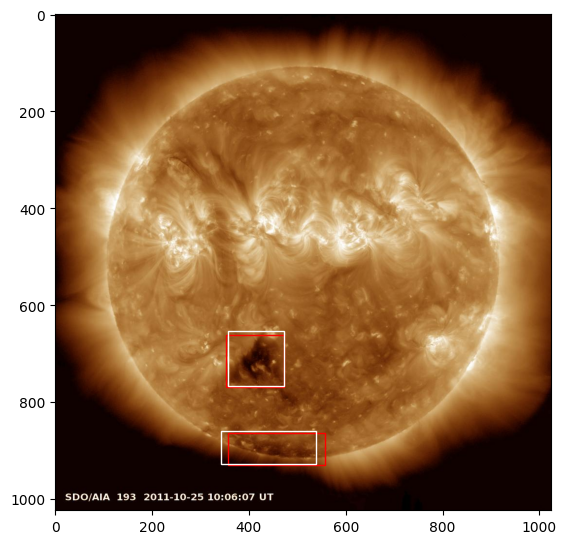

In [17]:
sample = df_valid_set.iloc[10]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "predict", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

## 제출 파일 생성

### 테스트 데이터 예측

In [34]:
!yolo predict model={os.path.join(RESULT_PATH, 'sun/weights/best.pt')} source={os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR)} conf=0.423 save=True save_txt=True save_conf=True exist_ok=True project={os.path.join(RESULT_PATH, 'test3')}

/home/elicer/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

image 64/6369 /mnt/elice/dataset/test/images/028fc5c670964a35b0c8a36eeafbc391.jpg: 640x640 2 coronal_holes, 8.5ms
image 65/6369 /mnt/elice/dataset/test/images/0295f3fafc1242c9ac5939358a15fad9.jpg: 640x640 3 coronal_holes, 8.6ms
image 66/6369 /mnt/elice/dataset/test/images/02a14e01c8244c5f990388e054c2c14c.jpg: 640x640 (no detections), 8.5ms
image 67/6369 /mnt/elice/dataset/test/images/02acc863e1cd415b87a49f95d5816ea7.jpg: 640x640 2 prominences, 8.5ms
image 68/6369 /mnt/elice/dataset/test/images/02af9c64a60342148a25445ab3f7a64a.jpg: 640x640 2 coronal_holes, 8.5ms
image 69/6369 /mnt/elice/dataset/test/images/02bebd133e684017a724b6e1b0e49baa.jpg: 640x640 1 coronal_hole, 8.6ms
image 70/6369 /mnt/elice/dataset/test/images/02ca7ca3d05844749e2ea25505dff11a.jpg: 640x640 1 prominence, 8.5ms
image 71/6369 /mnt/elice/dataset/test/images/02d1de8e41c54efe87a23a0f276d0471.jpg: 640x640 3 coronal_holes, 8.6ms
image 72/6369 /mnt/elice/dataset/test/images/02d2171495dc44b6bb623c79450e128f.jpg: 640x640 (no

image 138/6369 /mnt/elice/dataset/test/images/05e0cdd9fda9484e8ae089c3bd8f2b3b.jpg: 640x640 2 prominences, 8.6ms
image 139/6369 /mnt/elice/dataset/test/images/05e7d6121c9c47c5aed84a5d6ffdd7e9.jpg: 640x640 3 coronal_holes, 8.6ms
image 140/6369 /mnt/elice/dataset/test/images/05f5197f0c66482590c4bf075e3c9207.jpg: 640x640 6 sunspots, 8.7ms
image 141/6369 /mnt/elice/dataset/test/images/05f8d17aff8d4b3180e5ec6f0834914a.jpg: 640x640 2 prominences, 8.7ms
image 142/6369 /mnt/elice/dataset/test/images/05fbf8ea61d4494db3d36c6abbf82d1d.jpg: 640x640 1 sunspot, 8.7ms
image 143/6369 /mnt/elice/dataset/test/images/063080f91f2d412793431ad250f1e91f.jpg: 640x640 1 prominence, 8.7ms
image 144/6369 /mnt/elice/dataset/test/images/06387a9b764746668fc93a17b21d3c10.jpg: 640x640 (no detections), 8.9ms
image 145/6369 /mnt/elice/dataset/test/images/063997ef632c4d18878d79f03d63d594.jpg: 640x640 1 prominence, 8.8ms
image 146/6369 /mnt/elice/dataset/test/images/06450b7f6b1b46c8a03610dff4cc8358.jpg: 640x640 3 coronal

image 211/6369 /mnt/elice/dataset/test/images/08e238be396f485c906be14c7baefc6a.jpg: 640x640 2 coronal_holes, 8.5ms
image 212/6369 /mnt/elice/dataset/test/images/08e7d3b9ccf847c396ea79fc0fefa1fa.jpg: 640x640 3 coronal_holes, 8.5ms
image 213/6369 /mnt/elice/dataset/test/images/08ea1320c7424603b296261cc582791f.jpg: 640x640 2 prominences, 8.5ms
image 214/6369 /mnt/elice/dataset/test/images/08efe87963444b6d8e03465b222edb5d.jpg: 640x640 2 sunspots, 8.6ms
image 215/6369 /mnt/elice/dataset/test/images/0913d02a464e40f6832b434693ea60cf.jpg: 640x640 (no detections), 8.7ms
image 216/6369 /mnt/elice/dataset/test/images/0921db65c40f4a41b9ee7b881607eb77.jpg: 640x640 3 prominences, 8.9ms
image 217/6369 /mnt/elice/dataset/test/images/0934f732d6d24466a4f78598b17ef4b1.jpg: 640x640 2 coronal_holes, 8.7ms
image 218/6369 /mnt/elice/dataset/test/images/0943f83cd49944aba7ce29a169f6fbb7.jpg: 640x640 (no detections), 8.7ms
image 219/6369 /mnt/elice/dataset/test/images/09451f0ea4014a83968c522a97903547.jpg: 640x6

image 285/6369 /mnt/elice/dataset/test/images/0c3a9bc52c834eb2ab2258c0ed37f07d.jpg: 640x640 1 coronal_hole, 8.5ms
image 286/6369 /mnt/elice/dataset/test/images/0c3e4e886ac54e76a26471354e498235.jpg: 640x640 (no detections), 8.5ms
image 287/6369 /mnt/elice/dataset/test/images/0c58e31880264a22a06f16688f02abf7.jpg: 640x640 (no detections), 8.5ms
image 288/6369 /mnt/elice/dataset/test/images/0c60fc55bfc24166a9ac75d5c14d683f.jpg: 640x640 1 prominence, 8.6ms
image 289/6369 /mnt/elice/dataset/test/images/0c6263e454534fe994243746e9d937ea.jpg: 640x640 2 prominences, 8.7ms
image 290/6369 /mnt/elice/dataset/test/images/0c635f949dcc4312a4a8905d45c77c6f.jpg: 640x640 (no detections), 8.8ms
image 291/6369 /mnt/elice/dataset/test/images/0c664fb963df408c8c0117b2ac956c43.jpg: 640x640 1 sunspot, 8.9ms
image 292/6369 /mnt/elice/dataset/test/images/0c73f459e0744549968a03701e5cabe1.jpg: 640x640 1 prominence, 8.8ms
image 293/6369 /mnt/elice/dataset/test/images/0c7a4ff39fcb46418ffd0bd06f9cdc78.jpg: 640x640 1 c

image 359/6369 /mnt/elice/dataset/test/images/0f5865d747a846e69fe213a62fe43b1e.jpg: 640x640 5 sunspots, 8.8ms
image 360/6369 /mnt/elice/dataset/test/images/0f59b78c454b4b1996bf2c5d148e6244.jpg: 640x640 1 prominence, 9.0ms
image 361/6369 /mnt/elice/dataset/test/images/0f5ea25945724bcbbba5adfe8f3297fc.jpg: 640x640 2 coronal_holes, 9.2ms
image 362/6369 /mnt/elice/dataset/test/images/0f63f3fe25f74f80b80fe7a2d56def7a.jpg: 640x640 3 coronal_holes, 9.0ms
image 363/6369 /mnt/elice/dataset/test/images/0f6dcc72682f4b1ba3583f6454a1a965.jpg: 640x640 2 prominences, 9.1ms
image 364/6369 /mnt/elice/dataset/test/images/0f7531dd360348bb9cede89b5b8adde3.jpg: 640x640 8 sunspots, 9.2ms
image 365/6369 /mnt/elice/dataset/test/images/0f76928c8c0043b3b54465ace0a909d3.jpg: 640x640 (no detections), 9.3ms
image 366/6369 /mnt/elice/dataset/test/images/0f7d48b74d7d4a01b29d97c384d9344c.jpg: 640x640 1 prominence, 9.2ms
image 367/6369 /mnt/elice/dataset/test/images/0f7fa4d6ded247958d79517a2de7065c.jpg: 640x640 4 suns

image 432/6369 /mnt/elice/dataset/test/images/1239490dd9a34c528527c6572909e005.jpg: 640x640 4 coronal_holes, 8.5ms
image 433/6369 /mnt/elice/dataset/test/images/123c9fa1f4a34015a892819a9d585561.jpg: 640x640 2 sunspots, 8.6ms
image 434/6369 /mnt/elice/dataset/test/images/125471e3ad4f4ee8934b9a07901b54f8.jpg: 640x640 3 coronal_holes, 8.6ms
image 435/6369 /mnt/elice/dataset/test/images/127f8ed1636b4c0d81479221cd92f3bf.jpg: 640x640 2 coronal_holes, 8.6ms
image 436/6369 /mnt/elice/dataset/test/images/1281e93076f44e24a52f339010c7e8cf.jpg: 640x640 3 coronal_holes, 8.6ms
image 437/6369 /mnt/elice/dataset/test/images/128219212a54459c933fa8ae4b4b525f.jpg: 640x640 (no detections), 8.5ms
image 438/6369 /mnt/elice/dataset/test/images/129811329e264d6f984e5bc1ae4cea4b.jpg: 640x640 1 prominence, 8.5ms
image 439/6369 /mnt/elice/dataset/test/images/12a4c99c49b84719909adfc13a7eef9d.jpg: 640x640 (no detections), 8.6ms
image 440/6369 /mnt/elice/dataset/test/images/12b3eac1746f4a0dbd3f2642b98ec5c9.jpg: 640x

image 505/6369 /mnt/elice/dataset/test/images/15b232c27fde4fb68b5d640ebb965c22.jpg: 640x640 4 coronal_holes, 8.6ms
image 506/6369 /mnt/elice/dataset/test/images/15be6fbe69704b4ab9435a288d33d9b4.jpg: 640x640 1 coronal_hole, 8.5ms
image 507/6369 /mnt/elice/dataset/test/images/15bfcc9c9b6641d28914919504597783.jpg: 640x640 4 prominences, 8.5ms
image 508/6369 /mnt/elice/dataset/test/images/15d0b3eb73f84326acf680e20c4d88d0.jpg: 640x640 3 coronal_holes, 8.5ms
image 509/6369 /mnt/elice/dataset/test/images/15f60f789a394b30921eb7286459d177.jpg: 640x640 3 coronal_holes, 8.5ms
image 510/6369 /mnt/elice/dataset/test/images/15fd001d139a4294a19c857c626c777f.jpg: 640x640 1 prominence, 8.5ms
image 511/6369 /mnt/elice/dataset/test/images/160df51ed0e94173bcf13127a496c09e.jpg: 640x640 2 sunspots, 8.5ms
image 512/6369 /mnt/elice/dataset/test/images/161136287b9b4d7e9647510cba578815.jpg: 640x640 5 sunspots, 8.4ms
image 513/6369 /mnt/elice/dataset/test/images/16177a4227084072a2ae2b830bfa579e.jpg: 640x640 (no 

image 579/6369 /mnt/elice/dataset/test/images/18280794c55c4b738d3dfacf3fd41492.jpg: 640x640 3 sunspots, 9.3ms
image 580/6369 /mnt/elice/dataset/test/images/18297d5fe5e447bf931e85ae31b32957.jpg: 640x640 2 coronal_holes, 8.7ms
image 581/6369 /mnt/elice/dataset/test/images/18303270f0284ad9a995e3e2216c7f58.jpg: 640x640 1 coronal_hole, 8.6ms
image 582/6369 /mnt/elice/dataset/test/images/1830b437f9fd4f49b5fc9de28f3ec92f.jpg: 640x640 2 coronal_holes, 8.6ms
image 583/6369 /mnt/elice/dataset/test/images/18342ac7e40f4dc69a4195f349f06aa3.jpg: 640x640 3 sunspots, 8.6ms
image 584/6369 /mnt/elice/dataset/test/images/183465af6ab44fd5a0a2f971ad424f44.jpg: 640x640 1 prominence, 8.6ms
image 585/6369 /mnt/elice/dataset/test/images/18352962444948a5ab7ed26fb385efb8.jpg: 640x640 (no detections), 8.6ms
image 586/6369 /mnt/elice/dataset/test/images/183d447b235c4afaa91a8208e9d382bd.jpg: 640x640 4 sunspots, 8.6ms
image 587/6369 /mnt/elice/dataset/test/images/18403575963e4b2ebf602ff2feb6d3fa.jpg: 640x640 1 coron

image 653/6369 /mnt/elice/dataset/test/images/1b30babfcb264fc489e402450c04afe4.jpg: 640x640 3 coronal_holes, 8.8ms
image 654/6369 /mnt/elice/dataset/test/images/1b45ee8eaa9c43649f138e31bd572090.jpg: 640x640 3 prominences, 8.7ms
image 655/6369 /mnt/elice/dataset/test/images/1b4daa04b074404d9d44223330328275.jpg: 640x640 4 sunspots, 8.7ms
image 656/6369 /mnt/elice/dataset/test/images/1b50664eab7a41da93cb628ef44390d6.jpg: 640x640 3 coronal_holes, 8.7ms
image 657/6369 /mnt/elice/dataset/test/images/1b56f0dc7ba844d99f8c63cf5da44ddb.jpg: 640x640 1 coronal_hole, 8.7ms
image 658/6369 /mnt/elice/dataset/test/images/1b67accd3a2b4cf0a1f65ac87bc832b9.jpg: 640x640 (no detections), 8.7ms
image 659/6369 /mnt/elice/dataset/test/images/1b7d4d8147aa4a82944d407b4cf63afc.jpg: 640x640 6 sunspots, 8.8ms
image 660/6369 /mnt/elice/dataset/test/images/1b851a81ee1842359acc2a46bb0bb5c8.jpg: 640x640 1 prominence, 8.4ms
image 661/6369 /mnt/elice/dataset/test/images/1b86c39d2f4742d6835dfd863df9a0bf.jpg: 640x640 (no 

image 727/6369 /mnt/elice/dataset/test/images/1e78cce798a5467f990b3a38aadf62ee.jpg: 640x640 1 sunspot, 8.6ms
image 728/6369 /mnt/elice/dataset/test/images/1e85e5c8bd3540b49de264d98e714d6f.jpg: 640x640 3 coronal_holes, 8.4ms
image 729/6369 /mnt/elice/dataset/test/images/1ea19e29154c4567b2248b293175459a.jpg: 640x640 4 sunspots, 8.3ms
image 730/6369 /mnt/elice/dataset/test/images/1ea6ae93465847d0b4b6dda8f7db8075.jpg: 640x640 3 sunspots, 8.3ms
image 731/6369 /mnt/elice/dataset/test/images/1eb78d11f1334cc5b659388502ed4912.jpg: 640x640 1 prominence, 8.2ms
image 732/6369 /mnt/elice/dataset/test/images/1ebae113ad65481f90c93829cd5cdd12.jpg: 640x640 3 sunspots, 8.2ms
image 733/6369 /mnt/elice/dataset/test/images/1ebc56c58993425ca600db5d8489afd6.jpg: 640x640 3 sunspots, 8.3ms
image 734/6369 /mnt/elice/dataset/test/images/1ebf1955b67d4f94b6434358576a0a9b.jpg: 640x640 2 prominences, 8.2ms
image 735/6369 /mnt/elice/dataset/test/images/1eeb2ffd0981446fabb0ffa332b2fdf0.jpg: 640x640 3 prominences, 8.2m

image 801/6369 /mnt/elice/dataset/test/images/21a344c7317e44daa6345d9de235c77b.jpg: 640x640 1 coronal_hole, 8.5ms
image 802/6369 /mnt/elice/dataset/test/images/21aa68fc5b4c48dd81f02da01ffcd646.jpg: 640x640 4 sunspots, 8.6ms
image 803/6369 /mnt/elice/dataset/test/images/21ad3e22dd5b4e8e8f743ab4b129cb34.jpg: 640x640 6 sunspots, 8.4ms
image 804/6369 /mnt/elice/dataset/test/images/21c82264ebcc44beb31b12b32c8e50ab.jpg: 640x640 4 prominences, 8.3ms
image 805/6369 /mnt/elice/dataset/test/images/21cd17fd12b94c39b937620b39d440c3.jpg: 640x640 3 coronal_holes, 9.1ms
image 806/6369 /mnt/elice/dataset/test/images/21d1f374f0754dd791318bb358cd1131.jpg: 640x640 4 sunspots, 8.2ms
image 807/6369 /mnt/elice/dataset/test/images/21d48139d120491aab8f911a11cefc9c.jpg: 640x640 1 prominence, 8.3ms
image 808/6369 /mnt/elice/dataset/test/images/21f1d1c06e274629b5174b451e83365b.jpg: 640x640 6 sunspots, 8.3ms
image 809/6369 /mnt/elice/dataset/test/images/21ffa9337a8840b09ff09a4da4c4e378.jpg: 640x640 1 prominence, 

image 874/6369 /mnt/elice/dataset/test/images/24f11d09f79d40c8aacd88613908cec5.jpg: 640x640 3 prominences, 8.5ms
image 875/6369 /mnt/elice/dataset/test/images/250106fbb60141168f3d39b26e737280.jpg: 640x640 3 sunspots, 8.5ms
image 876/6369 /mnt/elice/dataset/test/images/2505b9353e2e48c69188f2c23ffaff43.jpg: 640x640 5 sunspots, 8.5ms
image 877/6369 /mnt/elice/dataset/test/images/251c416adea849ce838b5f7ba67b3236.jpg: 640x640 2 sunspots, 8.5ms
image 878/6369 /mnt/elice/dataset/test/images/252594294a1845198a41b62fe59241ba.jpg: 640x640 1 prominence, 8.5ms
image 879/6369 /mnt/elice/dataset/test/images/252a01e912874a0ea18fe27996b12f3b.jpg: 640x640 2 coronal_holes, 8.4ms
image 880/6369 /mnt/elice/dataset/test/images/2533646a65a44cd5b4a19e32ec8784ec.jpg: 640x640 4 prominences, 8.5ms
image 881/6369 /mnt/elice/dataset/test/images/2536024acfb54c93b1876a47b9491b64.jpg: 640x640 4 coronal_holes, 8.4ms
image 882/6369 /mnt/elice/dataset/test/images/254b86bfb28743b2a059aa8f4c4e761d.jpg: 640x640 1 coronal_

image 948/6369 /mnt/elice/dataset/test/images/27fabb893852489ba8742b519eeebe1a.jpg: 640x640 1 prominence, 8.7ms
image 949/6369 /mnt/elice/dataset/test/images/27fccb0f637e465ea805627add3fea7b.jpg: 640x640 (no detections), 8.8ms
image 950/6369 /mnt/elice/dataset/test/images/28045cd94c584ef5b63d5bee401572b0.jpg: 640x640 3 coronal_holes, 8.6ms
image 951/6369 /mnt/elice/dataset/test/images/28180aad9df24496b4d1314a7ec02051.jpg: 640x640 (no detections), 8.5ms
image 952/6369 /mnt/elice/dataset/test/images/28287a1c2cfd4857af5f3b8065e94edc.jpg: 640x640 2 sunspots, 8.7ms
image 953/6369 /mnt/elice/dataset/test/images/282a70187a054525afec1abd9fa2072d.jpg: 640x640 4 coronal_holes, 8.8ms
image 954/6369 /mnt/elice/dataset/test/images/282f7d72ffd3495492a73084c7cc2d08.jpg: 640x640 1 prominence, 8.7ms
image 955/6369 /mnt/elice/dataset/test/images/283fef0a3ed942f8aa208bd69b417b60.jpg: 640x640 2 coronal_holes, 8.4ms
image 956/6369 /mnt/elice/dataset/test/images/28432705c4474099967a0d27d3be5566.jpg: 640x640

image 1022/6369 /mnt/elice/dataset/test/images/2bc03a456311431b957b7fcc5138b3ac.jpg: 640x640 (no detections), 8.1ms
image 1023/6369 /mnt/elice/dataset/test/images/2bc6f72c7c1949088c8726f805df9844.jpg: 640x640 (no detections), 8.2ms
image 1024/6369 /mnt/elice/dataset/test/images/2be66b82c1e5423a85b99ec5ad09b508.jpg: 640x640 (no detections), 8.1ms
image 1025/6369 /mnt/elice/dataset/test/images/2be86ca00cfd418baf5f300f3af143b6.jpg: 640x640 3 coronal_holes, 8.1ms
image 1026/6369 /mnt/elice/dataset/test/images/2beab0dc2e9041e1ad608b514c20eb84.jpg: 640x640 4 prominences, 8.2ms
image 1027/6369 /mnt/elice/dataset/test/images/2c12c3f399404631b678b0545802ed36.jpg: 640x640 4 sunspots, 8.2ms
image 1028/6369 /mnt/elice/dataset/test/images/2c180f57ba764b84933ee75c02b45aa1.jpg: 640x640 2 prominences, 8.2ms
image 1029/6369 /mnt/elice/dataset/test/images/2c277723c3a3453da406ace08be58168.jpg: 640x640 7 sunspots, 8.2ms
image 1030/6369 /mnt/elice/dataset/test/images/2c286f4ead174ed0a0c90c352c00bdee.jpg: 6

image 1095/6369 /mnt/elice/dataset/test/images/2e4e171517444dc5811863a202eeada4.jpg: 640x640 1 coronal_hole, 8.6ms
image 1096/6369 /mnt/elice/dataset/test/images/2e6241395b644a809f52bd2203c435c1.jpg: 640x640 1 prominence, 8.5ms
image 1097/6369 /mnt/elice/dataset/test/images/2e69d55160734ae49603cf1b589398a9.jpg: 640x640 (no detections), 8.8ms
image 1098/6369 /mnt/elice/dataset/test/images/2e732917d80f4176a9aa2822d427d456.jpg: 640x640 3 sunspots, 8.6ms
image 1099/6369 /mnt/elice/dataset/test/images/2e7e3a098f32426bad8c5608a4060cda.jpg: 640x640 (no detections), 8.4ms
image 1100/6369 /mnt/elice/dataset/test/images/2e8e809d90dd43bd892569076a869e70.jpg: 640x640 2 coronal_holes, 8.3ms
image 1101/6369 /mnt/elice/dataset/test/images/2e9025a09ea74c3aa3b3953c0f3b1945.jpg: 640x640 (no detections), 8.2ms
image 1102/6369 /mnt/elice/dataset/test/images/2e958223c190411891e71cdeaa7b1d23.jpg: 640x640 5 prominences, 8.2ms
image 1103/6369 /mnt/elice/dataset/test/images/2e998e62af9d4e7384e17473a93e0a86.jpg

image 1168/6369 /mnt/elice/dataset/test/images/311ce898c14f4bd2aedaf2613fa00c61.jpg: 640x640 1 coronal_hole, 8.5ms
image 1169/6369 /mnt/elice/dataset/test/images/3127538fa4ee4c8fbe69be740c59af7e.jpg: 640x640 2 coronal_holes, 8.4ms
image 1170/6369 /mnt/elice/dataset/test/images/312a25b9082241cd8eba1d4fe13f5686.jpg: 640x640 2 sunspots, 8.5ms
image 1171/6369 /mnt/elice/dataset/test/images/312cc98ca03147fa8125b5527955b27a.jpg: 640x640 2 coronal_holes, 8.5ms
image 1172/6369 /mnt/elice/dataset/test/images/3134ef8ad9fd461abcf5053bea2b080e.jpg: 640x640 5 sunspots, 8.5ms
image 1173/6369 /mnt/elice/dataset/test/images/313e89f244644b148fea75647d17d3ca.jpg: 640x640 2 prominences, 8.5ms
image 1174/6369 /mnt/elice/dataset/test/images/3155f5adc937475a89985d17f24b919f.jpg: 640x640 1 prominence, 8.5ms
image 1175/6369 /mnt/elice/dataset/test/images/316693b2a203435fa13ce3e618cb6056.jpg: 640x640 3 sunspots, 8.6ms
image 1176/6369 /mnt/elice/dataset/test/images/3179bf62014e4f35967f5c28c849c873.jpg: 640x640 

image 1241/6369 /mnt/elice/dataset/test/images/33b60c00676d40068b036198838da2fa.jpg: 640x640 2 coronal_holes, 8.3ms
image 1242/6369 /mnt/elice/dataset/test/images/33b678ee590e4ddb97a8bdd233402d04.jpg: 640x640 3 coronal_holes, 8.2ms
image 1243/6369 /mnt/elice/dataset/test/images/33ca1cb56af6459d915eed116e82353a.jpg: 640x640 6 sunspots, 8.2ms
image 1244/6369 /mnt/elice/dataset/test/images/33d3131f38a242bbaa0dd6aca9f0736b.jpg: 640x640 3 coronal_holes, 8.2ms
image 1245/6369 /mnt/elice/dataset/test/images/33d7f70edd7e4f93844cd00e0ce2daff.jpg: 640x640 4 sunspots, 8.1ms
image 1246/6369 /mnt/elice/dataset/test/images/33fca0e19f0f497298bf06f092279978.jpg: 640x640 2 prominences, 8.2ms
image 1247/6369 /mnt/elice/dataset/test/images/34078dae9980433fb4f9f646f9555ca1.jpg: 640x640 1 sunspot, 8.1ms
image 1248/6369 /mnt/elice/dataset/test/images/340a6ac5546146748ff2054f1899778a.jpg: 640x640 2 prominences, 8.4ms
image 1249/6369 /mnt/elice/dataset/test/images/340caaf4e0a94899900bfcb21f06fd71.jpg: 640x640

image 1314/6369 /mnt/elice/dataset/test/images/365a770525584d698221d1d14549f9e4.jpg: 640x640 6 sunspots, 8.5ms
image 1315/6369 /mnt/elice/dataset/test/images/367389f7755a42adad0fc745454b435f.jpg: 640x640 1 sunspot, 8.4ms
image 1316/6369 /mnt/elice/dataset/test/images/3674b3e2a26c4fefb28b36892bd983ef.jpg: 640x640 1 prominence, 8.3ms
image 1317/6369 /mnt/elice/dataset/test/images/367d0fe917b64b88bcb79da477fd3ab9.jpg: 640x640 1 coronal_hole, 8.3ms
image 1318/6369 /mnt/elice/dataset/test/images/36889e54a8a8464784eac8bd0dc8095f.jpg: 640x640 (no detections), 8.3ms
image 1319/6369 /mnt/elice/dataset/test/images/368daeda295d468883b8196ac1c0cf02.jpg: 640x640 2 prominences, 8.3ms
image 1320/6369 /mnt/elice/dataset/test/images/369be5f2f25b4542ad1b42ad90c36ccb.jpg: 640x640 4 coronal_holes, 8.2ms
image 1321/6369 /mnt/elice/dataset/test/images/369c2babebef49e2b2b63e459c509f65.jpg: 640x640 5 sunspots, 8.4ms
image 1322/6369 /mnt/elice/dataset/test/images/36a166ddea414bada15446aa5910b507.jpg: 640x640 5

image 1387/6369 /mnt/elice/dataset/test/images/39056db0d30642f48dd589a229165233.jpg: 640x640 1 sunspot, 8.5ms
image 1388/6369 /mnt/elice/dataset/test/images/3916bb3d01f94a81a547d65749a33193.jpg: 640x640 3 sunspots, 8.5ms
image 1389/6369 /mnt/elice/dataset/test/images/3918ee477e0744acba7a202b36da8909.jpg: 640x640 10 sunspots, 8.5ms
image 1390/6369 /mnt/elice/dataset/test/images/391d019983db410e919e5f5acdaa1a1f.jpg: 640x640 3 sunspots, 8.5ms
image 1391/6369 /mnt/elice/dataset/test/images/3936cf140ffe41159fac67780262176b.jpg: 640x640 4 sunspots, 8.4ms
image 1392/6369 /mnt/elice/dataset/test/images/393e8ea91616426f85bdc2284de5167e.jpg: 640x640 1 prominence, 8.4ms
image 1393/6369 /mnt/elice/dataset/test/images/3943395680734bb2ba6dd89f4c3a359d.jpg: 640x640 (no detections), 8.6ms
image 1394/6369 /mnt/elice/dataset/test/images/39439879e2ea4c3babeb03df323afd3f.jpg: 640x640 3 prominences, 8.6ms
image 1395/6369 /mnt/elice/dataset/test/images/394dcd51bb204ac4acc565581e99a6c2.jpg: 640x640 4 sunspot

image 1459/6369 /mnt/elice/dataset/test/images/3bdc4b16525a4900967a272f0bc9d9a4.jpg: 640x640 3 sunspots, 8.7ms
image 1460/6369 /mnt/elice/dataset/test/images/3be0cb1c46014ffe8e1527757f16025a.jpg: 640x640 2 coronal_holes, 8.8ms
image 1461/6369 /mnt/elice/dataset/test/images/3be483b4bfc74a68850e2b17de7d10c1.jpg: 640x640 (no detections), 8.6ms
image 1462/6369 /mnt/elice/dataset/test/images/3beb8e22a01546158d3b3f1a37c124db.jpg: 640x640 8 sunspots, 10.5ms
image 1463/6369 /mnt/elice/dataset/test/images/3bf08834475047ce91dd59e51990d89b.jpg: 640x640 1 prominence, 8.7ms
image 1464/6369 /mnt/elice/dataset/test/images/3bf54efe266242499136218f95b7b827.jpg: 640x640 3 sunspots, 8.6ms
image 1465/6369 /mnt/elice/dataset/test/images/3bf5a2aabed64bb2a42828841a6f295e.jpg: 640x640 7 sunspots, 8.6ms
image 1466/6369 /mnt/elice/dataset/test/images/3bfa44ece5be4f56b71219590d350c1f.jpg: 640x640 1 prominence, 8.6ms
image 1467/6369 /mnt/elice/dataset/test/images/3bfcdbd1cc3e43f592aaee27efb5fc25.jpg: 640x640 4 su

image 1533/6369 /mnt/elice/dataset/test/images/3e51accbba4846e48328de256b86e701.jpg: 640x640 (no detections), 8.5ms
image 1534/6369 /mnt/elice/dataset/test/images/3e6977c379424f73890f06aa3cef3eb7.jpg: 640x640 3 sunspots, 8.6ms
image 1535/6369 /mnt/elice/dataset/test/images/3e88997d90fb403daeef8d1c2cf8e935.jpg: 640x640 6 sunspots, 8.6ms
image 1536/6369 /mnt/elice/dataset/test/images/3e900056acb44087a07dfe3619da58a6.jpg: 640x640 1 coronal_hole, 8.5ms
image 1537/6369 /mnt/elice/dataset/test/images/3e95c619d94b4c5096a04ee41f3c7b38.jpg: 640x640 2 coronal_holes, 8.5ms
image 1538/6369 /mnt/elice/dataset/test/images/3e997b98a1db4423809c76e1c2f20368.jpg: 640x640 2 prominences, 8.5ms
image 1539/6369 /mnt/elice/dataset/test/images/3e9f664b24d64116915491f3e5427e9c.jpg: 640x640 3 coronal_holes, 8.5ms
image 1540/6369 /mnt/elice/dataset/test/images/3eafea51824347eb9bd8c6b503b7a8f3.jpg: 640x640 1 prominence, 8.6ms
image 1541/6369 /mnt/elice/dataset/test/images/3ed1ac6219a6461ca9c85ecd7f877d2e.jpg: 640

image 1606/6369 /mnt/elice/dataset/test/images/412497f8187d4607b5c06a73b32f5c25.jpg: 640x640 3 prominences, 8.7ms
image 1607/6369 /mnt/elice/dataset/test/images/4126ef7d9dec4af3b0ddeee123ba1fa9.jpg: 640x640 1 prominence, 8.7ms
image 1608/6369 /mnt/elice/dataset/test/images/412a4aa1f6214998a3d5d40d578b00d7.jpg: 640x640 1 sunspot, 8.6ms
image 1609/6369 /mnt/elice/dataset/test/images/41328831972b452fb44bdc654c3ed96e.jpg: 640x640 2 prominences, 8.6ms
image 1610/6369 /mnt/elice/dataset/test/images/4139110e7fef4c6a92a2e931be2b7140.jpg: 640x640 (no detections), 8.6ms
image 1611/6369 /mnt/elice/dataset/test/images/413be63de1f84f9c802685be52bab8c3.jpg: 640x640 4 coronal_holes, 8.7ms
image 1612/6369 /mnt/elice/dataset/test/images/41480e2db3634224aa5056b87393ebb5.jpg: 640x640 1 coronal_hole, 8.5ms
image 1613/6369 /mnt/elice/dataset/test/images/414a357cda6140b7a11ab447a140fbed.jpg: 640x640 2 coronal_holes, 8.4ms
image 1614/6369 /mnt/elice/dataset/test/images/414f667680504652b10e078c4139d3c7.jpg: 6

image 1678/6369 /mnt/elice/dataset/test/images/443c8481586e49dfa9aa4127b124796a.jpg: 640x640 6 sunspots, 8.6ms
image 1679/6369 /mnt/elice/dataset/test/images/4475d44b72e6440699c586813fd1cc1e.jpg: 640x640 1 prominence, 8.6ms
image 1680/6369 /mnt/elice/dataset/test/images/447715ed50c44ca5a4d1799fa188e653.jpg: 640x640 4 coronal_holes, 8.6ms
image 1681/6369 /mnt/elice/dataset/test/images/448069d91bea425c9207f0295f8666a9.jpg: 640x640 3 sunspots, 8.6ms
image 1682/6369 /mnt/elice/dataset/test/images/448e7e667f2c4dc1b008c62f9b45b95d.jpg: 640x640 8 sunspots, 8.6ms
image 1683/6369 /mnt/elice/dataset/test/images/448f11a046ad47cf8bbe28e9d314e0a8.jpg: 640x640 2 coronal_holes, 8.6ms
image 1684/6369 /mnt/elice/dataset/test/images/44947933c3d3403b8b94ffcb7b727161.jpg: 640x640 6 sunspots, 8.6ms
image 1685/6369 /mnt/elice/dataset/test/images/4495e9eb62bd4d24b8b5797a08907671.jpg: 640x640 2 coronal_holes, 8.6ms
image 1686/6369 /mnt/elice/dataset/test/images/44a02345d3f444fb89d18cc57a591c9e.jpg: 640x640 2 

image 1750/6369 /mnt/elice/dataset/test/images/47957b6a29f24141a7a5064108ab633e.jpg: 640x640 10 sunspots, 8.7ms
image 1751/6369 /mnt/elice/dataset/test/images/479d72c7350d4d718cb6b10749d44e62.jpg: 640x640 4 sunspots, 8.7ms
image 1752/6369 /mnt/elice/dataset/test/images/47a389992cd8468aa7bae2c9ca8361d3.jpg: 640x640 2 coronal_holes, 8.7ms
image 1753/6369 /mnt/elice/dataset/test/images/47a63d20dc1b4450acb9e1e02f8f8ff1.jpg: 640x640 3 coronal_holes, 8.6ms
image 1754/6369 /mnt/elice/dataset/test/images/47a8d0227aad4a9eaba3991a456525f0.jpg: 640x640 2 coronal_holes, 8.7ms
image 1755/6369 /mnt/elice/dataset/test/images/47b1cba3a6b441b8acf67c9a5f7ba5fe.jpg: 640x640 2 sunspots, 8.7ms
image 1756/6369 /mnt/elice/dataset/test/images/47b58771e3b64a77b0d4454cfd456e3b.jpg: 640x640 1 coronal_hole, 8.7ms
image 1757/6369 /mnt/elice/dataset/test/images/47bc25d002a649d68959e4f0f12ad59e.jpg: 640x640 2 prominences, 8.7ms
image 1758/6369 /mnt/elice/dataset/test/images/47c87ae846f34a6c9d92cfaf7f970e9b.jpg: 640x

image 1823/6369 /mnt/elice/dataset/test/images/4a81f373fdcc4d9b8ad41881f1477fba.jpg: 640x640 1 prominence, 8.7ms
image 1824/6369 /mnt/elice/dataset/test/images/4a82cfe0141e4c9c8b6ce86d98680e38.jpg: 640x640 1 sunspot, 8.6ms
image 1825/6369 /mnt/elice/dataset/test/images/4a96e05a64ab4753a99c0c4029f78200.jpg: 640x640 1 prominence, 8.7ms
image 1826/6369 /mnt/elice/dataset/test/images/4a9f27f3a6ce4185a0a4df97d608b862.jpg: 640x640 3 sunspots, 8.8ms
image 1827/6369 /mnt/elice/dataset/test/images/4aac77d959da4217ad19d078969753a5.jpg: 640x640 3 sunspots, 8.7ms
image 1828/6369 /mnt/elice/dataset/test/images/4ac76676b6be4711b7c0405da3062e89.jpg: 640x640 1 coronal_hole, 8.7ms
image 1829/6369 /mnt/elice/dataset/test/images/4acef27dcdca4da9b1eaa9159a4088cb.jpg: 640x640 2 coronal_holes, 8.7ms
image 1830/6369 /mnt/elice/dataset/test/images/4ad27f2554bd4766bb8d4c6636f220fa.jpg: 640x640 (no detections), 8.8ms
image 1831/6369 /mnt/elice/dataset/test/images/4ad997c95aab449aa460918e529d7ea0.jpg: 640x640 1 

image 1897/6369 /mnt/elice/dataset/test/images/4dd4494ba5b147c680ead3c9744c8dfc.jpg: 640x640 3 sunspots, 8.7ms
image 1898/6369 /mnt/elice/dataset/test/images/4ddeba6abead453a9e93122d2f35d656.jpg: 640x640 5 sunspots, 8.7ms
image 1899/6369 /mnt/elice/dataset/test/images/4de3e985cfa44912ab63b5a4cbf00310.jpg: 640x640 1 coronal_hole, 8.6ms
image 1900/6369 /mnt/elice/dataset/test/images/4de55e865486417a8a293aff8033e3c7.jpg: 640x640 1 sunspot, 8.8ms
image 1901/6369 /mnt/elice/dataset/test/images/4de7c5ab97594a3eb2a1f30b75d94690.jpg: 640x640 1 coronal_hole, 8.6ms
image 1902/6369 /mnt/elice/dataset/test/images/4df45eed9a5f4a548806b119ff4d4f2f.jpg: 640x640 2 prominences, 8.6ms
image 1903/6369 /mnt/elice/dataset/test/images/4df5892768f64495af6eb10a64c3b61b.jpg: 640x640 2 coronal_holes, 8.7ms
image 1904/6369 /mnt/elice/dataset/test/images/4df7a4f5076f43d5ae310431ca15f63f.jpg: 640x640 2 sunspots, 8.7ms
image 1905/6369 /mnt/elice/dataset/test/images/4dfc68c731534f6ca366c92028abb7ec.jpg: 640x640 2 co

image 1970/6369 /mnt/elice/dataset/test/images/507f3f94e63b4e0bb812a56e9337f039.jpg: 640x640 3 coronal_holes, 8.6ms
image 1971/6369 /mnt/elice/dataset/test/images/5083fe8e14394aca930dab3242a5321a.jpg: 640x640 1 sunspot, 8.7ms
image 1972/6369 /mnt/elice/dataset/test/images/50841c6df5fa4b66ab2cfac5a1ab27cb.jpg: 640x640 2 prominences, 8.7ms
image 1973/6369 /mnt/elice/dataset/test/images/508609b89c8b4e77824282c6b4c54449.jpg: 640x640 2 prominences, 8.6ms
image 1974/6369 /mnt/elice/dataset/test/images/50a7af2147fd4ae490b87912640a9a94.jpg: 640x640 4 coronal_holes, 8.8ms
image 1975/6369 /mnt/elice/dataset/test/images/50aedad5d2df4d949cf98ca5d54e8fb6.jpg: 640x640 1 prominence, 8.8ms
image 1976/6369 /mnt/elice/dataset/test/images/50b5848bd9e042bdb22cdb572a1aee95.jpg: 640x640 3 coronal_holes, 8.7ms
image 1977/6369 /mnt/elice/dataset/test/images/50b68ea1cf1a47fca8b8e1a13b29dbe5.jpg: 640x640 2 coronal_holes, 8.7ms
image 1978/6369 /mnt/elice/dataset/test/images/50cec4015a4c4cb98c5a260da0bbace9.jpg: 

image 2042/6369 /mnt/elice/dataset/test/images/53688a6143984482b648f160bdb9bafc.jpg: 640x640 2 prominences, 8.7ms
image 2043/6369 /mnt/elice/dataset/test/images/536d9da68a014802889dcc2292b2dfb0.jpg: 640x640 3 sunspots, 8.9ms
image 2044/6369 /mnt/elice/dataset/test/images/537f70232aac4fabb844d9059fea67e7.jpg: 640x640 3 coronal_holes, 8.8ms
image 2045/6369 /mnt/elice/dataset/test/images/538d2d9fe4cd4ad19699dfd203a76714.jpg: 640x640 3 sunspots, 8.8ms
image 2046/6369 /mnt/elice/dataset/test/images/539a59d2b2244e069ef6e3b9417a6e8f.jpg: 640x640 6 sunspots, 8.8ms
image 2047/6369 /mnt/elice/dataset/test/images/53a9abdfdaf8413b9b8e921bf05563d0.jpg: 640x640 (no detections), 8.8ms
image 2048/6369 /mnt/elice/dataset/test/images/53b54848e3044acfb8e55ad3791ca370.jpg: 640x640 5 sunspots, 8.8ms
image 2049/6369 /mnt/elice/dataset/test/images/53be6b7e59e848c6a2cb64ec0d4b8960.jpg: 640x640 (no detections), 8.9ms
image 2050/6369 /mnt/elice/dataset/test/images/53d0849c412949ddb5a9bf403a1d8147.jpg: 640x640 2

image 2115/6369 /mnt/elice/dataset/test/images/5683e1762e364bb2bd41b6f2b475eb7a.jpg: 640x640 4 sunspots, 8.8ms
image 2116/6369 /mnt/elice/dataset/test/images/569106196bbd4a91b34baf74ce71f562.jpg: 640x640 2 coronal_holes, 8.8ms
image 2117/6369 /mnt/elice/dataset/test/images/56922a934f05402a84e8990dbd9d2627.jpg: 640x640 2 sunspots, 8.9ms
image 2118/6369 /mnt/elice/dataset/test/images/569930d7c968485888c4031aabe9d06c.jpg: 640x640 4 sunspots, 8.8ms
image 2119/6369 /mnt/elice/dataset/test/images/56cca20aedc749a599969a0c2d931047.jpg: 640x640 2 coronal_holes, 8.7ms
image 2120/6369 /mnt/elice/dataset/test/images/56ce4da01da0431fbc71b45f6c9a399a.jpg: 640x640 1 prominence, 8.8ms
image 2121/6369 /mnt/elice/dataset/test/images/56d0adbaca874826a9e57bfa7ea30313.jpg: 640x640 3 sunspots, 8.8ms
image 2122/6369 /mnt/elice/dataset/test/images/56d43df983764724b7b0df963892894d.jpg: 640x640 3 sunspots, 8.8ms
image 2123/6369 /mnt/elice/dataset/test/images/56d58d9b5e2549a59da356bbc7e109fc.jpg: 640x640 2 coron

image 2188/6369 /mnt/elice/dataset/test/images/5978029b84cf47789ed8d6d0609d7e13.jpg: 640x640 1 prominence, 8.7ms
image 2189/6369 /mnt/elice/dataset/test/images/59788e0df35e483ba53e89d23d74bb52.jpg: 640x640 (no detections), 8.7ms
image 2190/6369 /mnt/elice/dataset/test/images/597b7a57314a44f68e6853147a021beb.jpg: 640x640 4 sunspots, 8.7ms
image 2191/6369 /mnt/elice/dataset/test/images/597bd9929d4c4f18bbeaa0e3edd493a7.jpg: 640x640 2 coronal_holes, 8.8ms
image 2192/6369 /mnt/elice/dataset/test/images/59881dd10153491690d63284a4946ad2.jpg: 640x640 (no detections), 8.7ms
image 2193/6369 /mnt/elice/dataset/test/images/5991636e1f024e1dad9c8a9be3300db1.jpg: 640x640 1 prominence, 8.6ms
image 2194/6369 /mnt/elice/dataset/test/images/5994a054c68048d69636185547d82191.jpg: 640x640 1 coronal_hole, 8.6ms
image 2195/6369 /mnt/elice/dataset/test/images/5995ea87eed64fe8b8c546720c709d1b.jpg: 640x640 1 coronal_hole, 8.6ms
image 2196/6369 /mnt/elice/dataset/test/images/59a01b3828674b5aba150018eef55f79.jpg: 

image 2261/6369 /mnt/elice/dataset/test/images/5c1c2917453d4796ab8776672f83aed8.jpg: 640x640 1 coronal_hole, 8.8ms
image 2262/6369 /mnt/elice/dataset/test/images/5c3b8e8e4aba428cbe13043af90681e5.jpg: 640x640 1 prominence, 8.8ms
image 2263/6369 /mnt/elice/dataset/test/images/5c3ed1edca94473ca5b6626a575a6450.jpg: 640x640 1 coronal_hole, 8.7ms
image 2264/6369 /mnt/elice/dataset/test/images/5c4c3eb7dee34a649d9cb4b272346169.jpg: 640x640 4 sunspots, 8.6ms
image 2265/6369 /mnt/elice/dataset/test/images/5c4fd8e5162f4799a8f83b3502b82a5e.jpg: 640x640 (no detections), 8.5ms
image 2266/6369 /mnt/elice/dataset/test/images/5c5975f12f3c4800a69086cf96953fd2.jpg: 640x640 2 coronal_holes, 8.6ms
image 2267/6369 /mnt/elice/dataset/test/images/5c67e86fceb345998dd011fc7c5b7192.jpg: 640x640 (no detections), 8.5ms
image 2268/6369 /mnt/elice/dataset/test/images/5c84d4f103984198a9216113b3ae7eef.jpg: 640x640 3 coronal_holes, 8.5ms
image 2269/6369 /mnt/elice/dataset/test/images/5c88389f97ab4a1fa9fbe112591b7c66.jp

image 2333/6369 /mnt/elice/dataset/test/images/5f53f89220ae4f47a2a573ac455501cf.jpg: 640x640 2 prominences, 8.7ms
image 2334/6369 /mnt/elice/dataset/test/images/5f575613b32c42ffa03ee89182e624e2.jpg: 640x640 2 coronal_holes, 8.8ms
image 2335/6369 /mnt/elice/dataset/test/images/5f757d07053549cab2a05e6b439f7a10.jpg: 640x640 1 prominence, 8.8ms
image 2336/6369 /mnt/elice/dataset/test/images/5f76104ec79b4db7ac453e38699aebf8.jpg: 640x640 2 prominences, 8.9ms
image 2337/6369 /mnt/elice/dataset/test/images/5f76ea0c3bee408dadd80b3e89f5e124.jpg: 640x640 3 sunspots, 8.8ms
image 2338/6369 /mnt/elice/dataset/test/images/5f77da73ac35433eaad1c7cee225dd38.jpg: 640x640 (no detections), 8.7ms
image 2339/6369 /mnt/elice/dataset/test/images/5f78302fe14a422daaef01775bce3f66.jpg: 640x640 (no detections), 8.8ms
image 2340/6369 /mnt/elice/dataset/test/images/5f791b437d2440f5b6fe2501f7ec8c64.jpg: 640x640 1 prominence, 8.7ms
image 2341/6369 /mnt/elice/dataset/test/images/5f8e2969ce654e1caac83dfed83c9b0e.jpg: 64

image 2406/6369 /mnt/elice/dataset/test/images/617d75854db8447597a59f4e876059d3.jpg: 640x640 1 coronal_hole, 9.4ms
image 2407/6369 /mnt/elice/dataset/test/images/617ec2eb673443c98bf1c101d4af5ba0.jpg: 640x640 (no detections), 8.7ms
image 2408/6369 /mnt/elice/dataset/test/images/617f4c9185784edf8a5b17cdd3c90b8a.jpg: 640x640 2 sunspots, 8.7ms
image 2409/6369 /mnt/elice/dataset/test/images/618530c44a1e48b8bd621950b1e6762b.jpg: 640x640 3 prominences, 8.7ms
image 2410/6369 /mnt/elice/dataset/test/images/61901db3d7fc4f4582c045e74384f3ad.jpg: 640x640 4 prominences, 8.8ms
image 2411/6369 /mnt/elice/dataset/test/images/61aa1d9d51b3418d8c16020fd5d32214.jpg: 640x640 (no detections), 8.8ms
image 2412/6369 /mnt/elice/dataset/test/images/61ae93aab3b64dfb88029216e2601e9e.jpg: 640x640 1 coronal_hole, 8.7ms
image 2413/6369 /mnt/elice/dataset/test/images/61b29ec534524dcb80de07e683541a53.jpg: 640x640 1 prominence, 8.7ms
image 2414/6369 /mnt/elice/dataset/test/images/61b4e7f38c5846439651ef4d08a94883.jpg: 6

image 2479/6369 /mnt/elice/dataset/test/images/646b1fd773564dd2a264601a57d00fc6.jpg: 640x640 2 sunspots, 8.8ms
image 2480/6369 /mnt/elice/dataset/test/images/648caad1e5e248d8ab88062cbebda0ea.jpg: 640x640 3 sunspots, 8.8ms
image 2481/6369 /mnt/elice/dataset/test/images/64939e32604c4517a60c069d9ed0228e.jpg: 640x640 3 coronal_holes, 8.8ms
image 2482/6369 /mnt/elice/dataset/test/images/64a50f3ca8ed4d2dbd95c4ecf18b3235.jpg: 640x640 3 prominences, 8.8ms
image 2483/6369 /mnt/elice/dataset/test/images/64a5d1271d1a4c9187a8a5241023aad2.jpg: 640x640 3 prominences, 8.6ms
image 2484/6369 /mnt/elice/dataset/test/images/64b09da45137475b859edc33883ea711.jpg: 640x640 3 coronal_holes, 8.6ms
image 2485/6369 /mnt/elice/dataset/test/images/64b3470b38754c1fbbad4d854957f4ba.jpg: 640x640 3 sunspots, 8.6ms
image 2486/6369 /mnt/elice/dataset/test/images/64b745475c2a4e29a190f2fa3ad76fdc.jpg: 640x640 3 prominences, 8.6ms
image 2487/6369 /mnt/elice/dataset/test/images/64bd374940bc45c7a9264ca664d0b384.jpg: 640x640 

image 2551/6369 /mnt/elice/dataset/test/images/66a72191b5a74a57a284282ace342693.jpg: 640x640 3 prominences, 8.7ms
image 2552/6369 /mnt/elice/dataset/test/images/66b7a40f1be1442daec0a4fe25dd7adf.jpg: 640x640 (no detections), 8.8ms
image 2553/6369 /mnt/elice/dataset/test/images/66b9a380c07b442db14ea30eddcdf358.jpg: 640x640 3 sunspots, 8.8ms
image 2554/6369 /mnt/elice/dataset/test/images/66c27e4ad7514e8aaa5f43ddb12b5b9d.jpg: 640x640 2 coronal_holes, 8.8ms
image 2555/6369 /mnt/elice/dataset/test/images/66c31b67540944c5b486ef6994738b91.jpg: 640x640 (no detections), 8.7ms
image 2556/6369 /mnt/elice/dataset/test/images/66d89559801141d49dc3c506537bed75.jpg: 640x640 (no detections), 8.8ms
image 2557/6369 /mnt/elice/dataset/test/images/66da5b2b827a4263953a49575d369cc5.jpg: 640x640 2 sunspots, 8.8ms
image 2558/6369 /mnt/elice/dataset/test/images/66e5bee46cd44ddfa023152fe5d6d927.jpg: 640x640 (no detections), 8.6ms
image 2559/6369 /mnt/elice/dataset/test/images/66f23273339d4bcd9078af2066f08ffd.jpg:

image 2623/6369 /mnt/elice/dataset/test/images/68e063a1cd6e46878347f24725c61db5.jpg: 640x640 (no detections), 8.7ms
image 2624/6369 /mnt/elice/dataset/test/images/68e245c33780408d906998b97a65faaa.jpg: 640x640 1 sunspot, 8.7ms
image 2625/6369 /mnt/elice/dataset/test/images/68e6f829dbfc4eb48ad0699e41828309.jpg: 640x640 2 sunspots, 8.9ms
image 2626/6369 /mnt/elice/dataset/test/images/68e71f1f4afc49e88b969e9d2fa6a861.jpg: 640x640 (no detections), 8.7ms
image 2627/6369 /mnt/elice/dataset/test/images/68e75a63166f4777a352983639327d64.jpg: 640x640 (no detections), 8.7ms
image 2628/6369 /mnt/elice/dataset/test/images/68e9a0eca80e4ac8848bfa0718e4a72c.jpg: 640x640 (no detections), 8.6ms
image 2629/6369 /mnt/elice/dataset/test/images/68ee554337e8417e937f2e95e1fac545.jpg: 640x640 4 coronal_holes, 8.6ms
image 2630/6369 /mnt/elice/dataset/test/images/68f837483c474b8e8ce09d87992b4a5f.jpg: 640x640 7 sunspots, 8.7ms
image 2631/6369 /mnt/elice/dataset/test/images/68fe6f81498f437aa83dffa6f23cf97d.jpg: 640

image 2696/6369 /mnt/elice/dataset/test/images/6b2b900161f741b983e807c01233f419.jpg: 640x640 (no detections), 9.6ms
image 2697/6369 /mnt/elice/dataset/test/images/6b314d2e1d48458b8754e61ee29f2aab.jpg: 640x640 4 coronal_holes, 9.5ms
image 2698/6369 /mnt/elice/dataset/test/images/6b360556fa394c368321c2306b2925de.jpg: 640x640 3 coronal_holes, 9.6ms
image 2699/6369 /mnt/elice/dataset/test/images/6b37107f6b6b42c08a74c21bfcf3fd9a.jpg: 640x640 3 coronal_holes, 9.5ms
image 2700/6369 /mnt/elice/dataset/test/images/6b3e0166caf04bb5a6cd362190154a70.jpg: 640x640 4 coronal_holes, 9.6ms
image 2701/6369 /mnt/elice/dataset/test/images/6b426f69748144118de1c6b7f72be0f9.jpg: 640x640 2 coronal_holes, 9.3ms
image 2702/6369 /mnt/elice/dataset/test/images/6b4c7ed6c2974e6ba2321adea834719f.jpg: 640x640 (no detections), 9.6ms
image 2703/6369 /mnt/elice/dataset/test/images/6b51a69de51042cd8b7614b275455db3.jpg: 640x640 3 prominences, 9.7ms
image 2704/6369 /mnt/elice/dataset/test/images/6b642296741d43d6b5a709c5118

image 2768/6369 /mnt/elice/dataset/test/images/6dd0b5d3e3a04478a84554afc9cbf926.jpg: 640x640 3 prominences, 9.0ms
image 2769/6369 /mnt/elice/dataset/test/images/6dd450203bb743a2b902d9fdb926a798.jpg: 640x640 (no detections), 9.0ms
image 2770/6369 /mnt/elice/dataset/test/images/6ddab21cbec542778a97f8a37c7b6353.jpg: 640x640 (no detections), 8.9ms
image 2771/6369 /mnt/elice/dataset/test/images/6dddd36ac418449fa4d46f13b42597a6.jpg: 640x640 1 prominence, 8.9ms
image 2772/6369 /mnt/elice/dataset/test/images/6de8250e6a5f4071a54274def3db66e2.jpg: 640x640 3 prominences, 8.9ms
image 2773/6369 /mnt/elice/dataset/test/images/6df80468b624425abbdd8f05a9bcfcea.jpg: 640x640 2 coronal_holes, 8.8ms
image 2774/6369 /mnt/elice/dataset/test/images/6e005c636f3c4c378f2d8503d18ab2d3.jpg: 640x640 2 coronal_holes, 8.8ms
image 2775/6369 /mnt/elice/dataset/test/images/6e088773be2f4dc887c9edc042546a92.jpg: 640x640 3 prominences, 8.8ms
image 2776/6369 /mnt/elice/dataset/test/images/6e10206c874847ce983e60d20aa2b7be.j

image 2841/6369 /mnt/elice/dataset/test/images/70801a5cc5fe49af8a6ef4fb5d1e9708.jpg: 640x640 1 prominence, 8.7ms
image 2842/6369 /mnt/elice/dataset/test/images/7084c488058746bba80f8fd695607f96.jpg: 640x640 1 sunspot, 8.8ms
image 2843/6369 /mnt/elice/dataset/test/images/70a5ebcac6dd4460a7f4f748ef822a6f.jpg: 640x640 (no detections), 8.9ms
image 2844/6369 /mnt/elice/dataset/test/images/70c36ae30e624b2fb671c37c9b861580.jpg: 640x640 2 sunspots, 8.9ms
image 2845/6369 /mnt/elice/dataset/test/images/70ce62ce2964490a928ddc17a109e78a.jpg: 640x640 2 coronal_holes, 8.9ms
image 2846/6369 /mnt/elice/dataset/test/images/70f4f8d3381845f2ac55c2fc04ce745d.jpg: 640x640 4 sunspots, 9.7ms
image 2847/6369 /mnt/elice/dataset/test/images/70f668e0b08f4068af05ea3e3de1211c.jpg: 640x640 1 prominence, 9.0ms
image 2848/6369 /mnt/elice/dataset/test/images/710c05fcf91048b88fde45a6ab1d2c25.jpg: 640x640 7 sunspots, 8.9ms
image 2849/6369 /mnt/elice/dataset/test/images/71163be50d7248b2bf8aa393d7bd0968.jpg: 640x640 11 sun

image 2914/6369 /mnt/elice/dataset/test/images/73ac873717ff42b483a731bf56a16527.jpg: 640x640 (no detections), 8.8ms
image 2915/6369 /mnt/elice/dataset/test/images/73b3878876ae4885b7a945fe8a26a3aa.jpg: 640x640 1 prominence, 8.7ms
image 2916/6369 /mnt/elice/dataset/test/images/73ce26ec0b7f4f0a8cd508bab5e895d6.jpg: 640x640 2 coronal_holes, 8.7ms
image 2917/6369 /mnt/elice/dataset/test/images/73d649c5af4c415eba278a3cb58409f9.jpg: 640x640 1 prominence, 8.6ms
image 2918/6369 /mnt/elice/dataset/test/images/73e2871bfcf44222bb0d06fcaa52aef1.jpg: 640x640 (no detections), 8.7ms
image 2919/6369 /mnt/elice/dataset/test/images/73ec86c7ccbb48c4bbcf6dddaf4c9bf8.jpg: 640x640 3 coronal_holes, 8.7ms
image 2920/6369 /mnt/elice/dataset/test/images/73fef7b3b9854b7989883b5652f7c079.jpg: 640x640 1 sunspot, 8.7ms
image 2921/6369 /mnt/elice/dataset/test/images/7406e030201d4fdbb23f37b6ef409e9b.jpg: 640x640 3 coronal_holes, 8.7ms
image 2922/6369 /mnt/elice/dataset/test/images/741edd4f6aa64ab3a141535d0bfd5404.jpg:

image 2986/6369 /mnt/elice/dataset/test/images/7633d9ee1eed47808a6a963f0b65f493.jpg: 640x640 1 prominence, 9.0ms
image 2987/6369 /mnt/elice/dataset/test/images/7653cc6c996b4975b40039f0f4cec2f1.jpg: 640x640 1 prominence, 8.9ms
image 2988/6369 /mnt/elice/dataset/test/images/7656e899ed824728b681534c0a2582f8.jpg: 640x640 2 coronal_holes, 9.0ms
image 2989/6369 /mnt/elice/dataset/test/images/765918064d7448a191e9bdf48c41a00a.jpg: 640x640 4 sunspots, 8.9ms
image 2990/6369 /mnt/elice/dataset/test/images/765af1515f0e47748d2c35d58ad6f69d.jpg: 640x640 (no detections), 8.8ms
image 2991/6369 /mnt/elice/dataset/test/images/765cc8db97884520b3d114074b65159a.jpg: 640x640 1 coronal_hole, 8.8ms
image 2992/6369 /mnt/elice/dataset/test/images/7668be7012d34642b2e8d3a78f0d5d60.jpg: 640x640 2 coronal_holes, 8.8ms
image 2993/6369 /mnt/elice/dataset/test/images/7669049582664dd5a6087f0079d33ab0.jpg: 640x640 8 sunspots, 8.8ms
image 2994/6369 /mnt/elice/dataset/test/images/7670e9fb1e724b2ab4722bb9354c00b7.jpg: 640x

image 3058/6369 /mnt/elice/dataset/test/images/78f6d5ca45d5420e986f57d6e9b7dfa8.jpg: 640x640 2 coronal_holes, 8.9ms
image 3059/6369 /mnt/elice/dataset/test/images/78fd4858df9043eab7d5ace1c1c31cc8.jpg: 640x640 1 coronal_hole, 9.0ms
image 3060/6369 /mnt/elice/dataset/test/images/79019562388b4ab8853ffd3eb6016a2b.jpg: 640x640 1 sunspot, 8.9ms
image 3061/6369 /mnt/elice/dataset/test/images/790c1cf33ec64315a8499968e4682372.jpg: 640x640 2 prominences, 8.8ms
image 3062/6369 /mnt/elice/dataset/test/images/7911e116a2644db88503832ff8d07a74.jpg: 640x640 2 prominences, 8.8ms
image 3063/6369 /mnt/elice/dataset/test/images/7912ca40d1614f49a6a81771557dbd09.jpg: 640x640 4 sunspots, 8.9ms
image 3064/6369 /mnt/elice/dataset/test/images/791553909ca04b6aa5d458536de84eb2.jpg: 640x640 6 sunspots, 8.9ms
image 3065/6369 /mnt/elice/dataset/test/images/791d4574620c4f0a89eb80a58fd36c32.jpg: 640x640 1 prominence, 8.9ms
image 3066/6369 /mnt/elice/dataset/test/images/791f95e119b44ec6b1b044eb21216bd7.jpg: 640x640 1 c

image 3131/6369 /mnt/elice/dataset/test/images/7b2fb2d75a0b4f978e6c9607adfa11b6.jpg: 640x640 1 prominence, 8.9ms
image 3132/6369 /mnt/elice/dataset/test/images/7b3c054878cb4e1e88f239ee86d8ba4f.jpg: 640x640 2 coronal_holes, 8.9ms
image 3133/6369 /mnt/elice/dataset/test/images/7b3f6867216a4c14ac054398b7fb3b45.jpg: 640x640 1 coronal_hole, 8.9ms
image 3134/6369 /mnt/elice/dataset/test/images/7b4686a84920452da0fbb6ca4d2451a2.jpg: 640x640 (no detections), 8.9ms
image 3135/6369 /mnt/elice/dataset/test/images/7b4c8b79fcef4adc8ebca1c1cd761cc9.jpg: 640x640 3 coronal_holes, 8.7ms
image 3136/6369 /mnt/elice/dataset/test/images/7b51c30a651b42b693ba2a1b2f513b1b.jpg: 640x640 4 sunspots, 8.7ms
image 3137/6369 /mnt/elice/dataset/test/images/7b56ab14a04f487292c07f76136f91f3.jpg: 640x640 (no detections), 8.8ms
image 3138/6369 /mnt/elice/dataset/test/images/7b603ec70ad844be8bb1d662406445c0.jpg: 640x640 2 sunspots, 8.8ms
image 3139/6369 /mnt/elice/dataset/test/images/7b68fb1092f2403385909067da1e9e18.jpg: 6

image 3205/6369 /mnt/elice/dataset/test/images/7e3ed6e1d9ad43a39fd591d381b96063.jpg: 640x640 1 prominence, 8.8ms
image 3206/6369 /mnt/elice/dataset/test/images/7e5361d3629c4e988897944479026707.jpg: 640x640 (no detections), 8.9ms
image 3207/6369 /mnt/elice/dataset/test/images/7e5e909d044b41e493f9ad4f1f254294.jpg: 640x640 1 prominence, 8.8ms
image 3208/6369 /mnt/elice/dataset/test/images/7e6719bc57b7437aab2d486bd3349583.jpg: 640x640 3 coronal_holes, 8.7ms
image 3209/6369 /mnt/elice/dataset/test/images/7e702679b91c4091b832387acb2b50d2.jpg: 640x640 2 sunspots, 8.9ms
image 3210/6369 /mnt/elice/dataset/test/images/7e743a6fc5b64097937c75c8ae043ed8.jpg: 640x640 2 prominences, 8.8ms
image 3211/6369 /mnt/elice/dataset/test/images/7e7862eb860249299921df765fe761aa.jpg: 640x640 1 coronal_hole, 8.8ms
image 3212/6369 /mnt/elice/dataset/test/images/7e7934e5ad8643cbb1253c54119d2846.jpg: 640x640 (no detections), 8.8ms
image 3213/6369 /mnt/elice/dataset/test/images/7e8469959c5a41abba9c0464046f09df.jpg: 6

image 3278/6369 /mnt/elice/dataset/test/images/80ea0fbbd94e4f41816e90456099dafd.jpg: 640x640 1 prominence, 8.4ms
image 3279/6369 /mnt/elice/dataset/test/images/80ea448c54714bc2aebb8df1ed8ed96e.jpg: 640x640 3 coronal_holes, 8.4ms
image 3280/6369 /mnt/elice/dataset/test/images/80fa853d763c47b491ebd7a05b15a38b.jpg: 640x640 (no detections), 8.4ms
image 3281/6369 /mnt/elice/dataset/test/images/8107156502e4401c83644282b64b28cd.jpg: 640x640 4 sunspots, 8.4ms
image 3282/6369 /mnt/elice/dataset/test/images/810d9344ec56420ebbf4519456517b80.jpg: 640x640 5 sunspots, 8.4ms
image 3283/6369 /mnt/elice/dataset/test/images/811c80bc7d0d4203a2e35d3f57527e23.jpg: 640x640 2 sunspots, 8.4ms
image 3284/6369 /mnt/elice/dataset/test/images/8120f2c5664040e39de6a8988dc16fab.jpg: 640x640 2 prominences, 8.4ms
image 3285/6369 /mnt/elice/dataset/test/images/812aba11a31643129b97cb309d92d49d.jpg: 640x640 3 prominences, 8.4ms
image 3286/6369 /mnt/elice/dataset/test/images/8135510ad20440dc97c8beed603e3e88.jpg: 640x640 3

image 3351/6369 /mnt/elice/dataset/test/images/840fdcaf5d3d456a919cc1dbc0037140.jpg: 640x640 4 coronal_holes, 8.7ms
image 3352/6369 /mnt/elice/dataset/test/images/8414d8ad165d4968bf7a1ad18bae4dde.jpg: 640x640 1 prominence, 8.7ms
image 3353/6369 /mnt/elice/dataset/test/images/8434464c05e0490d9469a3d8d0b0710e.jpg: 640x640 (no detections), 8.6ms
image 3354/6369 /mnt/elice/dataset/test/images/8436deddbd07415abf178adf76ac15b1.jpg: 640x640 1 prominence, 8.7ms
image 3355/6369 /mnt/elice/dataset/test/images/843a04a7459048b6bec927b9bd101870.jpg: 640x640 3 coronal_holes, 8.7ms
image 3356/6369 /mnt/elice/dataset/test/images/8440d83b5d7a4cc6993cd6c771e26aae.jpg: 640x640 4 prominences, 8.7ms
image 3357/6369 /mnt/elice/dataset/test/images/8446f02a6fc6479ab9e0c66a534d55a7.jpg: 640x640 3 coronal_holes, 8.8ms
image 3358/6369 /mnt/elice/dataset/test/images/844f33a9e76e4d9b9d4d3330bf943539.jpg: 640x640 3 coronal_holes, 8.7ms
image 3359/6369 /mnt/elice/dataset/test/images/84681f3812e94f6bb3248040397078b5.

image 3423/6369 /mnt/elice/dataset/test/images/86a180f19b1348a0ba421f4b65ace36b.jpg: 640x640 2 coronal_holes, 8.7ms
image 3424/6369 /mnt/elice/dataset/test/images/86aceaee415a42e0b19a0a456716078d.jpg: 640x640 (no detections), 8.7ms
image 3425/6369 /mnt/elice/dataset/test/images/86b2fc05352b4848ab8323d3fd50b1b6.jpg: 640x640 3 prominences, 8.8ms
image 3426/6369 /mnt/elice/dataset/test/images/86b8115f7554456eaa91f07d4ded1942.jpg: 640x640 1 prominence, 8.7ms
image 3427/6369 /mnt/elice/dataset/test/images/86ccfe0f46e5428fb7bdf10b655ec406.jpg: 640x640 (no detections), 8.8ms
image 3428/6369 /mnt/elice/dataset/test/images/86eb5ce13b0f43499f0190460141830b.jpg: 640x640 5 coronal_holes, 8.8ms
image 3429/6369 /mnt/elice/dataset/test/images/86eee20cf0004193b7bc7594fc9a836d.jpg: 640x640 3 prominences, 8.8ms
image 3430/6369 /mnt/elice/dataset/test/images/86ff20c810c443f6a11c73e6540efee2.jpg: 640x640 3 sunspots, 8.8ms
image 3431/6369 /mnt/elice/dataset/test/images/8700cf92ee05472c9f30cda298eec56a.jpg:

image 3496/6369 /mnt/elice/dataset/test/images/8a1d50647cc545ef8fc820554734e083.jpg: 640x640 2 coronal_holes, 8.4ms
image 3497/6369 /mnt/elice/dataset/test/images/8a1dfbf510ee4210b386d059b31b581d.jpg: 640x640 1 coronal_hole, 8.4ms
image 3498/6369 /mnt/elice/dataset/test/images/8a236f5d7905454994e783613e164680.jpg: 640x640 4 sunspots, 8.4ms
image 3499/6369 /mnt/elice/dataset/test/images/8a255936a46e4e45b58e7ff2512f18d2.jpg: 640x640 3 coronal_holes, 8.4ms
image 3500/6369 /mnt/elice/dataset/test/images/8a2c69705b054aaa8499ebd1312971be.jpg: 640x640 2 coronal_holes, 8.4ms
image 3501/6369 /mnt/elice/dataset/test/images/8a35158e614c4ecc82750a0c9fbf15ae.jpg: 640x640 3 coronal_holes, 8.4ms
image 3502/6369 /mnt/elice/dataset/test/images/8a4a6203b60b40769ee0917d82f3146c.jpg: 640x640 4 sunspots, 8.4ms
image 3503/6369 /mnt/elice/dataset/test/images/8a77b8afa80c40d082e320cac3ca6792.jpg: 640x640 3 coronal_holes, 8.4ms
image 3504/6369 /mnt/elice/dataset/test/images/8ab46f7965ca4cb380c92edd4e324d4c.jpg

image 3569/6369 /mnt/elice/dataset/test/images/8d20b2e055354cd4a802fb28b4893292.jpg: 640x640 1 coronal_hole, 8.6ms
image 3570/6369 /mnt/elice/dataset/test/images/8d23ed2993ef48e9b87630ec8aae2913.jpg: 640x640 1 coronal_hole, 8.6ms
image 3571/6369 /mnt/elice/dataset/test/images/8d27f8bbdf2c483698b3df3bf152d99b.jpg: 640x640 1 prominence, 8.6ms
image 3572/6369 /mnt/elice/dataset/test/images/8d2aa4e99d98434fb107a28b25c7d7b4.jpg: 640x640 (no detections), 8.6ms
image 3573/6369 /mnt/elice/dataset/test/images/8d2c9f92e6a84e8b80effba59a015b48.jpg: 640x640 4 coronal_holes, 8.6ms
image 3574/6369 /mnt/elice/dataset/test/images/8d32b69fbf2f44afaeb37518bb3c7dc0.jpg: 640x640 2 coronal_holes, 8.6ms
image 3575/6369 /mnt/elice/dataset/test/images/8d477afda581427e97a4792c4157d0cb.jpg: 640x640 2 sunspots, 8.6ms
image 3576/6369 /mnt/elice/dataset/test/images/8d4d023c2c554518b632708caa294766.jpg: 640x640 2 coronal_holes, 8.6ms
image 3577/6369 /mnt/elice/dataset/test/images/8d4d7733f8ad4977b62481adb20d711b.jp

image 3641/6369 /mnt/elice/dataset/test/images/8faf090b10fc432c93410fac7cce0dc3.jpg: 640x640 1 coronal_hole, 8.5ms
image 3642/6369 /mnt/elice/dataset/test/images/8fb3408a90cd4c41b0623ef3c2c67e4b.jpg: 640x640 1 prominence, 8.6ms
image 3643/6369 /mnt/elice/dataset/test/images/8fb6ad3ec1d5412f8465f3f0ddd4639f.jpg: 640x640 4 coronal_holes, 8.6ms
image 3644/6369 /mnt/elice/dataset/test/images/8fc56eb455c643ea8996c94e77fe731f.jpg: 640x640 3 coronal_holes, 8.6ms
image 3645/6369 /mnt/elice/dataset/test/images/8fcbf57f1e0f422e837b80b50b91c97d.jpg: 640x640 (no detections), 8.6ms
image 3646/6369 /mnt/elice/dataset/test/images/8fd6c95166834ddc850c4720587cf71a.jpg: 640x640 8 sunspots, 8.6ms
image 3647/6369 /mnt/elice/dataset/test/images/8ff4758d405c4371a774fae1b40bfd40.jpg: 640x640 3 coronal_holes, 8.6ms
image 3648/6369 /mnt/elice/dataset/test/images/900171cc7641448bb3e546aa68ff16c3.jpg: 640x640 3 coronal_holes, 8.7ms
image 3649/6369 /mnt/elice/dataset/test/images/900cbce8e3234bfeb98daacc82602a36.j

image 3715/6369 /mnt/elice/dataset/test/images/9288d8cfafe24bbca9003d7a0679e085.jpg: 640x640 1 sunspot, 8.5ms
image 3716/6369 /mnt/elice/dataset/test/images/92b0569eb7cd4bd68755b25b40a056d4.jpg: 640x640 (no detections), 8.4ms
image 3717/6369 /mnt/elice/dataset/test/images/92b4da637456437f9b4caa32606911c8.jpg: 640x640 1 sunspot, 8.4ms
image 3718/6369 /mnt/elice/dataset/test/images/92b6887118e540dfba78c408de0f2e39.jpg: 640x640 2 coronal_holes, 8.4ms
image 3719/6369 /mnt/elice/dataset/test/images/92b9ba4ca16e4fda95aba3caa79746c8.jpg: 640x640 3 sunspots, 8.3ms
image 3720/6369 /mnt/elice/dataset/test/images/92cf19bb2fc4486fa1eed9af5d087f1a.jpg: 640x640 2 coronal_holes, 8.4ms
image 3721/6369 /mnt/elice/dataset/test/images/92cfaf49c13045318acdc328fb750f38.jpg: 640x640 2 coronal_holes, 8.3ms
image 3722/6369 /mnt/elice/dataset/test/images/92d257d490f544429729637185850b15.jpg: 640x640 8 sunspots, 8.4ms
image 3723/6369 /mnt/elice/dataset/test/images/92fc167ea0f544d39adcd6b1a1984e89.jpg: 640x640 9

image 3787/6369 /mnt/elice/dataset/test/images/954efabd1c774023b730bf8793d2e041.jpg: 640x640 2 prominences, 8.9ms
image 3788/6369 /mnt/elice/dataset/test/images/955eb9e993494500b2aa81dec4f6a4d3.jpg: 640x640 3 prominences, 8.8ms
image 3789/6369 /mnt/elice/dataset/test/images/955f64586ad646ccb7daa980db9321d2.jpg: 640x640 2 prominences, 8.7ms
image 3790/6369 /mnt/elice/dataset/test/images/9561fd8b157f4b20a4c70c0218572274.jpg: 640x640 5 sunspots, 8.7ms
image 3791/6369 /mnt/elice/dataset/test/images/9566d7d7d6544d8893b424179755bc93.jpg: 640x640 4 coronal_holes, 8.8ms
image 3792/6369 /mnt/elice/dataset/test/images/958f09ce89c84dc5bd320c34481e328c.jpg: 640x640 4 prominences, 8.7ms
image 3793/6369 /mnt/elice/dataset/test/images/9590a52432174f66ae551864f391bf26.jpg: 640x640 (no detections), 8.8ms
image 3794/6369 /mnt/elice/dataset/test/images/959150877e404b5ca95a31a168e247f6.jpg: 640x640 5 sunspots, 8.8ms
image 3795/6369 /mnt/elice/dataset/test/images/959291a7678445feb40737c9368887fe.jpg: 640x6

image 3860/6369 /mnt/elice/dataset/test/images/9917ca37260c4e0680ef91d960ce8c4e.jpg: 640x640 (no detections), 8.8ms
image 3861/6369 /mnt/elice/dataset/test/images/9926572b07dc486b85ac510b00c5bda6.jpg: 640x640 3 prominences, 8.5ms
image 3862/6369 /mnt/elice/dataset/test/images/99269d92cd0440f095ede185a50585eb.jpg: 640x640 (no detections), 8.5ms
image 3863/6369 /mnt/elice/dataset/test/images/992f63df0b4a48ef806f0da841e8c25b.jpg: 640x640 2 coronal_holes, 8.5ms
image 3864/6369 /mnt/elice/dataset/test/images/9931466d90344cafbe695fdedb5624de.jpg: 640x640 (no detections), 8.5ms
image 3865/6369 /mnt/elice/dataset/test/images/9952d70ec6b349ffb0738294a8c9e0c2.jpg: 640x640 8 sunspots, 8.5ms
image 3866/6369 /mnt/elice/dataset/test/images/9955236b5928483e9221d6dcd7e3dc4f.jpg: 640x640 5 sunspots, 8.6ms
image 3867/6369 /mnt/elice/dataset/test/images/995ab6adcb6549f9b48c1a3baf14a656.jpg: 640x640 2 prominences, 8.6ms
image 3868/6369 /mnt/elice/dataset/test/images/996a1010dc3346758309bf82f3e80c2f.jpg: 6

image 3933/6369 /mnt/elice/dataset/test/images/9be036c89828416085b707e0c553f705.jpg: 640x640 (no detections), 8.4ms
image 3934/6369 /mnt/elice/dataset/test/images/9be990a254d14085a2e752ab37526804.jpg: 640x640 4 prominences, 8.3ms
image 3935/6369 /mnt/elice/dataset/test/images/9beafd2761d64351a3e477bdaeca6a94.jpg: 640x640 1 coronal_hole, 8.4ms
image 3936/6369 /mnt/elice/dataset/test/images/9bf8759b4ddf4f36b352fa35afc21bc0.jpg: 640x640 1 prominence, 8.4ms
image 3937/6369 /mnt/elice/dataset/test/images/9c070572d4ed441f913f104fef8c5399.jpg: 640x640 5 sunspots, 8.3ms
image 3938/6369 /mnt/elice/dataset/test/images/9c09a94d827b4f89af9186c67f65f30f.jpg: 640x640 1 prominence, 8.3ms
image 3939/6369 /mnt/elice/dataset/test/images/9c140a5149b342c8beaa627c87e948dd.jpg: 640x640 1 prominence, 8.4ms
image 3940/6369 /mnt/elice/dataset/test/images/9c2c3dd4db75419792aee0fe191cba4a.jpg: 640x640 5 sunspots, 8.4ms
image 3941/6369 /mnt/elice/dataset/test/images/9c3052721c0d4c6bb72ca3086d5b275f.jpg: 640x640 3

image 4005/6369 /mnt/elice/dataset/test/images/9ebe230e1c3d4aad96660361487631ba.jpg: 640x640 5 sunspots, 8.4ms
image 4006/6369 /mnt/elice/dataset/test/images/9ec911d8309641cfa79d17d72d07f99f.jpg: 640x640 2 prominences, 8.4ms
image 4007/6369 /mnt/elice/dataset/test/images/9eceb32d63db463ea1e0affa9b1606ed.jpg: 640x640 2 coronal_holes, 8.4ms
image 4008/6369 /mnt/elice/dataset/test/images/9edda60070704730b11c6cdf333718b8.jpg: 640x640 5 sunspots, 8.3ms
image 4009/6369 /mnt/elice/dataset/test/images/9eddd10206434fa7b9e7c65d68618db3.jpg: 640x640 1 prominence, 8.4ms
image 4010/6369 /mnt/elice/dataset/test/images/9ee3ff808c4447a39528c19e8f5a19aa.jpg: 640x640 4 prominences, 8.3ms
image 4011/6369 /mnt/elice/dataset/test/images/9ee9bdfacba342d28a10daa54522fb48.jpg: 640x640 4 sunspots, 8.4ms
image 4012/6369 /mnt/elice/dataset/test/images/9ef0643eeeee43a9b9f3f30cd8f39717.jpg: 640x640 2 coronal_holes, 8.4ms
image 4013/6369 /mnt/elice/dataset/test/images/9efa05b70dab460881d2c3d9cd5ae76c.jpg: 640x640 1

image 4078/6369 /mnt/elice/dataset/test/images/a1eacc2e516d4fa09516d77a731f740a.jpg: 640x640 (no detections), 8.7ms
image 4079/6369 /mnt/elice/dataset/test/images/a1ee8b35c9c043939958297a750b1431.jpg: 640x640 3 coronal_holes, 8.6ms
image 4080/6369 /mnt/elice/dataset/test/images/a1f3d64fe4ba441ba3c2f0eb5f65ceb9.jpg: 640x640 5 sunspots, 8.8ms
image 4081/6369 /mnt/elice/dataset/test/images/a21187ef4d6540cb861736f898967c56.jpg: 640x640 2 prominences, 8.6ms
image 4082/6369 /mnt/elice/dataset/test/images/a215711ef3ef4f3e93eeea83ee789729.jpg: 640x640 2 coronal_holes, 8.5ms
image 4083/6369 /mnt/elice/dataset/test/images/a215ba0b7fb7441aa60306a242521565.jpg: 640x640 1 sunspot, 8.5ms
image 4084/6369 /mnt/elice/dataset/test/images/a2192ab61df1419d87eaa95e26fe7700.jpg: 640x640 5 sunspots, 8.4ms
image 4085/6369 /mnt/elice/dataset/test/images/a21d52cd65a547daa628330e9de921c7.jpg: 640x640 (no detections), 8.4ms
image 4086/6369 /mnt/elice/dataset/test/images/a229f914394640449770f9a7eeeba636.jpg: 640x6

image 4150/6369 /mnt/elice/dataset/test/images/a5a134e44fbf402ab467ff2e963acab6.jpg: 640x640 4 prominences, 8.7ms
image 4151/6369 /mnt/elice/dataset/test/images/a5b2300d1528419c989bdb2582dfd62b.jpg: 640x640 1 prominence, 8.8ms
image 4152/6369 /mnt/elice/dataset/test/images/a5c1943c7822418496cae631db4a44b6.jpg: 640x640 3 coronal_holes, 8.7ms
image 4153/6369 /mnt/elice/dataset/test/images/a5c23e4550e34d6193edc814924a7c39.jpg: 640x640 1 coronal_hole, 8.7ms
image 4154/6369 /mnt/elice/dataset/test/images/a5cd098ba2ea4f508732975fe736a9ce.jpg: 640x640 5 sunspots, 8.8ms
image 4155/6369 /mnt/elice/dataset/test/images/a5d2c6ab60994d87ade93779babe38b1.jpg: 640x640 2 prominences, 8.8ms
image 4156/6369 /mnt/elice/dataset/test/images/a5e361203e07474292020273850e3b00.jpg: 640x640 3 coronal_holes, 8.8ms
image 4157/6369 /mnt/elice/dataset/test/images/a6032c74c5404450af87c9a9cbd26e9f.jpg: 640x640 1 prominence, 8.7ms
image 4158/6369 /mnt/elice/dataset/test/images/a603e313cf8442b898e12a608a32520b.jpg: 640

image 4222/6369 /mnt/elice/dataset/test/images/a8872081af68442b992464bba7c518b6.jpg: 640x640 (no detections), 8.9ms
image 4223/6369 /mnt/elice/dataset/test/images/a8a3ec69d72d421a81fe81e9baf9c696.jpg: 640x640 4 coronal_holes, 8.9ms
image 4224/6369 /mnt/elice/dataset/test/images/a8bbcf4ac2db46b78e00ebdbd7d6f770.jpg: 640x640 2 sunspots, 9.0ms
image 4225/6369 /mnt/elice/dataset/test/images/a8c5cdccb5ee40ca898c1f08d198032e.jpg: 640x640 1 sunspot, 8.8ms
image 4226/6369 /mnt/elice/dataset/test/images/a8d372430da44559ac8e27ca8bd6b448.jpg: 640x640 2 coronal_holes, 8.8ms
image 4227/6369 /mnt/elice/dataset/test/images/a8dd9388c5604df6810373b4f71ccab3.jpg: 640x640 7 sunspots, 8.8ms
image 4228/6369 /mnt/elice/dataset/test/images/a8e42e43fccd450d8b6b2cc7f84582fe.jpg: 640x640 8 sunspots, 8.8ms
image 4229/6369 /mnt/elice/dataset/test/images/a8f36799f1f34918a0614966181e0c0d.jpg: 640x640 3 prominences, 8.7ms
image 4230/6369 /mnt/elice/dataset/test/images/a902357fe34b411f91f7b97e58bbe09e.jpg: 640x640 3 

image 4296/6369 /mnt/elice/dataset/test/images/ab5ebd328e66431885f51a8c93ab4ce2.jpg: 640x640 (no detections), 8.7ms
image 4297/6369 /mnt/elice/dataset/test/images/ab5ecc1015154c00a0c6087b78ae51bb.jpg: 640x640 2 coronal_holes, 8.8ms
image 4298/6369 /mnt/elice/dataset/test/images/ab6c066017db489fb167924ce20691f2.jpg: 640x640 1 prominence, 9.0ms
image 4299/6369 /mnt/elice/dataset/test/images/ab6cdbc69c304521924f705f4106c79f.jpg: 640x640 4 coronal_holes, 8.8ms
image 4300/6369 /mnt/elice/dataset/test/images/ab7ae7c0e7804a9c8c8e907ac3ceb4b7.jpg: 640x640 3 prominences, 8.9ms
image 4301/6369 /mnt/elice/dataset/test/images/ab7cc47573bf426abe60530ccbe245a5.jpg: 640x640 2 coronal_holes, 8.8ms
image 4302/6369 /mnt/elice/dataset/test/images/ab815a55558848e8bef15697806f0fa7.jpg: 640x640 3 prominences, 8.9ms
image 4303/6369 /mnt/elice/dataset/test/images/ab87b0fd6c3f47d78a75b4b3a03e0c70.jpg: 640x640 3 prominences, 8.8ms
image 4304/6369 /mnt/elice/dataset/test/images/ab87de63eb67456fb6f80932076614bd.j

image 4368/6369 /mnt/elice/dataset/test/images/ade33d85e43b4c0da7703fabbf462dc2.jpg: 640x640 (no detections), 8.7ms
image 4369/6369 /mnt/elice/dataset/test/images/adf33c75cd574f83aeccaadca9fe377d.jpg: 640x640 1 coronal_hole, 8.7ms
image 4370/6369 /mnt/elice/dataset/test/images/ae07f75cf48d49f69644b67a08cc7bdc.jpg: 640x640 (no detections), 8.8ms
image 4371/6369 /mnt/elice/dataset/test/images/ae07f77071464a6fa13446fc32686f1b.jpg: 640x640 3 coronal_holes, 8.8ms
image 4372/6369 /mnt/elice/dataset/test/images/ae10009ea4a04554bf84d77e672c4b45.jpg: 640x640 (no detections), 8.8ms
image 4373/6369 /mnt/elice/dataset/test/images/ae1bfa845a1f4bbebf6736dfddf9e627.jpg: 640x640 (no detections), 8.8ms
image 4374/6369 /mnt/elice/dataset/test/images/ae1e0e0a7e484968a74a579ee9e391c5.jpg: 640x640 6 sunspots, 8.9ms
image 4375/6369 /mnt/elice/dataset/test/images/ae212d00e45242b7abd6e13484a5a61e.jpg: 640x640 3 coronal_holes, 8.9ms
image 4376/6369 /mnt/elice/dataset/test/images/ae23351b6bfe4e87a4497964dfa5115

image 4442/6369 /mnt/elice/dataset/test/images/b0b3025cb6754b03a767405ae5d7f23a.jpg: 640x640 3 sunspots, 8.7ms
image 4443/6369 /mnt/elice/dataset/test/images/b0b789221d564daabdf0fb1e81b49bfc.jpg: 640x640 3 coronal_holes, 8.8ms
image 4444/6369 /mnt/elice/dataset/test/images/b0bb81fd38834ff487db802e69faaf70.jpg: 640x640 1 sunspot, 8.8ms
image 4445/6369 /mnt/elice/dataset/test/images/b0bfac2b369a4377a06c10d0b7e82c8e.jpg: 640x640 1 prominence, 8.7ms
image 4446/6369 /mnt/elice/dataset/test/images/b0cc6a18cefd414d80323cc3208e979f.jpg: 640x640 4 sunspots, 8.8ms
image 4447/6369 /mnt/elice/dataset/test/images/b0ccc72268a54827ae1b6ab0139a0cde.jpg: 640x640 2 coronal_holes, 8.8ms
image 4448/6369 /mnt/elice/dataset/test/images/b0ec5859d7844b02a324012c865b8c5b.jpg: 640x640 9 sunspots, 8.7ms
image 4449/6369 /mnt/elice/dataset/test/images/b0ef874a7eb745e0bf60fb861e53cb9a.jpg: 640x640 (no detections), 8.7ms
image 4450/6369 /mnt/elice/dataset/test/images/b0fcdbad4bd543968d27bdd81a017c6f.jpg: 640x640 2 s

image 4515/6369 /mnt/elice/dataset/test/images/b366b212468a437e877c724e90b7529f.jpg: 640x640 2 sunspots, 8.8ms
image 4516/6369 /mnt/elice/dataset/test/images/b36aac59eb0b464ea487bb21f9507747.jpg: 640x640 (no detections), 9.3ms
image 4517/6369 /mnt/elice/dataset/test/images/b372d82a22fd4497a9920ebc5b90e34c.jpg: 640x640 2 sunspots, 8.8ms
image 4518/6369 /mnt/elice/dataset/test/images/b38710d0cdbb4244b105616f199d0035.jpg: 640x640 3 prominences, 8.8ms
image 4519/6369 /mnt/elice/dataset/test/images/b38efdb97ab9404eb9ebd8384d4a481d.jpg: 640x640 7 sunspots, 8.8ms
image 4520/6369 /mnt/elice/dataset/test/images/b3a463d0651541ddaafb57204e6e5f87.jpg: 640x640 7 sunspots, 8.7ms
image 4521/6369 /mnt/elice/dataset/test/images/b3af4108f8094d8bbeee060999bbefa3.jpg: 640x640 4 sunspots, 8.8ms
image 4522/6369 /mnt/elice/dataset/test/images/b3b04dfc8cdb405783f444265e0cdb51.jpg: 640x640 2 coronal_holes, 8.7ms
image 4523/6369 /mnt/elice/dataset/test/images/b3b9c5d69da248f5b9f32f97b45854bc.jpg: 640x640 2 prom

image 4589/6369 /mnt/elice/dataset/test/images/b5f6049c1b814954b206c1a29079e893.jpg: 640x640 8 sunspots, 8.9ms
image 4590/6369 /mnt/elice/dataset/test/images/b601f0e78cac47db920586fefb1239c7.jpg: 640x640 3 coronal_holes, 9.0ms
image 4591/6369 /mnt/elice/dataset/test/images/b60bd16c48444c2ebcada42d414ba5e4.jpg: 640x640 6 sunspots, 8.9ms
image 4592/6369 /mnt/elice/dataset/test/images/b61ad2ca1e0d41798ab03b4f4e2b9a3d.jpg: 640x640 3 prominences, 9.0ms
image 4593/6369 /mnt/elice/dataset/test/images/b61b24d4188141db9e99e06c9ec0e203.jpg: 640x640 7 sunspots, 8.8ms
image 4594/6369 /mnt/elice/dataset/test/images/b61df569adf949eb9823b3e3e6932946.jpg: 640x640 2 coronal_holes, 8.8ms
image 4595/6369 /mnt/elice/dataset/test/images/b61f0f9ee2d04b4fa8f1dc32ffefdad6.jpg: 640x640 2 coronal_holes, 8.8ms
image 4596/6369 /mnt/elice/dataset/test/images/b624a6683c9046b5b607f8a91e6e4665.jpg: 640x640 2 sunspots, 8.9ms
image 4597/6369 /mnt/elice/dataset/test/images/b62fc60610564e38902531e473217fd4.jpg: 640x640 1

image 4663/6369 /mnt/elice/dataset/test/images/b888c23902be452c95381ffc2ac1f43d.jpg: 640x640 1 coronal_hole, 9.1ms
image 4664/6369 /mnt/elice/dataset/test/images/b8bd49cfa40d4cfcbca12473fff99296.jpg: 640x640 1 prominence, 8.8ms
image 4665/6369 /mnt/elice/dataset/test/images/b8c9fd8ff3894f178ee330c4ba285a95.jpg: 640x640 3 coronal_holes, 9.1ms
image 4666/6369 /mnt/elice/dataset/test/images/b8ca1cc9070d4a04b9cfc596b6477393.jpg: 640x640 3 coronal_holes, 9.1ms
image 4667/6369 /mnt/elice/dataset/test/images/b8cdba4ad3c84b6a8095c28235ca676e.jpg: 640x640 6 sunspots, 9.2ms
image 4668/6369 /mnt/elice/dataset/test/images/b8d1dbe21343467ab3c5f1f210e968fc.jpg: 640x640 6 sunspots, 8.9ms
image 4669/6369 /mnt/elice/dataset/test/images/b8d77f50bf91411cb5ee2c1793613877.jpg: 640x640 3 sunspots, 8.8ms
image 4670/6369 /mnt/elice/dataset/test/images/b8f8422f6cfb4749a1fafdcf0ffaa652.jpg: 640x640 3 coronal_holes, 9.0ms
image 4671/6369 /mnt/elice/dataset/test/images/b8fb363830ba424f8fc12d629d498a5c.jpg: 640x64

image 4735/6369 /mnt/elice/dataset/test/images/bbb88b6d721b4f058dd9b9dfcd7a6989.jpg: 640x640 1 coronal_hole, 9.0ms
image 4736/6369 /mnt/elice/dataset/test/images/bbcda69796ae4b8f8b14091cf447206d.jpg: 640x640 (no detections), 8.9ms
image 4737/6369 /mnt/elice/dataset/test/images/bbce363902f04297838b1ebb915aa780.jpg: 640x640 3 coronal_holes, 8.9ms
image 4738/6369 /mnt/elice/dataset/test/images/bbe2034d5be34e7cbbc729621ef8a1c6.jpg: 640x640 (no detections), 9.5ms
image 4739/6369 /mnt/elice/dataset/test/images/bbe7a22a077843f8bfb2115d6cbf1cb6.jpg: 640x640 5 sunspots, 9.0ms
image 4740/6369 /mnt/elice/dataset/test/images/bbe9e3bfab0044eb9941c8c0d5dec2a1.jpg: 640x640 4 sunspots, 9.2ms
image 4741/6369 /mnt/elice/dataset/test/images/bbeac909e08f428c9d97de9daa60438d.jpg: 640x640 2 coronal_holes, 9.3ms
image 4742/6369 /mnt/elice/dataset/test/images/bbfe04d8402e44f385a598ffa39589eb.jpg: 640x640 3 coronal_holes, 9.5ms
image 4743/6369 /mnt/elice/dataset/test/images/bbfe5acf0b0a4b00a991caa16368c619.jpg

image 4808/6369 /mnt/elice/dataset/test/images/be8ece7fdf4b448fb32bf71fbe5dc53d.jpg: 640x640 2 coronal_holes, 8.7ms
image 4809/6369 /mnt/elice/dataset/test/images/be907334218149fca85edd4e75e66704.jpg: 640x640 7 sunspots, 8.7ms
image 4810/6369 /mnt/elice/dataset/test/images/bea956b7d5b349acadfe43f4eee46a9a.jpg: 640x640 3 coronal_holes, 8.7ms
image 4811/6369 /mnt/elice/dataset/test/images/beaf58979af242749f8ac23b5b6c1d56.jpg: 640x640 (no detections), 8.7ms
image 4812/6369 /mnt/elice/dataset/test/images/beba4382ebb14ad086af05df90bcd1a0.jpg: 640x640 (no detections), 8.7ms
image 4813/6369 /mnt/elice/dataset/test/images/bec09f70910d409fb56083be1a67fb37.jpg: 640x640 2 prominences, 8.7ms
image 4814/6369 /mnt/elice/dataset/test/images/bed77da055754876a4ad321547c40576.jpg: 640x640 2 coronal_holes, 8.8ms
image 4815/6369 /mnt/elice/dataset/test/images/bed7d84577e44bde982fea9a226fe75f.jpg: 640x640 (no detections), 8.8ms
image 4816/6369 /mnt/elice/dataset/test/images/beec49bf10b54053b1b062bb4b5f1639

image 4880/6369 /mnt/elice/dataset/test/images/c0f4f33290344359a2d4728617b6e910.jpg: 640x640 3 coronal_holes, 9.1ms
image 4881/6369 /mnt/elice/dataset/test/images/c0f518ff1e874d67b4dec97b73ada17f.jpg: 640x640 3 coronal_holes, 8.8ms
image 4882/6369 /mnt/elice/dataset/test/images/c0fb9fe57db8403396b73e9fd7992e12.jpg: 640x640 3 sunspots, 9.2ms
image 4883/6369 /mnt/elice/dataset/test/images/c1039c808feb4416b8c7735e97f6ade1.jpg: 640x640 8 sunspots, 9.0ms
image 4884/6369 /mnt/elice/dataset/test/images/c105fcef0fda44b2af72606fa109b901.jpg: 640x640 1 coronal_hole, 8.9ms
image 4885/6369 /mnt/elice/dataset/test/images/c1089d8f6f814ee5950aabbcd37f0fe2.jpg: 640x640 3 prominences, 8.9ms
image 4886/6369 /mnt/elice/dataset/test/images/c117714a6f8d468f9194c9aeed1405b7.jpg: 640x640 2 coronal_holes, 8.9ms
image 4887/6369 /mnt/elice/dataset/test/images/c11e20aea8f44b93b2f9979f47f37f70.jpg: 640x640 6 sunspots, 8.9ms
image 4888/6369 /mnt/elice/dataset/test/images/c11eeff5e11947deb69bb06322be0306.jpg: 640x6

image 4953/6369 /mnt/elice/dataset/test/images/c43fb8aa95914a34857fe82e8c4675f7.jpg: 640x640 1 prominence, 9.1ms
image 4954/6369 /mnt/elice/dataset/test/images/c440ac6318b64a28b306e345c81fd78b.jpg: 640x640 3 coronal_holes, 9.0ms
image 4955/6369 /mnt/elice/dataset/test/images/c444fd2c8a36462aa6355dcf45a6169a.jpg: 640x640 2 sunspots, 9.1ms
image 4956/6369 /mnt/elice/dataset/test/images/c449e0d0b976432686e28cf11ac6e555.jpg: 640x640 2 prominences, 9.2ms
image 4957/6369 /mnt/elice/dataset/test/images/c4562675490d4cf29be511f5f14f1f6a.jpg: 640x640 1 prominence, 9.3ms
image 4958/6369 /mnt/elice/dataset/test/images/c4596f63a7ac44bcb7fa6190681fe1cc.jpg: 640x640 2 prominences, 9.0ms
image 4959/6369 /mnt/elice/dataset/test/images/c45fea81e7db468496d57044fa4f3e5a.jpg: 640x640 1 prominence, 9.0ms
image 4960/6369 /mnt/elice/dataset/test/images/c46d6b87e2a04c27a3d637d36ed55551.jpg: 640x640 2 coronal_holes, 8.9ms
image 4961/6369 /mnt/elice/dataset/test/images/c46dd6bf87304fe88961909973d7a68a.jpg: 640x6

image 5027/6369 /mnt/elice/dataset/test/images/c727e9111c2a4323b937df06aff884e4.jpg: 640x640 5 sunspots, 9.3ms
image 5028/6369 /mnt/elice/dataset/test/images/c73da1a2a3b647c78a8a684cdeaf50c4.jpg: 640x640 2 coronal_holes, 9.4ms
image 5029/6369 /mnt/elice/dataset/test/images/c7419ff38cc145a98e96e311e6fd63e1.jpg: 640x640 1 sunspot, 9.3ms
image 5030/6369 /mnt/elice/dataset/test/images/c74babf0a4ba48d88717ce3d17e509b0.jpg: 640x640 1 prominence, 9.2ms
image 5031/6369 /mnt/elice/dataset/test/images/c753c21a84624c9db646d1b0f1ff6501.jpg: 640x640 4 sunspots, 9.1ms
image 5032/6369 /mnt/elice/dataset/test/images/c75eb5a4913140989af3c3ca16ca3efb.jpg: 640x640 2 prominences, 9.3ms
image 5033/6369 /mnt/elice/dataset/test/images/c76279e037e64afa81b731a386bd8ac8.jpg: 640x640 (no detections), 9.2ms
image 5034/6369 /mnt/elice/dataset/test/images/c76b5fe7ffa8416d8f59d8dd91659e9f.jpg: 640x640 1 coronal_hole, 9.3ms
image 5035/6369 /mnt/elice/dataset/test/images/c76c663530fc43a3a9262a8bafbe7d79.jpg: 640x640 (

image 5100/6369 /mnt/elice/dataset/test/images/ca00d911c9ee4280b4b3c2b29092e1b8.jpg: 640x640 (no detections), 9.4ms
image 5101/6369 /mnt/elice/dataset/test/images/ca0118848bc04024bd7ccf886cef9e0e.jpg: 640x640 1 coronal_hole, 9.4ms
image 5102/6369 /mnt/elice/dataset/test/images/ca0aee48501b4cf4b100e51b8a344dac.jpg: 640x640 3 coronal_holes, 9.3ms
image 5103/6369 /mnt/elice/dataset/test/images/ca1b88b8e5c94d80893a4f650d658236.jpg: 640x640 1 coronal_hole, 9.1ms
image 5104/6369 /mnt/elice/dataset/test/images/ca257788f3b145e78897ca44693e778d.jpg: 640x640 6 sunspots, 8.8ms
image 5105/6369 /mnt/elice/dataset/test/images/ca491b77f3004da3945e623cd6972028.jpg: 640x640 4 sunspots, 9.0ms
image 5106/6369 /mnt/elice/dataset/test/images/ca4f3cb365d94e1abff0306a09c0f60b.jpg: 640x640 3 sunspots, 8.9ms
image 5107/6369 /mnt/elice/dataset/test/images/ca5765129ed749879cb6ad4e7bb01ed0.jpg: 640x640 5 sunspots, 9.0ms
image 5108/6369 /mnt/elice/dataset/test/images/ca59c9a56bb3435caee1abd68de39464.jpg: 640x640 3

image 5173/6369 /mnt/elice/dataset/test/images/cc925dcbc62f4135a1f4f6181980ef65.jpg: 640x640 2 coronal_holes, 8.9ms
image 5174/6369 /mnt/elice/dataset/test/images/cc9273fb26e441de88a18dc736d3d66a.jpg: 640x640 4 sunspots, 8.8ms
image 5175/6369 /mnt/elice/dataset/test/images/cc9ae36028c74c97a4e5776a4f2b306a.jpg: 640x640 4 sunspots, 8.9ms
image 5176/6369 /mnt/elice/dataset/test/images/cc9ba52d1aeb4938b16a1ae456cee7f3.jpg: 640x640 (no detections), 8.8ms
image 5177/6369 /mnt/elice/dataset/test/images/cca16e9bc4cb41d390319ab7759cceb3.jpg: 640x640 (no detections), 8.8ms
image 5178/6369 /mnt/elice/dataset/test/images/cccfc622787c46fcb4aec728087d3d0e.jpg: 640x640 1 coronal_hole, 8.8ms
image 5179/6369 /mnt/elice/dataset/test/images/cd05cacbe2e74f90a7950f3ecaa31adf.jpg: 640x640 3 coronal_holes, 8.8ms
image 5180/6369 /mnt/elice/dataset/test/images/cd0a71b3702444d384267cb539fec7a9.jpg: 640x640 3 coronal_holes, 8.9ms
image 5181/6369 /mnt/elice/dataset/test/images/cd0c37e1b928402580492ad9cf34664c.jpg

image 5246/6369 /mnt/elice/dataset/test/images/cf65fa2492fd48d48a2cbc096ecc240d.jpg: 640x640 6 sunspots, 8.8ms
image 5247/6369 /mnt/elice/dataset/test/images/cf7239504bab4668b6aa67bcd3991822.jpg: 640x640 1 prominence, 8.7ms
image 5248/6369 /mnt/elice/dataset/test/images/cf7f52a8c6f243b085b7d6703144d5ec.jpg: 640x640 2 prominences, 8.8ms
image 5249/6369 /mnt/elice/dataset/test/images/cf866549626e4d80b09bd14c48dffc0c.jpg: 640x640 5 sunspots, 8.7ms
image 5250/6369 /mnt/elice/dataset/test/images/cf8f0743ca08467597e5a1062d804ebc.jpg: 640x640 2 coronal_holes, 8.7ms
image 5251/6369 /mnt/elice/dataset/test/images/cf9038b050ef4885a3ea82027f132260.jpg: 640x640 (no detections), 8.8ms
image 5252/6369 /mnt/elice/dataset/test/images/cfb40d68525f41ac80b35cef437381cc.jpg: 640x640 2 prominences, 8.8ms
image 5253/6369 /mnt/elice/dataset/test/images/cfb7128c01ba4435bba6eb8d88b17c76.jpg: 640x640 1 prominence, 8.7ms
image 5254/6369 /mnt/elice/dataset/test/images/cfc7bfafbb4c4134bc86e8f827157b3c.jpg: 640x640

image 5318/6369 /mnt/elice/dataset/test/images/d2a2ff0b762749d6b950907f7fe78df1.jpg: 640x640 2 coronal_holes, 8.7ms
image 5319/6369 /mnt/elice/dataset/test/images/d2a9ccf951834af1b251c4b9c136ff91.jpg: 640x640 (no detections), 8.8ms
image 5320/6369 /mnt/elice/dataset/test/images/d2aaa218dd174f548b1f3c47ee6ed7c9.jpg: 640x640 2 coronal_holes, 8.7ms
image 5321/6369 /mnt/elice/dataset/test/images/d2c6e36a607149339e8b09069f167369.jpg: 640x640 4 sunspots, 8.8ms
image 5322/6369 /mnt/elice/dataset/test/images/d2d24a25ca814b7f8c05d5dc9873f23a.jpg: 640x640 (no detections), 8.8ms
image 5323/6369 /mnt/elice/dataset/test/images/d2e14eb2c3534c4dafcd1220dd6ad874.jpg: 640x640 2 sunspots, 8.8ms
image 5324/6369 /mnt/elice/dataset/test/images/d2e23c4105604b45a99e2a44a63e5133.jpg: 640x640 2 coronal_holes, 8.8ms
image 5325/6369 /mnt/elice/dataset/test/images/d2e2600eaba0432e84ba4060103ec262.jpg: 640x640 8 sunspots, 8.9ms
image 5326/6369 /mnt/elice/dataset/test/images/d2e5687d68894cbaaafa907efabb7f67.jpg: 64

image 5390/6369 /mnt/elice/dataset/test/images/d5c8db9c36f5488c9b673d793975dc31.jpg: 640x640 1 coronal_hole, 8.9ms
image 5391/6369 /mnt/elice/dataset/test/images/d5cefe10de684714aea0093eb9ab8199.jpg: 640x640 3 sunspots, 8.9ms
image 5392/6369 /mnt/elice/dataset/test/images/d5d545bb149a4c5dbd4b366ae3d498ba.jpg: 640x640 3 coronal_holes, 8.9ms
image 5393/6369 /mnt/elice/dataset/test/images/d5e8cc9ad27c48efa4a5e3601d7094d3.jpg: 640x640 1 prominence, 8.9ms
image 5394/6369 /mnt/elice/dataset/test/images/d5f5425f1c5e434c84605af6a6000f99.jpg: 640x640 1 prominence, 8.8ms
image 5395/6369 /mnt/elice/dataset/test/images/d6119fae83654eb0a5f5c4027201b778.jpg: 640x640 2 coronal_holes, 8.9ms
image 5396/6369 /mnt/elice/dataset/test/images/d621158283704465aad9a359ef325fed.jpg: 640x640 3 coronal_holes, 9.0ms
image 5397/6369 /mnt/elice/dataset/test/images/d626c81b6e3c4fea8362de4015e0bd65.jpg: 640x640 5 sunspots, 9.0ms
image 5398/6369 /mnt/elice/dataset/test/images/d635a3bab748425bb02b68d34964fdcd.jpg: 640x

image 5463/6369 /mnt/elice/dataset/test/images/d93f3b76979c4fcaaef227d3bbfb1b54.jpg: 640x640 3 coronal_holes, 8.9ms
image 5464/6369 /mnt/elice/dataset/test/images/d9402c9128924e60905745a9e22965c4.jpg: 640x640 2 prominences, 9.5ms
image 5465/6369 /mnt/elice/dataset/test/images/d949bb4f53b74672a4c61962de3b5d92.jpg: 640x640 2 prominences, 9.2ms
image 5466/6369 /mnt/elice/dataset/test/images/d95a849c9b9d4926a6aa24726c436870.jpg: 640x640 2 coronal_holes, 9.0ms
image 5467/6369 /mnt/elice/dataset/test/images/d9635ff20bb84dbb96264f6eefc21e08.jpg: 640x640 4 sunspots, 9.2ms
image 5468/6369 /mnt/elice/dataset/test/images/d9652970b8d34c3684b17aa1070ee405.jpg: 640x640 (no detections), 9.1ms
image 5469/6369 /mnt/elice/dataset/test/images/d970f94bdc044f0cb24fa76d2cd7934a.jpg: 640x640 3 coronal_holes, 8.9ms
image 5470/6369 /mnt/elice/dataset/test/images/d97d3621b4334c599a4c9027cc5299d7.jpg: 640x640 1 prominence, 8.9ms
image 5471/6369 /mnt/elice/dataset/test/images/d98124b9ea3b4b65815ccd0731feeb4b.jpg:

image 5536/6369 /mnt/elice/dataset/test/images/dc17046dc5da4434b337f842670417bb.jpg: 640x640 2 prominences, 8.9ms
image 5537/6369 /mnt/elice/dataset/test/images/dc274779b6634091baf10fbf91145002.jpg: 640x640 (no detections), 9.0ms
image 5538/6369 /mnt/elice/dataset/test/images/dc2e7df0d17f421fadd06cc203fce57f.jpg: 640x640 3 sunspots, 8.9ms
image 5539/6369 /mnt/elice/dataset/test/images/dc2f4869b63545728fd92bbb59d49b86.jpg: 640x640 (no detections), 8.9ms
image 5540/6369 /mnt/elice/dataset/test/images/dc30a4a81def4929b4daf1df28ee56af.jpg: 640x640 2 coronal_holes, 8.8ms
image 5541/6369 /mnt/elice/dataset/test/images/dc3bac12bd0041028a64bb41c2de5f75.jpg: 640x640 3 sunspots, 8.8ms
image 5542/6369 /mnt/elice/dataset/test/images/dc417b424ff548d2b571fa52f00f2da8.jpg: 640x640 2 prominences, 8.8ms
image 5543/6369 /mnt/elice/dataset/test/images/dc48b74b623349018d5569a44b80996e.jpg: 640x640 8 sunspots, 8.8ms
image 5544/6369 /mnt/elice/dataset/test/images/dc4c4d1b982045e8ad5e7e556c25e33d.jpg: 640x64

image 5610/6369 /mnt/elice/dataset/test/images/dfa1aa7c14744d769377839a6a1f3a9d.jpg: 640x640 2 coronal_holes, 8.8ms
image 5611/6369 /mnt/elice/dataset/test/images/dfa7ecf7fc754927948ce7f16d28805c.jpg: 640x640 2 sunspots, 8.8ms
image 5612/6369 /mnt/elice/dataset/test/images/dfaa2ae5050f4873b968742ebc477031.jpg: 640x640 10 sunspots, 8.9ms
image 5613/6369 /mnt/elice/dataset/test/images/dfb884e6eca34dfb9f0c55aec07d48f4.jpg: 640x640 3 coronal_holes, 8.8ms
image 5614/6369 /mnt/elice/dataset/test/images/dfd5017444664880bc394a8479f43ba8.jpg: 640x640 7 sunspots, 8.8ms
image 5615/6369 /mnt/elice/dataset/test/images/dfd55d421a284fd99e65e38f8ba2bd2e.jpg: 640x640 3 sunspots, 8.9ms
image 5616/6369 /mnt/elice/dataset/test/images/dfd8380909b94828a566e632d46b161d.jpg: 640x640 2 coronal_holes, 8.9ms
image 5617/6369 /mnt/elice/dataset/test/images/dfd8d565d8fb45a3a34eabfbb7f80ade.jpg: 640x640 1 prominence, 8.9ms
image 5618/6369 /mnt/elice/dataset/test/images/dfd90a89c2a54501948daf9f32b8b44f.jpg: 640x640 (

image 5683/6369 /mnt/elice/dataset/test/images/e2ca7dc7b6c04b3fbf97cb8a3b6506f1.jpg: 640x640 3 prominences, 8.8ms
image 5684/6369 /mnt/elice/dataset/test/images/e2cc29d16a9a40308ce343cfdad4e5c6.jpg: 640x640 2 coronal_holes, 8.9ms
image 5685/6369 /mnt/elice/dataset/test/images/e2cee7e63a2e4859b6dc4775e7430dd5.jpg: 640x640 1 prominence, 8.9ms
image 5686/6369 /mnt/elice/dataset/test/images/e2d40b4c46c746828418b9409be64081.jpg: 640x640 1 prominence, 8.9ms
image 5687/6369 /mnt/elice/dataset/test/images/e2ddd6170ca1469ea422c3e5e75777b2.jpg: 640x640 2 coronal_holes, 8.9ms
image 5688/6369 /mnt/elice/dataset/test/images/e2e9a1cd839649b68a4ef60c1d673612.jpg: 640x640 1 sunspot, 8.9ms
image 5689/6369 /mnt/elice/dataset/test/images/e2eb80a3508342f0b6ca941a6b0d462a.jpg: 640x640 5 sunspots, 8.9ms
image 5690/6369 /mnt/elice/dataset/test/images/e2ec8c4d93084f61a0a9f3db9e8ca24b.jpg: 640x640 2 coronal_holes, 9.0ms
image 5691/6369 /mnt/elice/dataset/test/images/e2fdcf20bca24d1dab1617bb0991e4db.jpg: 640x64

image 5756/6369 /mnt/elice/dataset/test/images/e5e4f25d7d8c4b7486c31d73061d85cc.jpg: 640x640 2 prominences, 8.9ms
image 5757/6369 /mnt/elice/dataset/test/images/e5e90d263b214650a31fc2174665ff66.jpg: 640x640 3 sunspots, 9.0ms
image 5758/6369 /mnt/elice/dataset/test/images/e5e9dd42b5e74624b14cd77479ea53ee.jpg: 640x640 5 sunspots, 8.8ms
image 5759/6369 /mnt/elice/dataset/test/images/e5f56c1f4d6f4089a7d8e1cd2bd67c34.jpg: 640x640 3 prominences, 8.9ms
image 5760/6369 /mnt/elice/dataset/test/images/e5fa93333ad846079d319fe4b4eddc2d.jpg: 640x640 6 sunspots, 8.9ms
image 5761/6369 /mnt/elice/dataset/test/images/e5ff23f7ce604492a1df7f3aa984f1cb.jpg: 640x640 3 prominences, 8.9ms
image 5762/6369 /mnt/elice/dataset/test/images/e6124ca85dc74335a98ec5e519618196.jpg: 640x640 (no detections), 8.9ms
image 5763/6369 /mnt/elice/dataset/test/images/e61e5b992387479ca09eec75db516093.jpg: 640x640 5 sunspots, 8.9ms
image 5764/6369 /mnt/elice/dataset/test/images/e624220e12244149824af6a457f211da.jpg: 640x640 3 pro

image 5830/6369 /mnt/elice/dataset/test/images/e9434c6d774f4898a44ea9688e83b5c3.jpg: 640x640 3 prominences, 8.9ms
image 5831/6369 /mnt/elice/dataset/test/images/e94a973e671b4f2ea1fa7857f8f16406.jpg: 640x640 (no detections), 8.9ms
image 5832/6369 /mnt/elice/dataset/test/images/e94fad68d94348168d8cf3482e49f7b3.jpg: 640x640 3 sunspots, 9.0ms
image 5833/6369 /mnt/elice/dataset/test/images/e952db55961d49819d7afb55c58a199d.jpg: 640x640 1 prominence, 8.9ms
image 5834/6369 /mnt/elice/dataset/test/images/e952f4e4444d4183b25bfb8cc7f420c9.jpg: 640x640 (no detections), 8.8ms
image 5835/6369 /mnt/elice/dataset/test/images/e954a5778df043c9a500978ce95861d6.jpg: 640x640 1 prominence, 8.9ms
image 5836/6369 /mnt/elice/dataset/test/images/e95a1c92c7f74ca0b3a08aa837b26cc6.jpg: 640x640 3 coronal_holes, 8.9ms
image 5837/6369 /mnt/elice/dataset/test/images/e95bd5d77f0c4223b746a42dbed4029d.jpg: 640x640 6 sunspots, 9.0ms
image 5838/6369 /mnt/elice/dataset/test/images/e966a36e49fe401d81fcb34711d44ed6.jpg: 640x6

image 5903/6369 /mnt/elice/dataset/test/images/ec625be9d6a44c709631fb0e7c5697f2.jpg: 640x640 1 coronal_hole, 8.8ms
image 5904/6369 /mnt/elice/dataset/test/images/ec77263e8b1846348c09a0a052d5b141.jpg: 640x640 4 sunspots, 8.8ms
image 5905/6369 /mnt/elice/dataset/test/images/ec7a4e4a4a554dd797edbc65d767a888.jpg: 640x640 (no detections), 8.8ms
image 5906/6369 /mnt/elice/dataset/test/images/ec7f8811eb7a441988bdc31b6f3bb88f.jpg: 640x640 2 prominences, 8.8ms
image 5907/6369 /mnt/elice/dataset/test/images/ec9d28b78c0149fe84f2152a75f7ff3a.jpg: 640x640 (no detections), 8.8ms
image 5908/6369 /mnt/elice/dataset/test/images/eca70bb46df446f491ec9360b4b91427.jpg: 640x640 2 sunspots, 8.8ms
image 5909/6369 /mnt/elice/dataset/test/images/ecb0df94a0aa41d8889cdfb74af1b9f3.jpg: 640x640 3 coronal_holes, 8.8ms
image 5910/6369 /mnt/elice/dataset/test/images/ecb2dc2c684e45e5ad33f9d2727aff55.jpg: 640x640 (no detections), 8.9ms
image 5911/6369 /mnt/elice/dataset/test/images/ecb33ee1cc8f4a3cb0c38fcf2aa63e98.jpg: 

image 5976/6369 /mnt/elice/dataset/test/images/efe923527739497abb697f3a538eff43.jpg: 640x640 1 prominence, 9.0ms
image 5977/6369 /mnt/elice/dataset/test/images/efeaddbb646e47e9853243ce75014b56.jpg: 640x640 1 coronal_hole, 8.9ms
image 5978/6369 /mnt/elice/dataset/test/images/effbfca1a4fc446096322bd4f28a5772.jpg: 640x640 3 sunspots, 9.0ms
image 5979/6369 /mnt/elice/dataset/test/images/effe94ab9c094fc58549f5232860e035.jpg: 640x640 1 coronal_hole, 8.9ms
image 5980/6369 /mnt/elice/dataset/test/images/efff8569bd56409a9f2abd32476bfba8.jpg: 640x640 (no detections), 9.0ms
image 5981/6369 /mnt/elice/dataset/test/images/f0018c692bac4281b0cf116e92bf1bb5.jpg: 640x640 (no detections), 8.9ms
image 5982/6369 /mnt/elice/dataset/test/images/f0065289a53a4189a1e73bd4374fb51b.jpg: 640x640 1 prominence, 8.9ms
image 5983/6369 /mnt/elice/dataset/test/images/f006bd5523bf4d2db68b8aac5f942286.jpg: 640x640 2 coronal_holes, 9.0ms
image 5984/6369 /mnt/elice/dataset/test/images/f0088f18d2af4b31bdd85681ce1afed0.jpg: 

image 6049/6369 /mnt/elice/dataset/test/images/f32f96dd7b804652bcc97d42068bdfd0.jpg: 640x640 3 coronal_holes, 8.9ms
image 6050/6369 /mnt/elice/dataset/test/images/f35ecaf480f44c5e9b7f9709bc36b4af.jpg: 640x640 2 coronal_holes, 9.0ms
image 6051/6369 /mnt/elice/dataset/test/images/f361e4d516f341e9a73b5fae1a1c6c1d.jpg: 640x640 (no detections), 8.9ms
image 6052/6369 /mnt/elice/dataset/test/images/f365f12b7e8f4b42bb632bc80492d00e.jpg: 640x640 3 coronal_holes, 8.9ms
image 6053/6369 /mnt/elice/dataset/test/images/f368fb18b6d54bb6aee66aad2113faf1.jpg: 640x640 (no detections), 9.0ms
image 6054/6369 /mnt/elice/dataset/test/images/f37400df8e3c4e57b2fb634f58610a3e.jpg: 640x640 7 sunspots, 8.9ms
image 6055/6369 /mnt/elice/dataset/test/images/f3758acb60c6459788abc83ccc4b5833.jpg: 640x640 2 coronal_holes, 9.0ms
image 6056/6369 /mnt/elice/dataset/test/images/f3a8150b8c2846ba8c13fe9ba2d933be.jpg: 640x640 (no detections), 8.9ms
image 6057/6369 /mnt/elice/dataset/test/images/f3b91e9a280b45a4a470a9355fb895

image 6122/6369 /mnt/elice/dataset/test/images/f5ed336dcb3f4242bf6423b5932011d8.jpg: 640x640 2 coronal_holes, 8.8ms
image 6123/6369 /mnt/elice/dataset/test/images/f600d008d1574caca93fed8f7796d12f.jpg: 640x640 4 coronal_holes, 8.8ms
image 6124/6369 /mnt/elice/dataset/test/images/f620bddfc6c040818b5b06f8ad4c300f.jpg: 640x640 2 sunspots, 8.7ms
image 6125/6369 /mnt/elice/dataset/test/images/f6245de188b44f73a4c4f67bcfe5370f.jpg: 640x640 2 prominences, 8.6ms
image 6126/6369 /mnt/elice/dataset/test/images/f62a733bf7804822b40d6812c5b7b2b3.jpg: 640x640 (no detections), 8.5ms
image 6127/6369 /mnt/elice/dataset/test/images/f62c3a3d778a4e389d458c2a15e37230.jpg: 640x640 6 sunspots, 8.5ms
image 6128/6369 /mnt/elice/dataset/test/images/f62df0b703a94276959caf0de10be6ca.jpg: 640x640 3 sunspots, 8.6ms
image 6129/6369 /mnt/elice/dataset/test/images/f636f1bca53a496a878d96b4ee1bfc57.jpg: 640x640 3 sunspots, 8.5ms
image 6130/6369 /mnt/elice/dataset/test/images/f63e810aac9649a0ab35bf8f43a600d1.jpg: 640x640 2

image 6195/6369 /mnt/elice/dataset/test/images/f94e310d963f4c90be58288fdfb4ed31.jpg: 640x640 2 coronal_holes, 8.9ms
image 6196/6369 /mnt/elice/dataset/test/images/f95597eb04e94eefa200e4b08ad88659.jpg: 640x640 (no detections), 8.8ms
image 6197/6369 /mnt/elice/dataset/test/images/f9615d6d39e74690bf1b08cd3fe45558.jpg: 640x640 1 prominence, 8.6ms
image 6198/6369 /mnt/elice/dataset/test/images/f96bac11c2f5489c88b8704d4cccd951.jpg: 640x640 1 prominence, 8.7ms
image 6199/6369 /mnt/elice/dataset/test/images/f974ba5fa7634ef49e44f06c6c07851d.jpg: 640x640 3 coronal_holes, 8.5ms
image 6200/6369 /mnt/elice/dataset/test/images/f9823cbf4835474ea5f9382d73875fed.jpg: 640x640 2 prominences, 8.6ms
image 6201/6369 /mnt/elice/dataset/test/images/f9832139d2c4467eb5b629f1b66353d1.jpg: 640x640 5 sunspots, 8.5ms
image 6202/6369 /mnt/elice/dataset/test/images/f98ae54f3d6f473bbc18e62aa8b0b613.jpg: 640x640 (no detections), 8.5ms
image 6203/6369 /mnt/elice/dataset/test/images/f991b88a93a94eec846944e03209d470.jpg: 

image 6267/6369 /mnt/elice/dataset/test/images/fbd50b51120840d1a240a0229c539964.jpg: 640x640 3 sunspots, 8.6ms
image 6268/6369 /mnt/elice/dataset/test/images/fbe13c3797734984a88a64778aede964.jpg: 640x640 1 prominence, 8.7ms
image 6269/6369 /mnt/elice/dataset/test/images/fbf4d9c1f42f494284dd7ac3e6a7fb1f.jpg: 640x640 4 sunspots, 8.7ms
image 6270/6369 /mnt/elice/dataset/test/images/fc0b66459cb74951ac1cd14246b9c824.jpg: 640x640 4 coronal_holes, 8.7ms
image 6271/6369 /mnt/elice/dataset/test/images/fc162951eff94e1794e4bcdfdcf60cee.jpg: 640x640 2 sunspots, 8.8ms
image 6272/6369 /mnt/elice/dataset/test/images/fc33129de70045b4bb6fc545c1aaa33d.jpg: 640x640 2 coronal_holes, 8.9ms
image 6273/6369 /mnt/elice/dataset/test/images/fc48b13260a5441cbebb6c43209114ed.jpg: 640x640 8 sunspots, 8.9ms
image 6274/6369 /mnt/elice/dataset/test/images/fc4b410661724025b578c9c6fec8509e.jpg: 640x640 2 coronal_holes, 9.1ms
image 6275/6369 /mnt/elice/dataset/test/images/fc5549b5bb124c83a30fb41a0d585211.jpg: 640x640 1 

image 6340/6369 /mnt/elice/dataset/test/images/ff0635384f254bce967f206861f876ff.jpg: 640x640 3 coronal_holes, 8.7ms
image 6341/6369 /mnt/elice/dataset/test/images/ff0db680050e4ac89ba326b6870f1bea.jpg: 640x640 2 prominences, 8.7ms
image 6342/6369 /mnt/elice/dataset/test/images/ff1f952e3f1e4532a49e4537546389d0.jpg: 640x640 6 prominences, 8.8ms
image 6343/6369 /mnt/elice/dataset/test/images/ff276cacc1fa42399829d746465608f4.jpg: 640x640 4 sunspots, 9.4ms
image 6344/6369 /mnt/elice/dataset/test/images/ff28bb925fd74f22af8a709fefc127ec.jpg: 640x640 3 coronal_holes, 9.7ms
image 6345/6369 /mnt/elice/dataset/test/images/ff2ceec5c2914c14843677df0849e45f.jpg: 640x640 3 sunspots, 9.5ms
image 6346/6369 /mnt/elice/dataset/test/images/ff39524aeef44091b08772c8bb1e1c58.jpg: 640x640 1 prominence, 10.8ms
image 6347/6369 /mnt/elice/dataset/test/images/ff445b79a4cf4cca974287751670b438.jpg: 640x640 4 sunspots, 9.0ms
image 6348/6369 /mnt/elice/dataset/test/images/ff46767d48674b1391dd6fe0bf3e2bc0.jpg: 640x640 

### 바운드 박스 읽어오기

In [35]:
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    label_path = os.path.join(RESULT_PATH, "test3", "predict", "labels", row["id"] + ".txt")

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": conf, "x": c_x, "y": c_y, "w": w, "h": h})

    df_test.at[i, "labels"] = labels
df_test

100%|██████████| 6369/6369 [00:00<00:00, 7158.48it/s]


,id,image_path,label_path,labels
0,8abb1e02042142928d5280eb2137d538,/mnt/elice/dataset/test/images/8abb1e020421429...,,"[{'class_id': 1, 'conf': 0.900931, 'x': 0.7808..."
1,e2019257735b4230b8669e8372b9b339,/mnt/elice/dataset/test/images/e2019257735b423...,,[]
2,2e31937421354646854d599dccc2c80e,/mnt/elice/dataset/test/images/2e3193742135464...,,"[{'class_id': 2, 'conf': 0.677924, 'x': 0.2097..."
3,29da3a3a93ec4c71b5415cfaac520831,/mnt/elice/dataset/test/images/29da3a3a93ec4c7...,,"[{'class_id': 1, 'conf': 0.881003, 'x': 0.6417..."
4,4d02b3570c414445b34516800e5eef75,/mnt/elice/dataset/test/images/4d02b3570c41444...,,"[{'class_id': 0, 'conf': 0.88933, 'x': 0.51315..."
...,...,...,...,...
6364,7a78ae524a5046889713af57538adbee,/mnt/elice/dataset/test/images/7a78ae524a50468...,,"[{'class_id': 2, 'conf': 0.727164, 'x': 0.2231..."
6365,c45fea81e7db468496d57044fa4f3e5a,/mnt/elice/dataset/test/images/c45fea81e7db468...,,"[{'class_id': 2, 'conf': 0.789364, 'x': 0.8265..."
6366,2715986383dc466ca338bd7167ce1fd6,/mnt/elice/dataset/test/images/2715986383dc466...,,"[{'class_id': 1, 'conf': 0.890399, 'x': 0.8349..."
6367,e94fad68d94348168d8cf3482e49f7b3,/mnt/elice/dataset/test/images/e94fad68d943481...,,"[{'class_id': 1, 'conf': 0.898202, 'x': 0.4192..."


### 생성되는 CSV 파일의 형식

CSV 파일은 각 이미지에 대한 정보를 포함하며, 다음과 같은 열(column)로 구성됩니다: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

각 행(row)은 다음과 같은 내용을 포함합니다: 
- id: 이미지의 고유 식별자 (image_id) 
- labels: 해당 이미지에 대한 라벨 정보를 포함하는 리스트 
  - 각 라벨은 다음과 같은 정보를 포함합니다: 
    - class_id: 객체의 클래스 ID 
    - x: 객체의 x 좌표 (YOLO 형식) 
    - y: 객체의 y 좌표 (YOLO 형식) 
    - w: 객체의 너비 (YOLO 형식) 
    - h: 객체의 높이 (YOLO 형식) 

예시: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 2, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

주의: YOLO 형식의 x, y, w, h는 각각 이미지의 너비와 높이에 대한 비율로 표현되며, 
      x와 y는 객체의 중심 좌표를 기준으로 하고, w와 h는 객체의 크기를 나타냅니다.

### 제출 파일 생성

In [36]:
submission = []  # 최종 제출용 데이터를 저장할 리스트 초기화

# 테스트 데이터프레임의 각 행을 순회하면서 처리
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]  # 현재 행의 이미지 ID를 가져옴
    labels = []  # 현재 이미지의 예측 레이블들을 저장할 리스트 초기화
    
    # 각 레이블(예측된 객체)에 대해 처리
    for label in row["labels"]:
        class_id = label["class_id"]  # 예측된 객체의 클래스 ID
        x = label["x"]  # 예측된 객체의 x 좌표
        y = label["y"]  # 예측된 객체의 y 좌표
        w = label["w"]  # 예측된 객체의 너비(width)
        h = label["h"]  # 예측된 객체의 높이(height)

        # 객체 정보를 딕셔너리 형태로 리스트에 추가
        labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})
    
    # 각 이미지 ID와 해당 이미지의 레이블 리스트를 딕셔너리로 묶어 submission 리스트에 추가
    submission.append({"id": image_id, "labels": labels})

# 최종 제출용 데이터프레임을 생성
df_submission = pd.DataFrame(submission)

# 데이터프레임을 CSV 파일로 저장 (인덱스는 제외)
df_submission.to_csv("submission.csv", index=False)


100%|██████████| 6369/6369 [00:00<00:00, 17532.06it/s]


### 제출 파일 확인

제출한 파일이 올바른 형식인지 확인합니다.

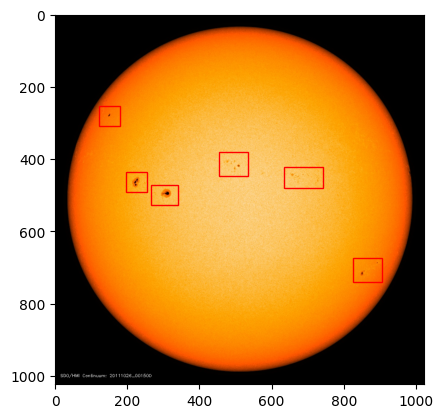

In [37]:
# 'submission.csv' 파일을 읽어와 데이터프레임으로 변환
df_submission = pd.read_csv("submission.csv")

# 11번째 행의 예측 결과를 선택
sample = df_submission.iloc[13]

# 'labels' 열의 값을 문자열로 읽어들이기 때문에 이를 평가하여 리스트로 변환
sample_labels = eval(sample["labels"])

# 예측된 레이블이 없는 경우
if len(sample_labels) == 0:
    print("예측결과: 해당 이미지에선 발견된 이벤트가 없습니다.")
else:
    # 이미지 시각화를 위한 준비
    fig, ax = plt.subplots()
    
    # 이미지 파일을 열고 이를 시각화
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # 예측된 객체의 위치와 크기를 사각형으로 표시
    for label in sample_labels:
        class_id = label["class_id"]  # 클래스 ID를 가져옴
        cx = label["x"] * img.width   # 중심 x 좌표를 원래 이미지 크기에 맞게 변환
        cy = label["y"] * img.height  # 중심 y 좌표를 원래 이미지 크기에 맞게 변환
        w = label["w"] * img.width    # 너비를 원래 이미지 크기에 맞게 변환
        h = label["h"] * img.height   # 높이를 원래 이미지 크기에 맞게 변환

        # 좌상단 좌표 계산 (YOLO 형식은 중심 좌표를 사용하기 때문에 변환이 필요)
        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        # 사각형 패치 생성 및 시각화에 추가
        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)  # 이미지 위에 사각형을 그려 객체의 위치를 표시


## 제출

오른쪽 위의 '제출' 버튼을 클릭하여 제출합니다.